# Emotion Detection Pipeline
## Professional Deep Learning System with Full EDA and Features
## Ofek Raban Ron Gabay

**This notebook includes:**
- EDA and preprocessing 
-  All  classes and functions (self-contained)
-  Advanced features: ablation studies, detailed logging, model comparison
-  Complete experiment tracking and reproducibility
-  Comprehensive visualizations and metrics

### Emotion Classes:
0. Sadness  | 1. Joy  | 2. Love  | 3. Anger  | 4. Fear  | 5. Surprise 

##  Section 1: Imports and Setup

In [1]:
# Standard library
import os
import re
import json
import time
import pickle
import logging
import warnings
from datetime import datetime
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, asdict, field
from collections import Counter

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    precision_recall_fscore_support, accuracy_score
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,
    TensorBoard, CSVLogger, Callback
)

# Embeddings
from gensim.models import Word2Vec
import emoji

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('pipeline.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

logger.info(f"Random seed set to: {RANDOM_SEED}")
print(" All imports successful!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Random Seed: {RANDOM_SEED}")

2025-12-17 14:02:46,425 - INFO - Random seed set to: 42


 All imports successful!
TensorFlow version: 2.13.0
GPU Available: []
Random Seed: 42


##  Section 2: Advanced Configuration

In [2]:
@dataclass
class ExperimentConfig:
    """Complete configuration with ablation flags and advanced options."""
    
    # ========== Experiment Info ==========
    experiment_name: str = "ultimate_emotion_detection"
    random_seed: int = RANDOM_SEED
    
    # ========== Data Paths ==========
    train_path: str = "/home/lab/rabanof/projects/Emotion_Detection_DL/data/raw/train.csv"
    val_path: str = "/home/lab/rabanof/projects/Emotion_Detection_DL/data/raw/validation.csv"
    glove_path: str = "/home/lab/rabanof/Emotion_Detection_DL/glove/glove.6B.100d.txt"
    
    # ========== Data Parameters ==========
    max_len: int = 60
    max_words: int = 20000
    text_column: str = "text"
    label_column: str = "label"
    num_classes: int = 6
    
    # ========== Preprocessing Ablation Flags ==========
    enable_aggressive_normalization: bool = True  # Slang, typos, etc.
    enable_elongation_normalization: bool = True  # sooo -> soo
    enable_contraction_expansion: bool = True     # don't -> do not
    
    # ========== Embedding Configuration ==========
    embedding_type: str = "glove"  # 'glove' or 'word2vec'
    embedding_dim: int = 100
    trainable_embeddings: bool = False  # Ablation: True vs False
    oov_token: str = "<UNK>"
    oov_init_std: float = 0.1  # Std dev for OOV random initialization
    
    # ========== Model Architecture ==========
    model_type: str = "lstm"  # 'lstm', 'gru', 'bilstm', 'bigru'
    rnn_units: int = 128
    num_rnn_layers: int = 1  # Number of recurrent layers
    
    # ========== Regularization ==========
    spatial_dropout: float = 0.2  # After embedding
    dropout: float = 0.2          # After RNN
    recurrent_dropout: float = 0.0  # Within RNN (set to 0 for GPU efficiency)
    use_layer_norm: bool = False   # Layer normalization after RNN
    
    # ========== Training ==========
    epochs: int = 50
    batch_size: int = 32
    learning_rate: float = 0.001
    use_class_weights: bool = True
    
    # ========== Callbacks ==========
    early_stopping: bool = True
    patience: int = 5
    reduce_lr: bool = True
    lr_factor: float = 0.5
    lr_patience: int = 3
    min_lr: float = 1e-7
    
    # ========== Logging & Saving ==========
    verbose: int = 1
    save_tokenizer: bool = True
    save_config: bool = True
    save_embedding_matrix: bool = True
    
    # ========== Directories ==========
    save_dir: str = "saved_models"
    log_dir: str = "logs"
    result_dir: str = "results"
    config_dir: str = "configs"
    
    def to_dict(self) -> Dict:
        """Convert to dictionary."""
        return asdict(self)
    
    def save_to_json(self, filepath: str):
        """Save configuration to JSON file."""
        with open(filepath, 'w') as f:
            json.dump(self.to_dict(), f, indent=2)
        logger.info(f"Configuration saved to {filepath}")

# Create default configuration
config = ExperimentConfig()

# Log configuration
logger.info("="*80)
logger.info("EXPERIMENT CONFIGURATION")
logger.info("="*80)
logger.info(f"Experiment: {config.experiment_name}")
logger.info(f"Model: {config.model_type.upper()}")
logger.info(f"RNN Units: {config.rnn_units}, Layers: {config.num_rnn_layers}")
logger.info(f"Embedding: {config.embedding_type.upper()}, Dim: {config.embedding_dim}, Trainable: {config.trainable_embeddings}")
logger.info(f"Ablation - Aggressive Norm: {config.enable_aggressive_normalization}")
logger.info(f"Ablation - Elongation Norm: {config.enable_elongation_normalization}")
logger.info(f"Random Seed: {config.random_seed}")
logger.info("="*80)

print("\n Configuration created!")
print(f" Experiment: {config.experiment_name}")
print(f" Model: {config.model_type.upper()} ({config.rnn_units} units, {config.num_rnn_layers} layers)")
print(f" Embedding: {config.embedding_type.upper()} {config.embedding_dim}d (Trainable: {config.trainable_embeddings})")

2025-12-17 14:02:46,726 - INFO - ================================================================================


2025-12-17 14:02:46,727 - INFO - EXPERIMENT CONFIGURATION


2025-12-17 14:02:46,728 - INFO - ================================================================================


2025-12-17 14:02:46,729 - INFO - Experiment: ultimate_emotion_detection


2025-12-17 14:02:46,729 - INFO - Model: LSTM


2025-12-17 14:02:46,730 - INFO - RNN Units: 128, Layers: 1


2025-12-17 14:02:46,731 - INFO - Embedding: GLOVE, Dim: 100, Trainable: False


2025-12-17 14:02:46,732 - INFO - Ablation - Aggressive Norm: True


2025-12-17 14:02:46,732 - INFO - Ablation - Elongation Norm: True


2025-12-17 14:02:46,733 - INFO - Random Seed: 42


2025-12-17 14:02:46,734 - INFO - ================================================================================



 Configuration created!
 Experiment: ultimate_emotion_detection
 Model: LSTM (128 units, 1 layers)
 Embedding: GLOVE 100d (Trainable: False)


---

##  How to Use This Notebook

### Quick Start:
1. **Run All Cells**: Execute cells in order from top to bottom
2. **Modify Config**: Change parameters in Section 2 to experiment
3. **Re-run Sections**: After changing config, re-run relevant sections

### Sections Overview:
- **Sections 1-2**: Setup and configuration (always run first)
- **Sections 3-7**: Professional classes (run once)
- **Sections 8-13**: Data loading and EDA (run once)
- **Sections 14**: Preprocessing (run once per config change)
- **Sections 15-16**: Tokenization and embeddings (re-run if embedding changes)
- **Sections 17-19**: Model building and training (re-run for each experiment)
- **Sections 20-23**: Evaluation (re-run after each training)
- **Sections 24-25**: Model comparison (run to compare experiments)
- **Sections 26-27**: Predictions and testing (run anytime after training)
- **Section 28**: Final summary

### Hyperparameter Experiments:
To compare different configurations:
```python
# Experiment 1: LSTM with GloVe
config.model_type = 'lstm'
config.embedding_type = 'glove'
config.rnn_units = 128
# Run sections 15-23

# Experiment 2: GRU with Word2Vec  
config.model_type = 'gru'
config.embedding_type = 'word2vec'
config.rnn_units = 128
config.experiment_name = 'gru_word2vec'
# Run sections 15-23
# Add to comparer: comparer.add_experiment(...)

# View comparison
comparer.create_comparison_table()
```

### Ablation Studies:
Test impact of preprocessing:
```python
config.enable_elongation_normalization = False
config.enable_contraction_expansion = False
# Re-run from Section 14
```

### Key Configuration Parameters:

**Model Architecture:**
- `model_type`: 'lstm', 'gru', 'bilstm', 'bigru'
- `rnn_units`: 64, 128, 256
- `num_rnn_layers`: 1, 2, 3
- `use_layer_norm`: True/False

**Embeddings:**
- `embedding_type`: 'glove', 'word2vec'
- `embedding_dim`: 50, 100, 200, 300
- `trainable_embeddings`: True/False

**Regularization:**
- `dropout`: 0.0 to 0.5
- `spatial_dropout`: 0.0 to 0.5
- `use_class_weights`: True/False

**Training:**
- `epochs`: 20-100
- `batch_size`: 16, 32, 64
- `learning_rate`: 0.0001 to 0.01
- `patience`: 3-10 (early stopping)

---

---
#  HYPERPARAMETER EXPERIMENTATION

**To compare different models:**
1. Modify the configuration in Section 2 (change model_type, rnn_units, embedding_type, etc.)
2. Re-run all cells from Section 15 onwards
3. Use the ModelComparer below to compare results

## Section 3: Advanced Text Preprocessor with Statistics

In [3]:
class AdvancedTextPreprocessor:
    
    # Advanced text preprocessing with ablation flags and statistics logging.
    
    
    def __init__(self, config: ExperimentConfig):
        self.config = config

        # specific contractions by examaples we saw in the data
        self.specific_contractions = {
            "didnt": "did not", "dont": "do not", "cant": "cannot",
            "wont": "will not", "wouldnt": "would not", "shouldnt": "should not",
            "couldnt": "could not", "im": "i am", "ive": "i have",
            "id": "i would", "ill": "i will", "hadnt": "had not",
            "youve": "you have", "werent": "were not", "theyve": "they have",
            "theyll": "they will", "itll": "it will", "couldve": "could have",
            "shouldve": "should have", "wouldve": "would have", "hadn": "had not"
        }
        # General contraction patterns
        self.general_contractions = {
            "n't": " not", "'re": " are", "'s": " is",
            "'d": " would", "'ll": " will", "'t": " not",
            "'ve": " have", "'m": " am"
        }
        
        # slang and typo corrections
        self.slang_corrections = {
            "idk": "i do not know", "yknow": "you know",
            "becuz": "because", "alittle": "a little", "incase": "in case"
        }
        # corrections for common typos
        self.typo_corrections = {
            "vunerable": "vulnerable", "percieve": "perceive",
            "definetly": "definitely", "writting": "writing"
        }
        
        # Statistics
        self.stats = {
            'tokens_before': 0,
            'tokens_after': 0,
            'texts_modified': 0,
            'total_texts': 0
        }
    
    def clean_text(self, text: str) -> str:

        # Apply comprehensive text cleaning with ablation flags.
        
        #check if text is empty
        if not isinstance(text, str):
            return ""
        
        original_text = text
        
        # Lowercase
        text = text.lower()
        
        # Elongation normalization (e.g., sooo -> soo) , save the intense feeling, for 2 chars.
        if self.config.enable_elongation_normalization:
            text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        
        # Contraction expansion (e.g., don't -> do not)
        if self.config.enable_contraction_expansion:
            # Specific contractions first (word boundaries)
            for key, value in self.specific_contractions.items():
                text = re.sub(rf'\b{re.escape(key)}\b', value, text)   #re.sub(pattern, replacement, text)
            
            # General patterns
            for key, value in self.general_contractions.items():
                text = text.replace(key, value)
        
        # Aggressive normalization (slang + typos)
        if self.config.enable_aggressive_normalization:
            for corrections in [self.slang_corrections, self.typo_corrections]:
                for key, value in corrections.items():
                    text = re.sub(rf'\b{re.escape(key)}\b', value, text)
        
        # Reduce repeated punctuation (e.g., !!! -> !)
        text = re.sub(r"([!?.,])\1+", r"\1", text)
        text = re.sub(r"\.{2,}", ".", text)
        
        # Normalize whitespace (remove extra spaces)
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Track if modified
        if text != original_text.lower().strip():
            self.stats['texts_modified'] += 1
        
        return text
    
    def preprocess_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        
        # Preprocess dataframe and collect statistics.
        
        # save a copy to avoid modifying original
        df = df.copy()
        self.stats['total_texts'] = len(df)
        
        # log start
        logger.info(f"Preprocessing {len(df)} samples...")
        
        # Count tokens before
        tokens_before = df[self.config.text_column].str.split().str.len().sum()
        self.stats['tokens_before'] = tokens_before
        
        # Apply cleaning
        df[self.config.text_column] = df[self.config.text_column].apply(self.clean_text)
        
        # Count tokens after
        tokens_after = df[self.config.text_column].str.split().str.len().sum()
        self.stats['tokens_after'] = tokens_after
        
        # Add text length column
        df['text_len'] = df[self.config.text_column].str.split().str.len()
        
        # Log statistics
        avg_before = tokens_before / len(df)
        avg_after = tokens_after / len(df)
        pct_modified = (self.stats['texts_modified'] / len(df)) * 100
        
        logger.info(f"Preprocessing Statistics:")
        logger.info(f"  Avg tokens before: {avg_before:.2f}")
        logger.info(f"  Avg tokens after: {avg_after:.2f}")
        logger.info(f"  Texts modified: {self.stats['texts_modified']} ({pct_modified:.1f}%)")
        
        return df
    
    def remove_duplicates(self, df: pd.DataFrame) -> pd.DataFrame:
        """Remove duplicate texts."""

        initial_len = len(df)
        df = df.drop_duplicates(subset=[self.config.text_column], keep='first')
        removed = initial_len - len(df)
        if removed > 0:
            logger.warning(f"Removed {removed} duplicates")
        return df.reset_index(drop=True)
    
    def check_data_leakage(self, train_df: pd.DataFrame, val_df: pd.DataFrame) -> Tuple[pd.DataFrame, int]:
        """Check and remove overlapping texts."""
        train_texts = set(train_df[self.config.text_column])
        val_texts = set(val_df[self.config.text_column])
        overlaps = val_texts.intersection(train_texts)
        
        if len(overlaps) > 0:
            logger.warning(f"Data leakage: {len(overlaps)} overlapping texts found")
            val_df_clean = val_df[~val_df[self.config.text_column].isin(overlaps)].copy()
            return val_df_clean.reset_index(drop=True), len(overlaps)
        """"avoid data leakage, overlapping samples are removed from the validation set rather than the training set, 
        in order to preserve the integrity and size of the training data while ensuring a fair and unbiased evaluation on the validation set."""
        
        logger.info("No data leakage detected")
        return val_df, 0
    
    def compute_class_weights(self, labels: np.ndarray) -> Dict[int, float]:
        """Compute balanced class weights."""
        # Calculate class weights to handle class imbalance, using sklearn utility for weighted loss.
        classes = np.unique(labels)
        weights = compute_class_weight('balanced', classes=classes, y=labels)
        class_weights = dict(zip(classes, weights))
        
        logger.info(f"Class weights computed: {class_weights}")
        return class_weights
    
    def log_class_distribution(self, labels: np.ndarray, emotion_map: Dict):
        """
        Log class only for distribution with counts, percentages, and imbalance ratio.
        """
        unique, counts = np.unique(labels, return_counts=True)
        total = len(labels)
        
        logger.info("="*80)
        logger.info("CLASS DISTRIBUTION")
        logger.info("="*80)
        
        distribution_data = []
        for label, count in zip(unique, counts):
            pct = (count / total) * 100
            distribution_data.append({
                'label': label,
                'emotion': emotion_map[label],
                'count': count,
                'percentage': pct
            })
            logger.info(f"  {emotion_map[label]:12s}: {count:5d} ({pct:5.2f}%)")
        
        # Calculate imbalance ratio
        max_count = counts.max()
        min_count = counts.min()
        imbalance_ratio = max_count / min_count
        
        logger.info(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
        logger.info(f"(Max: {max_count}, Min: {min_count})")
        logger.info("="*80)
        
        return pd.DataFrame(distribution_data)

print(" Advanced Text Preprocessor class created!")

 Advanced Text Preprocessor class created!


##  Section 4: Advanced Embedding Handler

##  Section 5: Advanced Model Builder

In [4]:
class AdvancedEmbeddingHandler:
    """
    Advanced embedding handler with GloVe/Word2Vec support and detailed analytics.
    """
    
    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.tokenizer = None
        self.embedding_matrix = None
        self.embeddings_index = {}
        self.word2vec_model = None
        
        # Statistics
        self.stats = {
            'vocab_size': 0,
            'coverage_count': 0,
            'coverage_percent': 0.0,
            'oov_count': 0,
            'oov_percent': 0.0,
            'oov_words': []
        }
    
    def create_tokenizer(self, texts: List[str]) -> Tokenizer:
        """
        Create and fit tokenizer on texts.
        """
        logger.info(f"Creating tokenizer with max_words={self.config.max_words}...")
        
        self.tokenizer = Tokenizer(
            num_words=self.config.max_words,
            oov_token=self.config.oov_token,
            lower=True
        )
        self.tokenizer.fit_on_texts(texts)
        
        word_index = self.tokenizer.word_index
        self.stats['vocab_size'] = min(len(word_index), self.config.max_words)
        
        logger.info(f"Tokenizer created. Vocabulary size: {self.stats['vocab_size']}")
        logger.info(f"Total unique words: {len(word_index)}")
        
        return self.tokenizer
    
    def texts_to_sequences(self, texts: List[str]) -> np.ndarray:
        """
        Convert texts to padded sequences.
        """
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(sequences, maxlen=self.config.max_len, padding='post', truncating='post')
        
        logger.info(f"Converted {len(texts)} texts to sequences of length {self.config.max_len}")
        
        return padded
    
    def analyze_sequence_lengths(self, texts: List[str]) -> Dict:
        """
        Analyze sequence lengths and truncation.
        """
        sequences = self.tokenizer.texts_to_sequences(texts)
        lengths = [len(seq) for seq in sequences]
        
        truncated = sum(1 for l in lengths if l > self.config.max_len)
        truncation_pct = (truncated / len(lengths)) * 100
        
        stats = {
            'mean_length': np.mean(lengths),
            'median_length': np.median(lengths),
            'max_length': max(lengths),
            'min_length': min(lengths),
            'truncated_count': truncated,
            'truncation_percent': truncation_pct
        }
        
        logger.info(f"Sequence Length Analysis:")
        logger.info(f"  Mean: {stats['mean_length']:.2f}, Median: {stats['median_length']:.0f}")
        logger.info(f"  Max: {stats['max_length']}, Min: {stats['min_length']}")
        logger.info(f"  Truncated: {truncated} ({truncation_pct:.1f}%)")
        
        return stats, lengths
    
    def load_glove_embeddings(self, glove_path: str):
        """
        Load pre-trained GloVe embeddings.
        """
        logger.info(f"Loading GloVe embeddings from {glove_path}...")
        
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                self.embeddings_index[word] = vector
        
        logger.info(f"Loaded {len(self.embeddings_index)} word vectors")
    
    def train_word2vec(self, texts: List[str], min_count: int = 1):
        """
        Train Word2Vec embeddings on the corpus.
        """
        logger.info("Training Word2Vec embeddings...")
        
        # Tokenize texts into word lists
        tokenized_texts = [text.split() for text in texts]
        
        # Train Word2Vec
        self.word2vec_model = Word2Vec(
            sentences=tokenized_texts,
            vector_size=self.config.embedding_dim,
            window=5,
            min_count=min_count,
            workers=4,
            seed=self.config.random_seed
        )
        
        logger.info(f"Word2Vec trained on {len(texts)} texts")
        logger.info(f"Vocabulary size: {len(self.word2vec_model.wv)}")
    
    def create_embedding_matrix(self) -> np.ndarray:
        """
        Create embedding matrix from GloVe or Word2Vec.
        """
        if self.tokenizer is None:
            raise ValueError("Tokenizer must be created first")
        
        word_index = self.tokenizer.word_index
        vocab_size = min(len(word_index) + 1, self.config.max_words + 1)
        
        # Initialize with small random values
        self.embedding_matrix = np.random.normal(
            0, self.config.oov_init_std, 
            (vocab_size, self.config.embedding_dim)
        )
        
        # Set padding vector to zeros
        self.embedding_matrix[0] = np.zeros(self.config.embedding_dim)
        
        # Fill with pre-trained vectors
        found_count = 0
        oov_words = []
        
        for word, i in word_index.items():
            if i >= self.config.max_words:
                continue
            
            embedding_vector = None
            
            if self.config.embedding_type == 'glove':
                embedding_vector = self.embeddings_index.get(word)
            elif self.config.embedding_type == 'word2vec' and self.word2vec_model:
                try:
                    embedding_vector = self.word2vec_model.wv[word]
                except KeyError:
                    pass
            
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector
                found_count += 1
            else:
                oov_words.append(word)
        
        # Update statistics
        self.stats['coverage_count'] = found_count
        self.stats['coverage_percent'] = (found_count / (vocab_size - 1)) * 100
        self.stats['oov_count'] = len(oov_words)
        self.stats['oov_percent'] = (len(oov_words) / (vocab_size - 1)) * 100
        self.stats['oov_words'] = oov_words[:100]  # Store first 100
        
        logger.info(f"Embedding Matrix Created:")
        logger.info(f"  Shape: {self.embedding_matrix.shape}")
        logger.info(f"  Coverage: {found_count}/{vocab_size-1} ({self.stats['coverage_percent']:.2f}%)")
        logger.info(f"  OOV: {len(oov_words)} ({self.stats['oov_percent']:.2f}%)")
        
        return self.embedding_matrix
    
    def get_oov_rate(self, sequences: np.ndarray) -> float:
        """
        Calculate OOV rate in sequences.
        """
        if self.tokenizer is None:
            return 0.0
        
        oov_index = self.tokenizer.word_index.get(self.config.oov_token, 1)
        total_tokens = sequences.size
        oov_tokens = np.sum(sequences == oov_index)
        
        oov_rate = (oov_tokens / total_tokens) * 100
        return oov_rate
    
    def save_tokenizer(self, filepath: str):
        """Save tokenizer to JSON file."""
        if self.tokenizer is None:
            logger.warning("No tokenizer to save")
            return
        
        tokenizer_json = self.tokenizer.to_json()
        with open(filepath, 'w') as f:
            f.write(tokenizer_json)
        logger.info(f"Tokenizer saved to {filepath}")
    
    def save_embedding_matrix(self, filepath: str):
        """Save embedding matrix to numpy file."""
        if self.embedding_matrix is None:
            logger.warning("No embedding matrix to save")
            return
        
        np.save(filepath, self.embedding_matrix)
        logger.info(f"Embedding matrix saved to {filepath}")

print(" AdvancedEmbeddingHandler class created!")

 AdvancedEmbeddingHandler class created!


##  Section 6: Results Visualizer

In [5]:
class AdvancedModelBuilder:
    """
    Advanced model builder supporting LSTM, GRU, and Bidirectional variants.
    """
    
    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.model = None
    
    def build_model(self, embedding_matrix: np.ndarray) -> keras.Model:
        """
        Build model based on configuration.
        """
        logger.info(f"Building {self.config.model_type.upper()} model...")
        
        vocab_size, embedding_dim = embedding_matrix.shape
        
        # Input layer
        inputs = layers.Input(shape=(self.config.max_len,), name='input')
        
        # Embedding layer
        x = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=self.config.max_len,
            trainable=self.config.trainable_embeddings,
            name='embedding'
        )(inputs)
        
        # Spatial dropout after embedding
        if self.config.spatial_dropout > 0:
            x = layers.SpatialDropout1D(self.config.spatial_dropout, name='spatial_dropout')(x)
        
        # Recurrent layers
        for layer_idx in range(self.config.num_rnn_layers):
            return_sequences = (layer_idx < self.config.num_rnn_layers - 1)
            
            # Choose RNN type
            if self.config.model_type in ['lstm', 'bilstm']:
                rnn_layer = layers.LSTM(
                    units=self.config.rnn_units,
                    return_sequences=return_sequences,
                    dropout=self.config.dropout if layer_idx == 0 else 0,
                    recurrent_dropout=self.config.recurrent_dropout,
                    name=f'lstm_{layer_idx+1}'
                )
            elif self.config.model_type in ['gru', 'bigru']:
                rnn_layer = layers.GRU(
                    units=self.config.rnn_units,
                    return_sequences=return_sequences,
                    dropout=self.config.dropout if layer_idx == 0 else 0,
                    recurrent_dropout=self.config.recurrent_dropout,
                    name=f'gru_{layer_idx+1}'
                )
            else:
                raise ValueError(f"Unknown model type: {self.config.model_type}")
            
            # Apply bidirectional wrapper if needed
            if self.config.model_type in ['bilstm', 'bigru']:
                rnn_layer = layers.Bidirectional(rnn_layer, name=f'bidirectional_{layer_idx+1}')
            
            x = rnn_layer(x)
            
            # Layer normalization if enabled
            if self.config.use_layer_norm:
                x = layers.LayerNormalization(name=f'layer_norm_{layer_idx+1}')(x)
            
            # Dropout after RNN (except for last layer)
            if self.config.dropout > 0 and layer_idx < self.config.num_rnn_layers - 1:
                x = layers.Dropout(self.config.dropout, name=f'dropout_{layer_idx+1}')(x)
        
        # Output layer
        outputs = layers.Dense(
            self.config.num_classes,
            activation='softmax',
            name='output'
        )(x)
        
        # Create model
        self.model = keras.Model(inputs=inputs, outputs=outputs, name=f'{self.config.model_type}_model')
        
        # Compile model
        self.model.compile(
            optimizer=Adam(learning_rate=self.config.learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        logger.info("Model built successfully!")
        logger.info(f"  Type: {self.config.model_type.upper()}")
        logger.info(f"  Units: {self.config.rnn_units}, Layers: {self.config.num_rnn_layers}")
        logger.info(f"  Trainable embeddings: {self.config.trainable_embeddings}")
        logger.info(f"  Total parameters: {self.model.count_params():,}")
        
        return self.model
    
    def get_model_summary(self) -> str:
        """Get model summary as string."""
        if self.model is None:
            return "No model built yet"
        
        # Capture summary
        from io import StringIO
        stream = StringIO()
        self.model.summary(print_fn=lambda x: stream.write(x + '\n'))
        return stream.getvalue()

print(" AdvancedModelBuilder class created!")

 AdvancedModelBuilder class created!


##  Section 7: Experiment Tracker and Callback

In [6]:
class ResultsVisualizer:
    """
    Comprehensive visualization class for model results and analysis.
    """
    
    def __init__(self, emotion_map: Dict[int, str]):
        self.emotion_map = emotion_map
        self.emotion_names = [emotion_map[i] for i in sorted(emotion_map.keys())]
    
    def plot_training_history(self, history, save_path: Optional[str] = None):
        """Plot training and validation accuracy/loss curves."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Accuracy plot
        ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
        ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
        ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Loss plot
        ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
        ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
        ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_confusion_matrix(self, y_true, y_pred, normalize=False, save_path: Optional[str] = None):
        """Plot confusion matrix."""
        # Convert one-hot to labels if needed
        if len(y_true.shape) > 1:
            y_true = y_true.argmax(axis=1)
        if len(y_pred.shape) > 1:
            y_pred = y_pred.argmax(axis=1)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fmt = '.2%'
            title = 'Normalized Confusion Matrix'
        else:
            fmt = 'd'
            title = 'Confusion Matrix'
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                    xticklabels=self.emotion_names, yticklabels=self.emotion_names,
                    cbar_kws={'label': 'Percentage' if normalize else 'Count'})
        plt.title(title, fontsize=14, fontweight='bold', pad=20)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_classification_report(self, y_true, y_pred, save_path: Optional[str] = None):
        """Plot classification report as heatmap."""
        # Convert one-hot to labels if needed
        if len(y_true.shape) > 1:
            y_true = y_true.argmax(axis=1)
        if len(y_pred.shape) > 1:
            y_pred = y_pred.argmax(axis=1)
        
        # Get metrics
        precision, recall, f1, support = precision_recall_fscore_support(
            y_true, y_pred, labels=list(range(len(self.emotion_names)))
        )
        
        # Create dataframe
        metrics_df = pd.DataFrame({
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }, index=self.emotion_names)
        
        # Plot
        plt.figure(figsize=(10, 6))
        sns.heatmap(metrics_df.T, annot=True, fmt='.3f', cmap='RdYlGn', 
                    vmin=0, vmax=1, cbar_kws={'label': 'Score'})
        plt.title('Classification Report by Emotion', fontsize=14, fontweight='bold', pad=20)
        plt.ylabel('Metric', fontsize=12)
        plt.xlabel('Emotion', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return metrics_df
    
    def plot_per_class_metrics(self, y_true, y_pred, metric='f1', save_path: Optional[str] = None):
        """Plot per-class metrics as bar chart."""
        # Convert one-hot to labels if needed
        if len(y_true.shape) > 1:
            y_true = y_true.argmax(axis=1)
        if len(y_pred.shape) > 1:
            y_pred = y_pred.argmax(axis=1)
        
        # Get metrics
        precision, recall, f1, support = precision_recall_fscore_support(
            y_true, y_pred, labels=list(range(len(self.emotion_names)))
        )
        
        # Select metric
        metric_map = {
            'precision': ('Precision', precision),
            'recall': ('Recall', recall),
            'f1': ('F1-Score', f1)
        }
        
        metric_name, values = metric_map.get(metric.lower(), ('F1-Score', f1))
        
        # Plot
        plt.figure(figsize=(10, 6))
        colors = plt.cm.viridis(np.linspace(0, 1, len(self.emotion_names)))
        bars = plt.bar(self.emotion_names, values, color=colors, edgecolor='black', linewidth=1.5)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontweight='bold')
        
        plt.title(f'Per-Class {metric_name}', fontsize=14, fontweight='bold')
        plt.ylabel(metric_name, fontsize=12)
        plt.xlabel('Emotion', fontsize=12)
        plt.ylim(0, 1.1)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_label_distribution(self, labels, title='Label Distribution', save_path: Optional[str] = None):
        """Plot label distribution."""
        unique, counts = np.unique(labels, return_counts=True)
        
        plt.figure(figsize=(10, 6))
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique)))
        bars = plt.bar([self.emotion_map[i] for i in unique], counts, color=colors, 
                      edgecolor='black', linewidth=1.5)
        
        # Add percentages
        total = sum(counts)
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            pct = (count / total) * 100
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{count}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontweight='bold')
        
        plt.title(title, fontsize=14, fontweight='bold')
        plt.ylabel('Count', fontsize=12)
        plt.xlabel('Emotion', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_text_length_distribution(self, text_lengths, max_len=None, save_path: Optional[str] = None):
        """Plot text length distribution."""
        plt.figure(figsize=(12, 5))
        
        plt.hist(text_lengths, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
        plt.axvline(np.mean(text_lengths), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(text_lengths):.1f}')
        plt.axvline(np.median(text_lengths), color='green', linestyle='--', 
                   linewidth=2, label=f'Median: {np.median(text_lengths):.0f}')
        
        if max_len:
            plt.axvline(max_len, color='orange', linestyle='--', 
                       linewidth=2, label=f'MAX_LEN: {max_len}')
        
        plt.title('Text Length Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Text Length (words)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(axis='y', alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_word_cloud(self, texts, title='Word Cloud', save_path: Optional[str] = None):
        """Generate and plot word cloud."""
        # Combine all texts
        combined_text = ' '.join(texts)
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            colormap='viridis',
            max_words=100,
            relative_scaling=0.5,
            min_font_size=10
        ).generate(combined_text)
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('off')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

print(" ResultsVisualizer class created!")

 ResultsVisualizer class created!


##  Section 8: Load Data

---
#  DATA LOADING AND EXPLORATION

This section includes all original EDA from your full_pipeline.ipynb

In [7]:
class ExperimentTracker(Callback):
    """
    Custom Keras callback to track experiment metrics and training time.
    """
    
    def __init__(self, config: ExperimentConfig):
        super().__init__()
        self.config = config
        self.experiment_results = {
            'config': config.to_dict(),
            'training_time_per_epoch': [],
            'total_training_time': 0,
            'best_val_accuracy': 0,
            'best_epoch': 0
        }
        self.epoch_start_time = None
    
    def on_epoch_begin(self, epoch, logs=None):
        """Record epoch start time."""
        self.epoch_start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        """Record epoch metrics and time."""
        epoch_time = time.time() - self.epoch_start_time
        self.experiment_results['training_time_per_epoch'].append(epoch_time)
        
        # Track best validation accuracy
        val_acc = logs.get('val_accuracy', 0)
        if val_acc > self.experiment_results['best_val_accuracy']:
            self.experiment_results['best_val_accuracy'] = val_acc
            self.experiment_results['best_epoch'] = epoch + 1
        
        if self.config.verbose:
            logger.info(f"Epoch {epoch+1} completed in {epoch_time:.2f}s - "
                       f"val_acc: {val_acc:.4f}")
    
    def on_train_end(self, logs=None):
        """Record total training time."""
        self.experiment_results['total_training_time'] = sum(
            self.experiment_results['training_time_per_epoch']
        )
        
        logger.info(f"Training completed!")
        logger.info(f"  Total time: {self.experiment_results['total_training_time']:.2f}s")
        logger.info(f"  Best val accuracy: {self.experiment_results['best_val_accuracy']:.4f} "
                   f"at epoch {self.experiment_results['best_epoch']}")
    
    def get_results(self) -> Dict:
        """Get experiment results."""
        return self.experiment_results
    
    def save_results(self, filepath: str):
        """Save results to JSON file."""
        with open(filepath, 'w') as f:
            json.dump(self.experiment_results, f, indent=2)
        logger.info(f"Experiment results saved to {filepath}")


class ModelComparer:
    """
    Compare multiple model configurations and results.
    """
    
    def __init__(self, emotion_map: Dict[int, str]):
        self.emotion_map = emotion_map
        self.experiments = []
    
    def add_experiment(self, name: str, config: ExperimentConfig, history, 
                      metrics: Dict, predictions=None, y_true=None):
        """Add experiment results for comparison."""
        experiment = {
            'name': name,
            'config': config.to_dict(),
            'history': history.history if hasattr(history, 'history') else history,
            'metrics': metrics,
            'predictions': predictions,
            'y_true': y_true
        }
        self.experiments.append(experiment)
        logger.info(f"Added experiment: {name}")
    
    def create_comparison_table(self) -> pd.DataFrame:
        """Create comparison table of all experiments."""
        comparison_data = []
        
        for exp in self.experiments:
            config = exp['config']
            metrics = exp['metrics']
            
            comparison_data.append({
                'Experiment': exp['name'],
                'Model': config['model_type'].upper(),
                'RNN Units': config['rnn_units'],
                'Layers': config['num_rnn_layers'],
                'Embedding': config['embedding_type'].upper(),
                'Embed Dim': config['embedding_dim'],
                'Trainable Emb': config['trainable_embeddings'],
                'Dropout': config['dropout'],
                'Val Accuracy': metrics.get('val_accuracy', 0),
                'Val Loss': metrics.get('val_loss', 0),
                'Macro F1': metrics.get('macro_f1', 0),
                'Training Time': metrics.get('training_time', 0)
            })
        
        df = pd.DataFrame(comparison_data)
        return df.sort_values('Val Accuracy', ascending=False)
    
    def plot_comparison(self, metric='val_accuracy', save_path: Optional[str] = None):
        """Plot comparison of experiments."""
        if not self.experiments:
            print("No experiments to compare")
            return
        
        names = [exp['name'] for exp in self.experiments]
        values = [exp['metrics'].get(metric, 0) for exp in self.experiments]
        
        plt.figure(figsize=(12, 6))
        colors = plt.cm.viridis(np.linspace(0, 1, len(names)))
        bars = plt.bar(names, values, color=colors, edgecolor='black', linewidth=1.5)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', fontweight='bold')
        
        plt.title(f'Model Comparison: {metric}', fontsize=14, fontweight='bold')
        plt.ylabel(metric, fontsize=12)
        plt.xlabel('Experiment', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_comparison(self, filepath: str):
        """Save comparison table to CSV."""
        df = self.create_comparison_table()
        df.to_csv(filepath, index=False)
        logger.info(f"Comparison table saved to {filepath}")

print(" ExperimentTracker and ModelComparer classes created!")

 ExperimentTracker and ModelComparer classes created!


##  Section 9: Class Distribution Analysis

In [8]:
# Emotion mapping (your original mapping)
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Load datasets
logger.info("Loading datasets...")
train_df = pd.read_csv(config.train_path)
val_df = pd.read_csv(config.val_path)

print("="*80)
print("TRAINING DATA")
print("="*80)
print(f"Shape: {train_df.shape}")
print(f"\nFirst 5 rows:")
print(train_df.head())
print(f"\nData Info:")
print(train_df.info())
print(f"\nMissing values:")
print(train_df.isnull().sum())
print(f"\nLabel distribution:")
print(train_df['label'].value_counts().sort_index())

print("\n" + "="*80)
print("VALIDATION DATA")
print("="*80)
print(f"Shape: {val_df.shape}")
print(f"\nFirst 5 rows:")
print(val_df.head())
print(f"\nData Info:")
print(val_df.info())
print(f"\nMissing values:")
print(val_df.isnull().sum())
print(f"\nLabel distribution:")
print(val_df['label'].value_counts().sort_index())

# Store original data size
original_train_size = len(train_df)
original_val_size = len(val_df)

logger.info(f"Loaded {original_train_size} training and {original_val_size} validation samples")

2025-12-17 14:02:46,867 - INFO - Loading datasets...


2025-12-17 14:02:46,924 - INFO - Loaded 16000 training and 2000 validation samples


TRAINING DATA
Shape: (16000, 2)

First 5 rows:
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB
None

Missing values:
text     0
label    0
dtype: int64

Label distribution:
label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64

VALIDATION DATA
Shape: (2000, 2)

First 5 rows:
                                                text  labe

##  Section 10: Text Length Analysis

CLASS DISTRIBUTION TABLE


 Label  Emotion  Train Count Train %  Val Count  Val %
     0  sadness         4666  29.16%        550 27.50%
     1      joy         5362  33.51%        704 35.20%
     2     love         1304   8.15%        178  8.90%
     3    anger         2159  13.49%        275 13.75%
     4     fear         1937  12.11%        212 10.60%
     5 surprise          572   3.57%         81  4.05%

CLASS IMBALANCE RATIO: 9.37:1
Most common: JOY (5362 samples)
Least common: SURPRISE (572 samples)



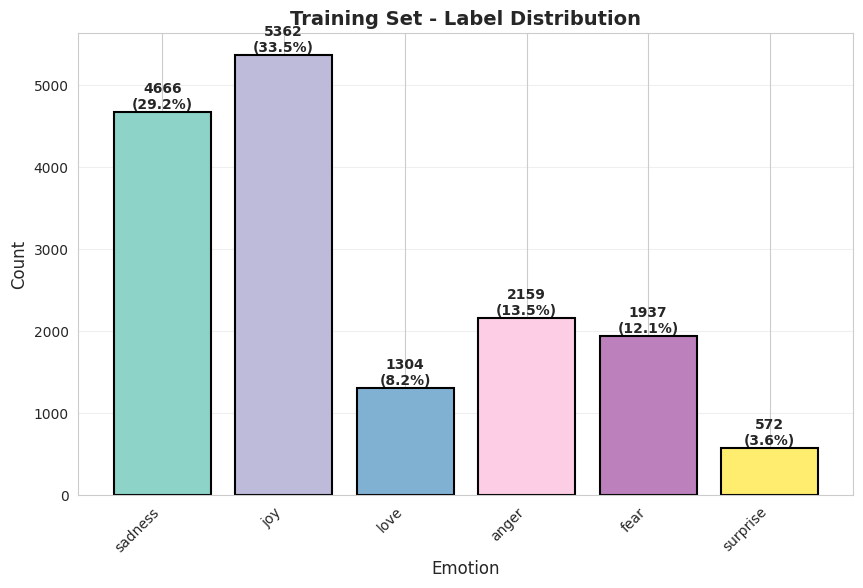

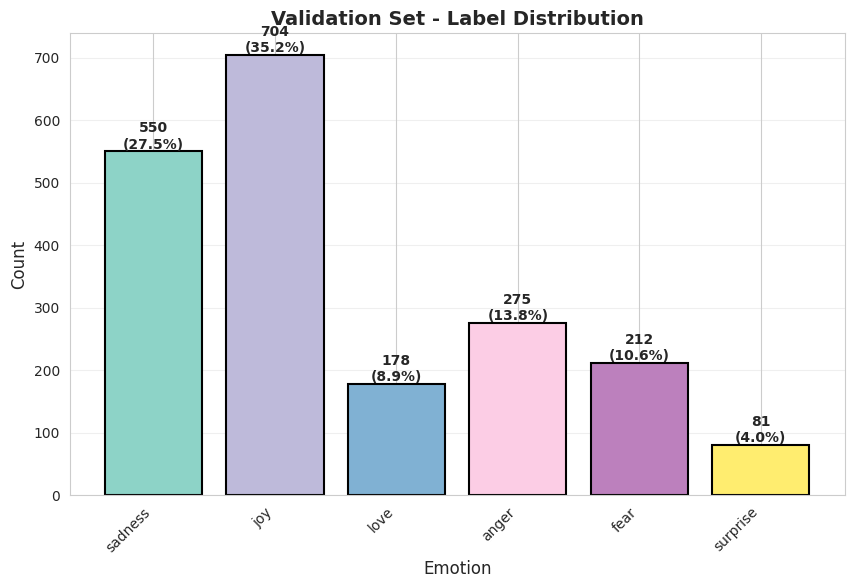

In [9]:
# Initialize visualizer
visualizer = ResultsVisualizer(emotion_map)

# Create detailed class distribution table
print("="*80)
print("CLASS DISTRIBUTION TABLE")
print("="*80)

train_labels = train_df['label'].values
val_labels = val_df['label'].values

# Training set distribution
train_unique, train_counts = np.unique(train_labels, return_counts=True)
train_total = len(train_labels)

train_dist = []
for label, count in zip(train_unique, train_counts):
    pct = (count / train_total) * 100
    train_dist.append({
        'Label': label,
        'Emotion': emotion_map[label],
        'Train Count': count,
        'Train %': f"{pct:.2f}%"
    })

# Validation set distribution
val_unique, val_counts = np.unique(val_labels, return_counts=True)
val_total = len(val_labels)

for i, (label, count) in enumerate(zip(val_unique, val_counts)):
    pct = (count / val_total) * 100
    train_dist[i]['Val Count'] = count
    train_dist[i]['Val %'] = f"{pct:.2f}%"

dist_df = pd.DataFrame(train_dist)
print(dist_df.to_string(index=False))

# Calculate imbalance ratio
max_count = train_counts.max()
min_count = train_counts.min()
imbalance_ratio = max_count / min_count

print(f"\n{'='*80}")
print(f"CLASS IMBALANCE RATIO: {imbalance_ratio:.2f}:1")
print(f"Most common: {emotion_map[train_unique[train_counts.argmax()]].upper()} ({max_count} samples)")
print(f"Least common: {emotion_map[train_unique[train_counts.argmin()]].upper()} ({min_count} samples)")
print(f"{'='*80}\n")

# Visualize distributions
visualizer.plot_label_distribution(train_labels, title='Training Set - Label Distribution')
visualizer.plot_label_distribution(val_labels, title='Validation Set - Label Distribution')

##  Section 11: Word Clouds by Emotion

TEXT LENGTH STATISTICS (Before Preprocessing)

Training Set:
count    16000.000000
mean        19.166313
std         10.986905
min          2.000000
25%         11.000000
50%         17.000000
75%         25.000000
max         66.000000
Name: text_len, dtype: float64

Validation Set:
count    2000.000000
mean       18.866000
std        10.813025
min         2.000000
25%        10.000000
50%        17.000000
75%        25.000000
max        61.000000
Name: text_len, dtype: float64


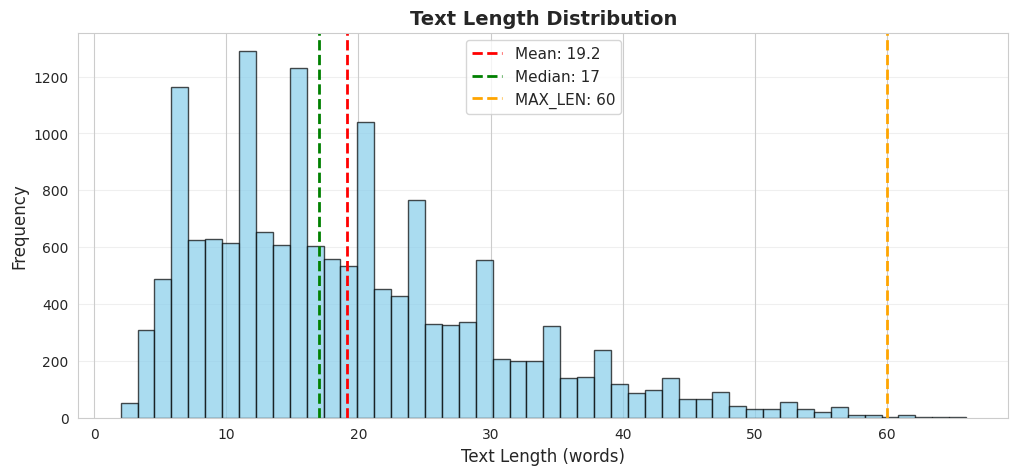


AVERAGE TEXT LENGTH BY EMOTION
Sadness     : 18.36 words
Joy         : 19.50 words
Love        : 20.70 words
Anger       : 19.23 words
Fear        : 18.84 words
Surprise    : 19.97 words


In [10]:
# Calculate text lengths (in words)
train_df['text_len'] = train_df['text'].str.split().str.len()
val_df['text_len'] = val_df['text'].str.split().str.len()

print("="*80)
print("TEXT LENGTH STATISTICS (Before Preprocessing)")
print("="*80)
print("\nTraining Set:")
print(train_df['text_len'].describe())
print("\nValidation Set:")
print(val_df['text_len'].describe())
print("="*80)

# Visualize text length distribution
visualizer.plot_text_length_distribution(
    train_df['text_len'].values, 
    max_len=config.max_len,
    save_path=None
)

# Text length by emotion
print("\n" + "="*80)
print("AVERAGE TEXT LENGTH BY EMOTION")
print("="*80)
for label in sorted(emotion_map.keys()):
    emotion = emotion_map[label]
    avg_len = train_df[train_df['label'] == label]['text_len'].mean()
    print(f"{emotion.capitalize():12s}: {avg_len:.2f} words")
print("="*80)

##  Section 12: Most Common Words Analysis

Generating word clouds for each emotion...


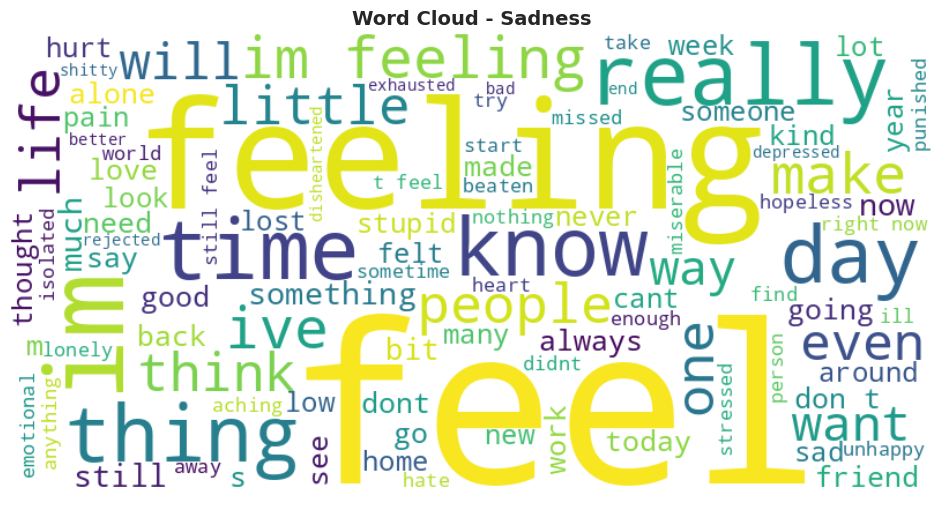

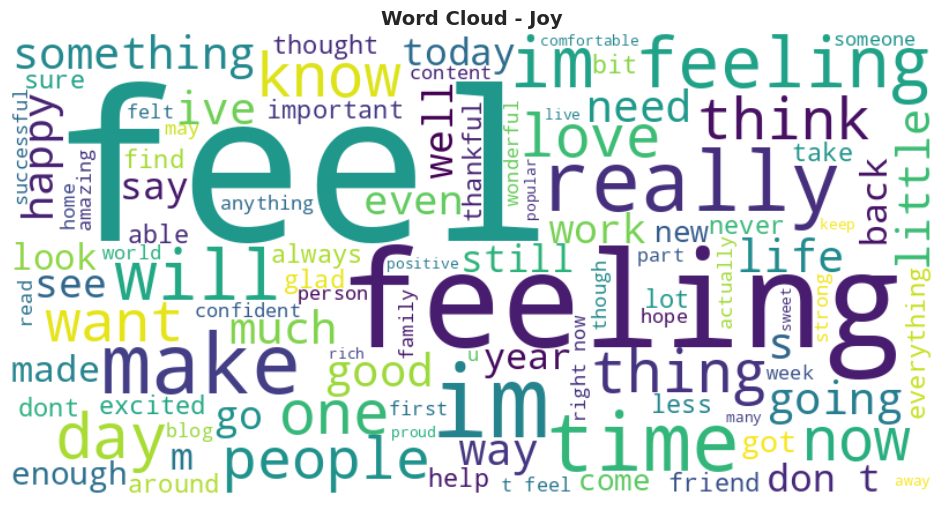

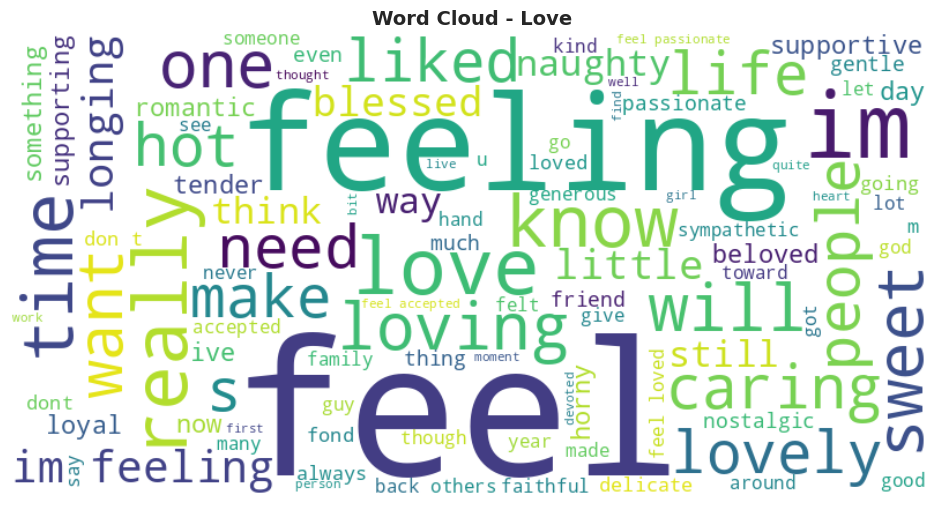

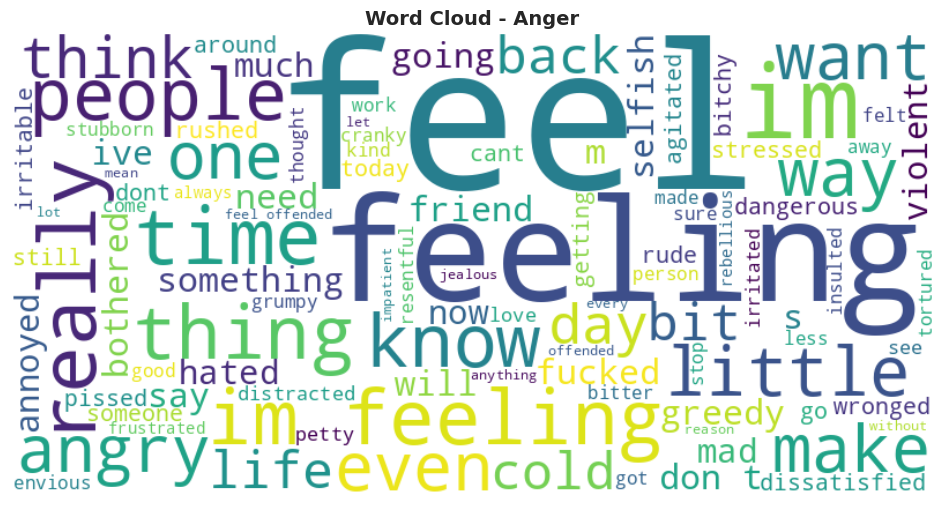

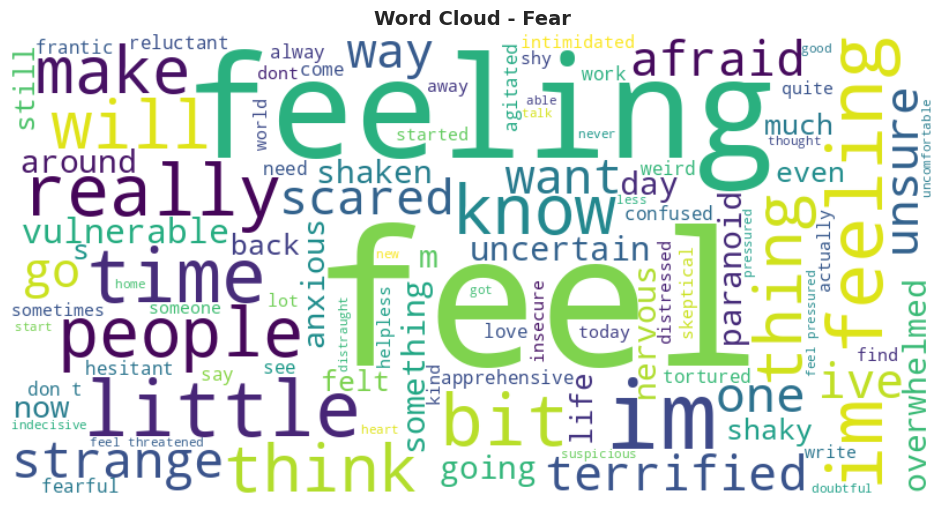

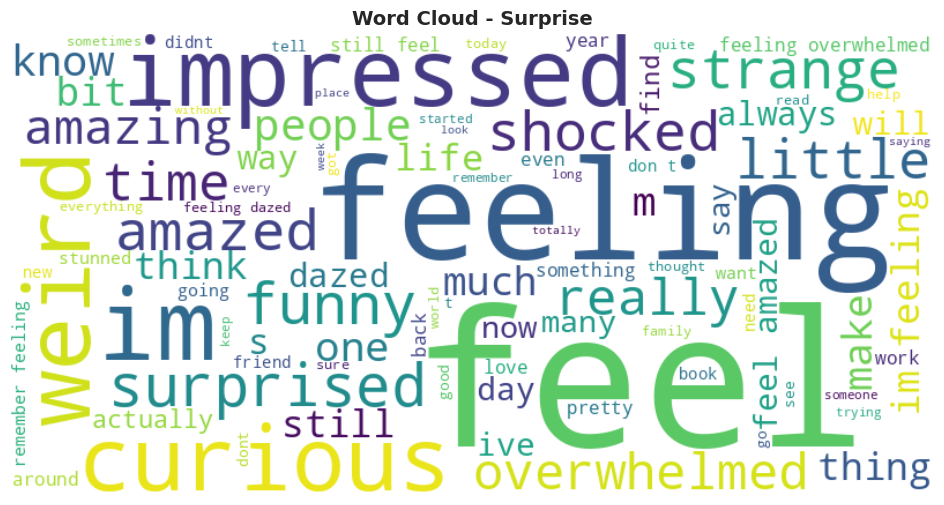

In [11]:
# Generate word clouds for each emotion
print("Generating word clouds for each emotion...")

for label in sorted(emotion_map.keys()):
    emotion = emotion_map[label]
    texts = train_df[train_df['label'] == label]['text'].values
    visualizer.plot_word_cloud(texts, title=f'Word Cloud - {emotion.capitalize()}')

##  Section 13: Check for Twitter Noise (Emojis, Hashtags, Mentions)

In [12]:
# Most common words per emotion
print("="*80)
print("TOP 10 MOST COMMON WORDS BY EMOTION")
print("="*80)

for label in sorted(emotion_map.keys()):
    emotion = emotion_map[label]
    texts = train_df[train_df['label'] == label]['text'].values
    
    # Combine all texts and split into words
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    
    print(f"\n{emotion.upper()} (Label {label}):")
    for word, count in word_counts.most_common(10):
        print(f"  {word:15s}: {count:5d}")

print("\n" + "="*80)

TOP 10 MOST COMMON WORDS BY EMOTION

SADNESS (Label 0):
  i              :  7635
  feel           :  3299
  and            :  2692
  to             :  2335
  the            :  2155
  a              :  1656
  feeling        :  1523
  of             :  1422
  that           :  1299
  my             :  1245

JOY (Label 1):
  i              :  8518
  feel           :  3928
  and            :  3273
  to             :  3232
  the            :  2991
  a              :  2120
  that           :  1905
  of             :  1651
  feeling        :  1539
  my             :  1378

LOVE (Label 2):
  i              :  2120
  feel           :   929
  and            :   902
  to             :   860
  the            :   780
  a              :   571
  of             :   482
  that           :   460
  my             :   399
  feeling        :   378

ANGER (Label 3):
  i              :  3576
  feel           :  1459
  and            :  1258
  to             :  1162
  the            :  1109
  a              :

##  Section 14: Text Preprocessing with Statistics

---
#  PREPROCESSING AND DATA PREPARATION

In [13]:
# Check for Twitter-specific elements
print("="*80)
print("CHECKING FOR TWITTER NOISE")
print("="*80)

# Check for emojis
def contains_emoji(text):
    return any(char in emoji.EMOJI_DATA for char in text)

# Check for hashtags
def contains_hashtag(text):
    return '#' in text

# Check for mentions
def contains_mention(text):
    return '@' in text

# Analyze training set
all_texts = train_df['text'].values
emoji_count = sum(contains_emoji(text) for text in all_texts)
hashtag_count = sum(contains_hashtag(text) for text in all_texts)
mention_count = sum(contains_mention(text) for text in all_texts)

print(f"\nTexts with emojis: {emoji_count} ({emoji_count/len(all_texts)*100:.2f}%)")
print(f"Texts with hashtags: {hashtag_count} ({hashtag_count/len(all_texts)*100:.2f}%)")
print(f"Texts with mentions: {mention_count} ({mention_count/len(all_texts)*100:.2f}%)")

# Check for URLs
url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
url_count = sum(1 for text in all_texts if url_pattern.search(text))
print(f"Texts with URLs: {url_count} ({url_count/len(all_texts)*100:.2f}%)")

print("\n" + "="*80)
print("CONCLUSION: Dataset is clean - minimal Twitter noise detected")
print("="*80)

CHECKING FOR TWITTER NOISE



Texts with emojis: 0 (0.00%)
Texts with hashtags: 0 (0.00%)
Texts with mentions: 0 (0.00%)
Texts with URLs: 0 (0.00%)

CONCLUSION: Dataset is clean - minimal Twitter noise detected


##  Section 15: Tokenization and Sequence Analysis

---
#  TOKENIZATION AND EMBEDDING

In [14]:
# Initialize preprocessor
preprocessor = AdvancedTextPreprocessor(config)

print("="*80)
print("PREPROCESSING CONFIGURATION")
print("="*80)
print(f"Aggressive Normalization: {config.enable_aggressive_normalization}")
print(f"Elongation Normalization: {config.enable_elongation_normalization}")
print(f"Contraction Expansion: {config.enable_contraction_expansion}")
print("="*80)

# Show before/after examples
print("\n" + "="*80)
print("PREPROCESSING EXAMPLES (Before → After)")
print("="*80)

sample_texts = [
    "i didnt feel good about this sooo bad situation!!!",
    "im feeling amazing today cant wait",
    "i love you sooooo much!!!",
    "dont be angry with me pleeease",
    "im scared idk what to do",
    "omg this is soooo surprising!!"
]

for i, text in enumerate(sample_texts, 1):
    cleaned = preprocessor.clean_text(text)
    print(f"\n{i}. Original: {text}")
    print(f"   Cleaned:  {cleaned}")

print("\n" + "="*80)

# Preprocess datasets
print("\nPreprocessing training data...")
train_df_clean = preprocessor.preprocess_dataframe(train_df.copy())

print("\nPreprocessing validation data...")
val_df_clean = preprocessor.preprocess_dataframe(val_df.copy())

# Check for duplicates
print("\nChecking for duplicates...")
train_df_clean = preprocessor.remove_duplicates(train_df_clean)

# Check for data leakage
print("\nChecking for data leakage between train and validation...")
val_df_clean, leakage_count = preprocessor.check_data_leakage(train_df_clean, val_df_clean)

if leakage_count > 0:
    print(f"  Removed {leakage_count} overlapping texts from validation set")
else:
    print(" No data leakage detected")

# Display preprocessing statistics
print("\n" + "="*80)
print("PREPROCESSING STATISTICS SUMMARY")
print("="*80)
print(f"Training set:")
print(f"  Original size: {original_train_size}")
print(f"  Final size: {len(train_df_clean)}")
print(f"  Texts modified: {preprocessor.stats['texts_modified']}")
print(f"\nValidation set:")
print(f"  Original size: {original_val_size}")
print(f"  Final size: {len(val_df_clean)}")
print("="*80)

2025-12-17 14:02:51,964 - INFO - Preprocessing 16000 samples...


PREPROCESSING CONFIGURATION
Aggressive Normalization: True
Elongation Normalization: True
Contraction Expansion: True

PREPROCESSING EXAMPLES (Before → After)

1. Original: i didnt feel good about this sooo bad situation!!!
   Cleaned:  i did not feel good about this soo bad situation!

2. Original: im feeling amazing today cant wait
   Cleaned:  i am feeling amazing today cannot wait

3. Original: i love you sooooo much!!!
   Cleaned:  i love you soo much!

4. Original: dont be angry with me pleeease
   Cleaned:  do not be angry with me pleease

5. Original: im scared idk what to do
   Cleaned:  i am scared i do not know what to do

6. Original: omg this is soooo surprising!!
   Cleaned:  omg this is soo surprising!


Preprocessing training data...


2025-12-17 14:02:54,123 - INFO - Preprocessing Statistics:


2025-12-17 14:02:54,125 - INFO -   Avg tokens before: 19.17


2025-12-17 14:02:54,125 - INFO -   Avg tokens after: 19.44


2025-12-17 14:02:54,126 - INFO -   Texts modified: 3850 (24.1%)


2025-12-17 14:02:54,127 - INFO - Preprocessing 2000 samples...



Preprocessing validation data...


2025-12-17 14:02:54,402 - INFO - Preprocessing Statistics:


2025-12-17 14:02:54,403 - INFO -   Avg tokens before: 18.87


2025-12-17 14:02:54,403 - INFO -   Avg tokens after: 19.14


2025-12-17 14:02:54,404 - INFO -   Texts modified: 4338 (216.9%)


2025-12-17 14:02:54,409 - WARNING - Removed 34 duplicates


2025-12-17 14:02:54,412 - WARNING - Data leakage: 5 overlapping texts found



Checking for duplicates...

Checking for data leakage between train and validation...
  Removed 5 overlapping texts from validation set

PREPROCESSING STATISTICS SUMMARY
Training set:
  Original size: 16000
  Final size: 15966
  Texts modified: 4338

Validation set:
  Original size: 2000
  Final size: 1995


##  Section 16: Load/Train Embeddings and Create Embedding Matrix

2025-12-17 14:02:54,432 - INFO - Creating tokenizer with max_words=20000...


CREATING TOKENIZER


2025-12-17 14:02:54,723 - INFO - Tokenizer created. Vocabulary size: 15156


2025-12-17 14:02:54,725 - INFO - Total unique words: 15156


2025-12-17 14:02:54,929 - INFO - Sequence Length Analysis:


2025-12-17 14:02:54,930 - INFO -   Mean: 19.45, Median: 17


2025-12-17 14:02:54,931 - INFO -   Max: 70, Min: 2



SEQUENCE LENGTH ANALYSIS


2025-12-17 14:02:54,931 - INFO -   Truncated: 16 (0.1%)


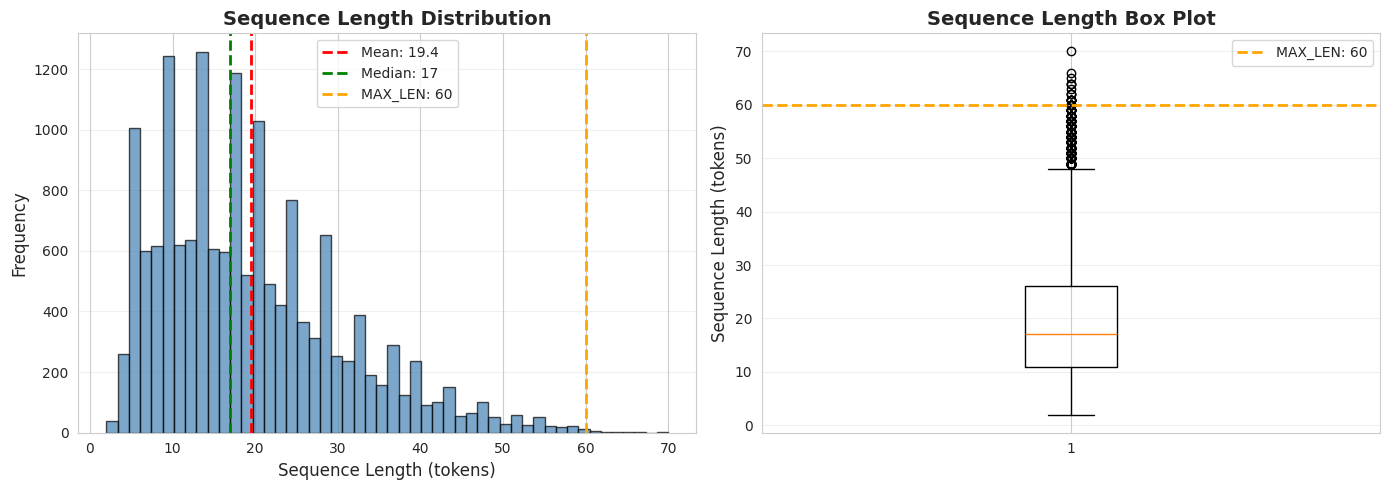


MAX_LEN JUSTIFICATION
50th percentile: 17 tokens
75th percentile: 26 tokens
90th percentile: 35 tokens
95th percentile: 41 tokens
99th percentile: 53 tokens

Chosen MAX_LEN: 60
This covers 99.9% of sequences
Sequences truncated: 16 (0.1%)

CONVERTING TEXTS TO SEQUENCES


2025-12-17 14:02:55,894 - INFO - Converted 15966 texts to sequences of length 60


2025-12-17 14:02:55,926 - INFO - Converted 1995 texts to sequences of length 60


2025-12-17 14:02:55,974 - INFO - Tokenizer saved to configs/tokenizer.json



Training sequences shape: (15966, 60)
Validation sequences shape: (1995, 60)

Training labels shape: (15966, 6)
Validation labels shape: (1995, 6)


In [15]:
# Initialize embedding handler
embedding_handler = AdvancedEmbeddingHandler(config)

# Extract texts
train_texts = train_df_clean['text'].values.tolist()
val_texts = val_df_clean['text'].values.tolist()

# Create tokenizer
print("="*80)
print("CREATING TOKENIZER")
print("="*80)
tokenizer = embedding_handler.create_tokenizer(train_texts)

# Analyze sequence lengths
print("\n" + "="*80)
print("SEQUENCE LENGTH ANALYSIS")
print("="*80)

seq_stats, seq_lengths = embedding_handler.analyze_sequence_lengths(train_texts)

# Plot sequence length distribution
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(seq_lengths, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(seq_stats['mean_length'], color='red', linestyle='--', 
           linewidth=2, label=f"Mean: {seq_stats['mean_length']:.1f}")
plt.axvline(seq_stats['median_length'], color='green', linestyle='--', 
           linewidth=2, label=f"Median: {seq_stats['median_length']:.0f}")
plt.axvline(config.max_len, color='orange', linestyle='--', 
           linewidth=2, label=f"MAX_LEN: {config.max_len}")
plt.title('Sequence Length Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sequence Length (tokens)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(seq_lengths, vert=True)
plt.axhline(config.max_len, color='orange', linestyle='--', 
           linewidth=2, label=f"MAX_LEN: {config.max_len}")
plt.title('Sequence Length Box Plot', fontsize=14, fontweight='bold')
plt.ylabel('Sequence Length (tokens)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Justify MAX_LEN choice
print("\n" + "="*80)
print("MAX_LEN JUSTIFICATION")
print("="*80)
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(seq_lengths, p)
    print(f"{p}th percentile: {val:.0f} tokens")

print(f"\nChosen MAX_LEN: {config.max_len}")
print(f"This covers {(sum(1 for l in seq_lengths if l <= config.max_len) / len(seq_lengths) * 100):.1f}% of sequences")
print(f"Sequences truncated: {seq_stats['truncated_count']} ({seq_stats['truncation_percent']:.1f}%)")
print("="*80)

# Convert to sequences
print("\n" + "="*80)
print("CONVERTING TEXTS TO SEQUENCES")
print("="*80)

X_train = embedding_handler.texts_to_sequences(train_texts)
X_val = embedding_handler.texts_to_sequences(val_texts)

print(f"\nTraining sequences shape: {X_train.shape}")
print(f"Validation sequences shape: {X_val.shape}")

# Prepare labels
y_train = train_df_clean['label'].values
y_val = val_df_clean['label'].values

# Convert to one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=config.num_classes)
y_val_cat = to_categorical(y_val, num_classes=config.num_classes)

print(f"\nTraining labels shape: {y_train_cat.shape}")
print(f"Validation labels shape: {y_val_cat.shape}")

# Save tokenizer if configured
if config.save_tokenizer:
    os.makedirs(config.config_dir, exist_ok=True)
    tokenizer_path = os.path.join(config.config_dir, 'tokenizer.json')
    embedding_handler.save_tokenizer(tokenizer_path)

##  Section 17: Build Model

---
#  MODEL BUILDING AND TRAINING

2025-12-17 14:02:55,986 - INFO - Loading GloVe embeddings from /home/lab/rabanof/Emotion_Detection_DL/glove/glove.6B.100d.txt...


LOADING GLOVE EMBEDDINGS


2025-12-17 14:03:03,123 - INFO - Loaded 400000 word vectors


2025-12-17 14:03:03,220 - INFO - Embedding Matrix Created:


2025-12-17 14:03:03,221 - INFO -   Shape: (15157, 100)


2025-12-17 14:03:03,222 - INFO -   Coverage: 14198/15156 (93.68%)


2025-12-17 14:03:03,222 - INFO -   OOV: 958 (6.32%)



CREATING EMBEDDING MATRIX

EMBEDDING COVERAGE ANALYSIS
Vocabulary size: 15156
Words with embeddings: 14198 (93.68%)
OOV words: 958 (6.32%)

First 20 OOV words:
   1. <UNK>
   2. href
   3. nofollow
   4. theyd
   5. pagetitle
   6. everyones
   7. permalink
   8. anyones
   9. everythings
  10. wifes
  11. maxs
  12. siwons
  13. thrifted
  14. societys
  15. hahaha
  16. ahaha
  17. embarrased
  18. moisturising
  19. amvassago
  20. adomen

OOV tokens in training sequences: 0.00%


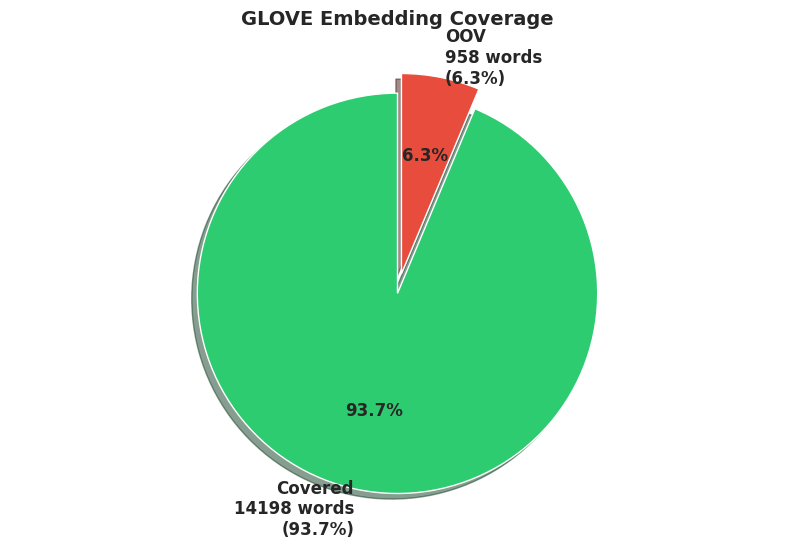

2025-12-17 14:03:03,441 - INFO - Embedding matrix saved to saved_models/embedding_matrix.npy



 Embedding matrix ready: (15157, 100)


In [16]:
# Load or train embeddings based on configuration
print("="*80)
print(f"LOADING {config.embedding_type.upper()} EMBEDDINGS")
print("="*80)

if config.embedding_type == 'glove':
    # Load GloVe embeddings
    embedding_handler.load_glove_embeddings(config.glove_path)
elif config.embedding_type == 'word2vec':
    # Train Word2Vec on our corpus
    embedding_handler.train_word2vec(train_texts, min_count=1)

# Create embedding matrix
print("\n" + "="*80)
print("CREATING EMBEDDING MATRIX")
print("="*80)

embedding_matrix = embedding_handler.create_embedding_matrix()

# Display embedding coverage statistics
print("\n" + "="*80)
print("EMBEDDING COVERAGE ANALYSIS")
print("="*80)
print(f"Vocabulary size: {embedding_handler.stats['vocab_size']}")
print(f"Words with embeddings: {embedding_handler.stats['coverage_count']} ({embedding_handler.stats['coverage_percent']:.2f}%)")
print(f"OOV words: {embedding_handler.stats['oov_count']} ({embedding_handler.stats['oov_percent']:.2f}%)")
print(f"\nFirst 20 OOV words:")
for i, word in enumerate(embedding_handler.stats['oov_words'][:20], 1):
    print(f"  {i:2d}. {word}")

# Calculate OOV rate in actual sequences
oov_rate = embedding_handler.get_oov_rate(X_train)
print(f"\nOOV tokens in training sequences: {oov_rate:.2f}%")
print("="*80)

# Visualize embedding coverage
vocab_size = embedding_handler.stats['vocab_size']
coverage_count = embedding_handler.stats['coverage_count']
oov_count = embedding_handler.stats['oov_count']

plt.figure(figsize=(10, 6))
colors = ['#2ecc71', '#e74c3c']
sizes = [coverage_count, oov_count]
labels = [f'Covered\n{coverage_count} words\n({embedding_handler.stats["coverage_percent"]:.1f}%)',
          f'OOV\n{oov_count} words\n({embedding_handler.stats["oov_percent"]:.1f}%)']
explode = (0.05, 0.05)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
plt.title(f'{config.embedding_type.upper()} Embedding Coverage', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.show()

# Save embedding matrix if configured
if config.save_embedding_matrix:
    os.makedirs(config.save_dir, exist_ok=True)
    embedding_path = os.path.join(config.save_dir, 'embedding_matrix.npy')
    embedding_handler.save_embedding_matrix(embedding_path)

print(f"\n Embedding matrix ready: {embedding_matrix.shape}")

##  Section 18: Train Model with Callbacks

In [17]:
# Initialize model builder
model_builder = AdvancedModelBuilder(config)

# Build model
print("="*80)
print("BUILDING MODEL")
print("="*80)

model = model_builder.build_model(embedding_matrix)

# Display model architecture
print("\n" + "="*80)
print("MODEL ARCHITECTURE")
print("="*80)
model.summary()

# Visualize model architecture (if possible)
try:
    from tensorflow.keras.utils import plot_model
    plot_path = os.path.join(config.save_dir, 'model_architecture.png')
    os.makedirs(config.save_dir, exist_ok=True)
    plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=True)
    print(f"\n Model architecture diagram saved to {plot_path}")
except:
    print("\n  Could not generate model diagram (requires graphviz)")

# Compute class weights
if config.use_class_weights:
    class_weights = preprocessor.compute_class_weights(y_train)
else:
    class_weights = None
    logger.info("Class weights disabled")

print("\n Model ready for training!")

2025-12-17 14:03:03,451 - INFO - Building LSTM model...


BUILDING MODEL


2025-12-17 14:03:03,773 - INFO - Model built successfully!


2025-12-17 14:03:03,774 - INFO -   Type: LSTM


2025-12-17 14:03:03,775 - INFO -   Units: 128, Layers: 1


2025-12-17 14:03:03,775 - INFO -   Trainable embeddings: False


2025-12-17 14:03:03,776 - INFO -   Total parameters: 1,633,722



MODEL ARCHITECTURE
Model: "lstm_model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input (InputLayer)          [(None, 60)]              0         


 embedding (Embedding)       (None, 60, 100)           1515700   


 spatial_dropout (SpatialDr  (None, 60, 100)           0         


 opout1D)                                                        


 lstm_1 (LSTM)               (None, 128)               117248    


 output (Dense)              (None, 6)                 774       


Total params: 1633722 (6.23 MB)


Trainable params: 118022 (461.02 KB)


Non-trainable params: 1515700 (5.78 MB)


_________________________________________________________________


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2025-12-17 14:03:03,792 - INFO - Class weights computed: {0: 0.5707850707850708, 1: 0.4974761637689288, 2: 2.048498845265589, 3: 1.2348027842227378, 4: 1.3766166580444905, 5: 4.684859154929577}



 Model architecture diagram saved to saved_models/model_architecture.png

 Model ready for training!


##  Section 19: Visualize Training History

In [18]:
# Prepare directories
os.makedirs(config.save_dir, exist_ok=True)
os.makedirs(config.log_dir, exist_ok=True)
os.makedirs(config.result_dir, exist_ok=True)

# Setup callbacks
callbacks = []

# Experiment tracker
experiment_tracker = ExperimentTracker(config)
callbacks.append(experiment_tracker)

# Model checkpoint
checkpoint_path = os.path.join(config.save_dir, f'{config.experiment_name}_best_model.h5')
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
callbacks.append(checkpoint)

# Early stopping
if config.early_stopping:
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=config.patience,
        restore_best_weights=True,
        verbose=1
    )
    callbacks.append(early_stop)

# Reduce LR on plateau
if config.reduce_lr:
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=config.lr_factor,
        patience=config.lr_patience,
        min_lr=config.min_lr,
        verbose=1
    )
    callbacks.append(reduce_lr)

# TensorBoard
tensorboard_dir = os.path.join(config.log_dir, config.experiment_name)
tensorboard = TensorBoard(log_dir=tensorboard_dir, histogram_freq=1)
callbacks.append(tensorboard)

# CSV Logger
csv_path = os.path.join(config.log_dir, f'{config.experiment_name}_training.csv')
csv_logger = CSVLogger(csv_path)
callbacks.append(csv_logger)

print("="*80)
print("TRAINING MODEL")
print("="*80)
print(f"Experiment: {config.experiment_name}")
print(f"Model: {config.model_type.upper()}")
print(f"Epochs: {config.epochs}")
print(f"Batch Size: {config.batch_size}")
print(f"Learning Rate: {config.learning_rate}")
print(f"Class Weights: {'Enabled' if config.use_class_weights else 'Disabled'}")
print(f"Early Stopping: {'Enabled (patience={})'.format(config.patience) if config.early_stopping else 'Disabled'}")
print("="*80)

# Train model
start_time = time.time()

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=config.epochs,
    batch_size=config.batch_size,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=config.verbose
)

training_time = time.time() - start_time

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)
print(f"Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Best val accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best val loss: {min(history.history['val_loss']):.4f}")
print(f"Model saved to: {checkpoint_path}")
print("="*80)

TRAINING MODEL
Experiment: ultimate_emotion_detection
Model: LSTM
Epochs: 50
Batch Size: 32
Learning Rate: 0.001
Class Weights: Enabled
Early Stopping: Enabled (patience=5)
Epoch 1/50


  1/499 [..............................] - ETA: 13:52 - loss: 2.3873 - accuracy: 0.1562

  3/499 [..............................] - ETA: 17s - loss: 2.0069 - accuracy: 0.1146  

  5/499 [..............................] - ETA: 17s - loss: 1.9791 - accuracy: 0.1125

  7/499 [..............................] - ETA: 16s - loss: 1.9344 - accuracy: 0.1161

  9/499 [..............................] - ETA: 16s - loss: 1.9344 - accuracy: 0.1111

 11/499 [..............................] - ETA: 16s - loss: 1.8854 - accuracy: 0.0994

 13/499 [..............................] - ETA: 15s - loss: 1.8834 - accuracy: 0.0986

 15/499 [..............................] - ETA: 15s - loss: 1.8866 - accuracy: 0.1000

 17/499 [>.............................] - ETA: 15s - loss: 1.8906 - accuracy: 0.0974

 19/499 [>.............................] - ETA: 15s - loss: 1.8828 - accuracy: 0.0954

 21/499 [>.............................] - ETA: 15s - loss: 1.8577 - accuracy: 0.0982

 23/499 [>.............................] - ETA: 15s - loss: 1.8519 - accuracy: 0.1033

 25/499 [>.............................] - ETA: 15s - loss: 1.8368 - accuracy: 0.1025

 27/499 [>.............................] - ETA: 15s - loss: 1.8470 - accuracy: 0.1053

 29/499 [>.............................] - ETA: 15s - loss: 1.8178 - accuracy: 0.0991

 31/499 [>.............................] - ETA: 15s - loss: 1.8142 - accuracy: 0.0978

 33/499 [>.............................] - ETA: 14s - loss: 1.8150 - accuracy: 0.0975

 35/499 [=>............................] - ETA: 14s - loss: 1.8013 - accuracy: 0.0964

 37/499 [=>............................] - ETA: 14s - loss: 1.7971 - accuracy: 0.0971

 39/499 [=>............................] - ETA: 14s - loss: 1.8066 - accuracy: 0.0962

 41/499 [=>............................] - ETA: 14s - loss: 1.7972 - accuracy: 0.0953

 43/499 [=>............................] - ETA: 14s - loss: 1.7993 - accuracy: 0.0952

 45/499 [=>............................] - ETA: 14s - loss: 1.7980 - accuracy: 0.0958

 47/499 [=>............................] - ETA: 14s - loss: 1.7833 - accuracy: 0.0951

 49/499 [=>............................] - ETA: 14s - loss: 1.7715 - accuracy: 0.0931

 51/499 [==>...........................] - ETA: 14s - loss: 1.7705 - accuracy: 0.0919

 53/499 [==>...........................] - ETA: 14s - loss: 1.7653 - accuracy: 0.0914

 55/499 [==>...........................] - ETA: 14s - loss: 1.7677 - accuracy: 0.0932

 57/499 [==>...........................] - ETA: 14s - loss: 1.7572 - accuracy: 0.0921

 59/499 [==>...........................] - ETA: 14s - loss: 1.7583 - accuracy: 0.0916

 61/499 [==>...........................] - ETA: 13s - loss: 1.7495 - accuracy: 0.0912

 63/499 [==>...........................] - ETA: 13s - loss: 1.7488 - accuracy: 0.0928

 65/499 [==>...........................] - ETA: 13s - loss: 1.7477 - accuracy: 0.0938

 67/499 [===>..........................] - ETA: 13s - loss: 1.7500 - accuracy: 0.0938

 69/499 [===>..........................] - ETA: 13s - loss: 1.7546 - accuracy: 0.0933

 71/499 [===>..........................] - ETA: 13s - loss: 1.7524 - accuracy: 0.0933

 73/499 [===>..........................] - ETA: 13s - loss: 1.7721 - accuracy: 0.0946

 75/499 [===>..........................] - ETA: 13s - loss: 1.7694 - accuracy: 0.0946

 77/499 [===>..........................] - ETA: 13s - loss: 1.7763 - accuracy: 0.0938

 79/499 [===>..........................] - ETA: 13s - loss: 1.7700 - accuracy: 0.0930

 81/499 [===>..........................] - ETA: 13s - loss: 1.7697 - accuracy: 0.0930

 83/499 [===>..........................] - ETA: 13s - loss: 1.7735 - accuracy: 0.0934

 85/499 [====>.........................] - ETA: 13s - loss: 1.7652 - accuracy: 0.0930

 87/499 [====>.........................] - ETA: 13s - loss: 1.7704 - accuracy: 0.0920

 89/499 [====>.........................] - ETA: 13s - loss: 1.7747 - accuracy: 0.0941

 91/499 [====>.........................] - ETA: 12s - loss: 1.7715 - accuracy: 0.0996

 93/499 [====>.........................] - ETA: 12s - loss: 1.7664 - accuracy: 0.1032

 95/499 [====>.........................] - ETA: 12s - loss: 1.7649 - accuracy: 0.1059

 97/499 [====>.........................] - ETA: 12s - loss: 1.7584 - accuracy: 0.1108

 99/499 [====>.........................] - ETA: 12s - loss: 1.7566 - accuracy: 0.1136

101/499 [=====>........................] - ETA: 12s - loss: 1.7564 - accuracy: 0.1170

103/499 [=====>........................] - ETA: 12s - loss: 1.7541 - accuracy: 0.1217

105/499 [=====>........................] - ETA: 12s - loss: 1.7603 - accuracy: 0.1253

107/499 [=====>........................] - ETA: 12s - loss: 1.7604 - accuracy: 0.1282

109/499 [=====>........................] - ETA: 12s - loss: 1.7579 - accuracy: 0.1322

111/499 [=====>........................] - ETA: 12s - loss: 1.7727 - accuracy: 0.1351

113/499 [=====>........................] - ETA: 12s - loss: 1.7797 - accuracy: 0.1374

115/499 [=====>........................] - ETA: 12s - loss: 1.7814 - accuracy: 0.1405

117/499 [======>.......................] - ETA: 12s - loss: 1.7812 - accuracy: 0.1424

119/499 [======>.......................] - ETA: 12s - loss: 1.7759 - accuracy: 0.1471

121/499 [======>.......................] - ETA: 11s - loss: 1.7748 - accuracy: 0.1482

123/499 [======>.......................] - ETA: 11s - loss: 1.7797 - accuracy: 0.1504

125/499 [======>.......................] - ETA: 11s - loss: 1.7857 - accuracy: 0.1515

127/499 [======>.......................] - ETA: 11s - loss: 1.7922 - accuracy: 0.1526

129/499 [======>.......................] - ETA: 11s - loss: 1.7954 - accuracy: 0.1550

131/499 [======>.......................] - ETA: 11s - loss: 1.7930 - accuracy: 0.1558

133/499 [======>.......................] - ETA: 11s - loss: 1.7938 - accuracy: 0.1546

135/499 [=======>......................] - ETA: 11s - loss: 1.7957 - accuracy: 0.1532

137/499 [=======>......................] - ETA: 11s - loss: 1.7945 - accuracy: 0.1524

139/499 [=======>......................] - ETA: 11s - loss: 1.7930 - accuracy: 0.1509

141/499 [=======>......................] - ETA: 11s - loss: 1.7967 - accuracy: 0.1494

143/499 [=======>......................] - ETA: 11s - loss: 1.7956 - accuracy: 0.1484

145/499 [=======>......................] - ETA: 11s - loss: 1.7891 - accuracy: 0.1466

147/499 [=======>......................] - ETA: 11s - loss: 1.7892 - accuracy: 0.1460

149/499 [=======>......................] - ETA: 11s - loss: 1.7869 - accuracy: 0.1456

151/499 [========>.....................] - ETA: 11s - loss: 1.7853 - accuracy: 0.1442

153/499 [========>.....................] - ETA: 10s - loss: 1.7887 - accuracy: 0.1438

155/499 [========>.....................] - ETA: 10s - loss: 1.7896 - accuracy: 0.1446

157/499 [========>.....................] - ETA: 10s - loss: 1.7878 - accuracy: 0.1437

159/499 [========>.....................] - ETA: 10s - loss: 1.7843 - accuracy: 0.1431

161/499 [========>.....................] - ETA: 10s - loss: 1.7851 - accuracy: 0.1432

163/499 [========>.....................] - ETA: 10s - loss: 1.7823 - accuracy: 0.1428

165/499 [========>.....................] - ETA: 10s - loss: 1.7817 - accuracy: 0.1422

167/499 [=========>....................] - ETA: 10s - loss: 1.7799 - accuracy: 0.1417

169/499 [=========>....................] - ETA: 10s - loss: 1.7793 - accuracy: 0.1415

171/499 [=========>....................] - ETA: 10s - loss: 1.7831 - accuracy: 0.1409

173/499 [=========>....................] - ETA: 10s - loss: 1.7823 - accuracy: 0.1407

175/499 [=========>....................] - ETA: 10s - loss: 1.7797 - accuracy: 0.1398

177/499 [=========>....................] - ETA: 10s - loss: 1.7800 - accuracy: 0.1395

179/499 [=========>....................] - ETA: 10s - loss: 1.7799 - accuracy: 0.1383

181/499 [=========>....................] - ETA: 10s - loss: 1.7811 - accuracy: 0.1385

183/499 [==========>...................] - ETA: 9s - loss: 1.7832 - accuracy: 0.1378 

185/499 [==========>...................] - ETA: 9s - loss: 1.7822 - accuracy: 0.1370

187/499 [==========>...................] - ETA: 9s - loss: 1.7816 - accuracy: 0.1369

189/499 [==========>...................] - ETA: 9s - loss: 1.7812 - accuracy: 0.1361

191/499 [==========>...................] - ETA: 9s - loss: 1.7811 - accuracy: 0.1356

193/499 [==========>...................] - ETA: 9s - loss: 1.7810 - accuracy: 0.1350

195/499 [==========>...................] - ETA: 9s - loss: 1.7828 - accuracy: 0.1351

197/499 [==========>...................] - ETA: 9s - loss: 1.7830 - accuracy: 0.1339

199/499 [==========>...................] - ETA: 9s - loss: 1.7820 - accuracy: 0.1338

201/499 [===========>..................] - ETA: 9s - loss: 1.7847 - accuracy: 0.1336

203/499 [===========>..................] - ETA: 9s - loss: 1.7838 - accuracy: 0.1329

205/499 [===========>..................] - ETA: 9s - loss: 1.7858 - accuracy: 0.1323

207/499 [===========>..................] - ETA: 9s - loss: 1.7836 - accuracy: 0.1319

209/499 [===========>..................] - ETA: 9s - loss: 1.7828 - accuracy: 0.1313

211/499 [===========>..................] - ETA: 9s - loss: 1.7822 - accuracy: 0.1303

213/499 [===========>..................] - ETA: 9s - loss: 1.7838 - accuracy: 0.1297

215/499 [===========>..................] - ETA: 8s - loss: 1.7871 - accuracy: 0.1298

217/499 [============>.................] - ETA: 8s - loss: 1.7864 - accuracy: 0.1293

219/499 [============>.................] - ETA: 8s - loss: 1.7868 - accuracy: 0.1289

221/499 [============>.................] - ETA: 8s - loss: 1.7837 - accuracy: 0.1280

223/499 [============>.................] - ETA: 8s - loss: 1.7832 - accuracy: 0.1279

225/499 [============>.................] - ETA: 8s - loss: 1.7809 - accuracy: 0.1269

227/499 [============>.................] - ETA: 8s - loss: 1.7784 - accuracy: 0.1261

229/499 [============>.................] - ETA: 8s - loss: 1.7785 - accuracy: 0.1257

231/499 [============>.................] - ETA: 8s - loss: 1.7812 - accuracy: 0.1257

233/499 [=============>................] - ETA: 8s - loss: 1.7820 - accuracy: 0.1254

235/499 [=============>................] - ETA: 8s - loss: 1.7796 - accuracy: 0.1247

237/499 [=============>................] - ETA: 8s - loss: 1.7817 - accuracy: 0.1241

239/499 [=============>................] - ETA: 8s - loss: 1.7828 - accuracy: 0.1242

241/499 [=============>................] - ETA: 8s - loss: 1.7808 - accuracy: 0.1242

244/499 [=============>................] - ETA: 7s - loss: 1.7792 - accuracy: 0.1237

246/499 [=============>................] - ETA: 7s - loss: 1.7809 - accuracy: 0.1240

248/499 [=============>................] - ETA: 7s - loss: 1.7800 - accuracy: 0.1234

250/499 [==============>...............] - ETA: 7s - loss: 1.7801 - accuracy: 0.1231

252/499 [==============>...............] - ETA: 7s - loss: 1.7808 - accuracy: 0.1228

254/499 [==============>...............] - ETA: 7s - loss: 1.7784 - accuracy: 0.1232

256/499 [==============>...............] - ETA: 7s - loss: 1.7800 - accuracy: 0.1230

258/499 [==============>...............] - ETA: 7s - loss: 1.7771 - accuracy: 0.1229

260/499 [==============>...............] - ETA: 7s - loss: 1.7768 - accuracy: 0.1230

262/499 [==============>...............] - ETA: 7s - loss: 1.7766 - accuracy: 0.1229

264/499 [==============>...............] - ETA: 7s - loss: 1.7762 - accuracy: 0.1225

266/499 [==============>...............] - ETA: 7s - loss: 1.7796 - accuracy: 0.1234

268/499 [===============>..............] - ETA: 7s - loss: 1.7805 - accuracy: 0.1243

270/499 [===============>..............] - ETA: 7s - loss: 1.7832 - accuracy: 0.1250

272/499 [===============>..............] - ETA: 7s - loss: 1.7865 - accuracy: 0.1252

274/499 [===============>..............] - ETA: 6s - loss: 1.7889 - accuracy: 0.1258

276/499 [===============>..............] - ETA: 6s - loss: 1.7896 - accuracy: 0.1266

278/499 [===============>..............] - ETA: 6s - loss: 1.7875 - accuracy: 0.1277

280/499 [===============>..............] - ETA: 6s - loss: 1.7897 - accuracy: 0.1292

282/499 [===============>..............] - ETA: 6s - loss: 1.7904 - accuracy: 0.1292

284/499 [================>.............] - ETA: 6s - loss: 1.7909 - accuracy: 0.1287

286/499 [================>.............] - ETA: 6s - loss: 1.7888 - accuracy: 0.1287

288/499 [================>.............] - ETA: 6s - loss: 1.7904 - accuracy: 0.1288

290/499 [================>.............] - ETA: 6s - loss: 1.7907 - accuracy: 0.1289

292/499 [================>.............] - ETA: 6s - loss: 1.7900 - accuracy: 0.1287

294/499 [================>.............] - ETA: 6s - loss: 1.7881 - accuracy: 0.1285

296/499 [================>.............] - ETA: 6s - loss: 1.7871 - accuracy: 0.1280

298/499 [================>.............] - ETA: 6s - loss: 1.7858 - accuracy: 0.1275

300/499 [=================>............] - ETA: 6s - loss: 1.7859 - accuracy: 0.1271

302/499 [=================>............] - ETA: 6s - loss: 1.7854 - accuracy: 0.1275

304/499 [=================>............] - ETA: 6s - loss: 1.7840 - accuracy: 0.1277

306/499 [=================>............] - ETA: 5s - loss: 1.7819 - accuracy: 0.1277

308/499 [=================>............] - ETA: 5s - loss: 1.7808 - accuracy: 0.1277

310/499 [=================>............] - ETA: 5s - loss: 1.7841 - accuracy: 0.1281

312/499 [=================>............] - ETA: 5s - loss: 1.7842 - accuracy: 0.1279

314/499 [=================>............] - ETA: 5s - loss: 1.7835 - accuracy: 0.1285

316/499 [=================>............] - ETA: 5s - loss: 1.7839 - accuracy: 0.1286

318/499 [==================>...........] - ETA: 5s - loss: 1.7836 - accuracy: 0.1285

320/499 [==================>...........] - ETA: 5s - loss: 1.7823 - accuracy: 0.1283

322/499 [==================>...........] - ETA: 5s - loss: 1.7813 - accuracy: 0.1286

324/499 [==================>...........] - ETA: 5s - loss: 1.7819 - accuracy: 0.1287

326/499 [==================>...........] - ETA: 5s - loss: 1.7811 - accuracy: 0.1287

328/499 [==================>...........] - ETA: 5s - loss: 1.7813 - accuracy: 0.1291

330/499 [==================>...........] - ETA: 5s - loss: 1.7797 - accuracy: 0.1295

332/499 [==================>...........] - ETA: 5s - loss: 1.7807 - accuracy: 0.1296

334/499 [===================>..........] - ETA: 5s - loss: 1.7803 - accuracy: 0.1300

336/499 [===================>..........] - ETA: 5s - loss: 1.7794 - accuracy: 0.1302

338/499 [===================>..........] - ETA: 4s - loss: 1.7818 - accuracy: 0.1303

340/499 [===================>..........] - ETA: 4s - loss: 1.7807 - accuracy: 0.1300

342/499 [===================>..........] - ETA: 4s - loss: 1.7806 - accuracy: 0.1298

344/499 [===================>..........] - ETA: 4s - loss: 1.7803 - accuracy: 0.1295

346/499 [===================>..........] - ETA: 4s - loss: 1.7834 - accuracy: 0.1295

348/499 [===================>..........] - ETA: 4s - loss: 1.7842 - accuracy: 0.1300

350/499 [====================>.........] - ETA: 4s - loss: 1.7838 - accuracy: 0.1302

352/499 [====================>.........] - ETA: 4s - loss: 1.7830 - accuracy: 0.1307

354/499 [====================>.........] - ETA: 4s - loss: 1.7845 - accuracy: 0.1309

356/499 [====================>.........] - ETA: 4s - loss: 1.7874 - accuracy: 0.1311

359/499 [====================>.........] - ETA: 4s - loss: 1.7877 - accuracy: 0.1310

361/499 [====================>.........] - ETA: 4s - loss: 1.7869 - accuracy: 0.1307

363/499 [====================>.........] - ETA: 4s - loss: 1.7869 - accuracy: 0.1308

365/499 [====================>.........] - ETA: 4s - loss: 1.7859 - accuracy: 0.1310

367/499 [=====================>........] - ETA: 4s - loss: 1.7865 - accuracy: 0.1311

369/499 [=====================>........] - ETA: 4s - loss: 1.7875 - accuracy: 0.1315

371/499 [=====================>........] - ETA: 3s - loss: 1.7880 - accuracy: 0.1317

373/499 [=====================>........] - ETA: 3s - loss: 1.7875 - accuracy: 0.1315

375/499 [=====================>........] - ETA: 3s - loss: 1.7866 - accuracy: 0.1312

378/499 [=====================>........] - ETA: 3s - loss: 1.7888 - accuracy: 0.1314

380/499 [=====================>........] - ETA: 3s - loss: 1.7908 - accuracy: 0.1311

382/499 [=====================>........] - ETA: 3s - loss: 1.7901 - accuracy: 0.1306

384/499 [======================>.......] - ETA: 3s - loss: 1.7901 - accuracy: 0.1302

386/499 [======================>.......] - ETA: 3s - loss: 1.7922 - accuracy: 0.1299

388/499 [======================>.......] - ETA: 3s - loss: 1.7925 - accuracy: 0.1295

390/499 [======================>.......] - ETA: 3s - loss: 1.7932 - accuracy: 0.1292

392/499 [======================>.......] - ETA: 3s - loss: 1.7945 - accuracy: 0.1287

394/499 [======================>.......] - ETA: 3s - loss: 1.7949 - accuracy: 0.1283

396/499 [======================>.......] - ETA: 3s - loss: 1.7951 - accuracy: 0.1278

398/499 [======================>.......] - ETA: 3s - loss: 1.7953 - accuracy: 0.1274

400/499 [=======================>......] - ETA: 3s - loss: 1.7953 - accuracy: 0.1270

402/499 [=======================>......] - ETA: 3s - loss: 1.7957 - accuracy: 0.1267

404/499 [=======================>......] - ETA: 2s - loss: 1.7960 - accuracy: 0.1263

406/499 [=======================>......] - ETA: 2s - loss: 1.7964 - accuracy: 0.1260

408/499 [=======================>......] - ETA: 2s - loss: 1.7959 - accuracy: 0.1254

410/499 [=======================>......] - ETA: 2s - loss: 1.7949 - accuracy: 0.1248

412/499 [=======================>......] - ETA: 2s - loss: 1.7945 - accuracy: 0.1242

414/499 [=======================>......] - ETA: 2s - loss: 1.7958 - accuracy: 0.1239

416/499 [========================>.....] - ETA: 2s - loss: 1.7954 - accuracy: 0.1236

418/499 [========================>.....] - ETA: 2s - loss: 1.7944 - accuracy: 0.1239

420/499 [========================>.....] - ETA: 2s - loss: 1.7955 - accuracy: 0.1239

422/499 [========================>.....] - ETA: 2s - loss: 1.7947 - accuracy: 0.1237

424/499 [========================>.....] - ETA: 2s - loss: 1.7959 - accuracy: 0.1243

426/499 [========================>.....] - ETA: 2s - loss: 1.7942 - accuracy: 0.1240

428/499 [========================>.....] - ETA: 2s - loss: 1.7943 - accuracy: 0.1236

430/499 [========================>.....] - ETA: 2s - loss: 1.7928 - accuracy: 0.1238

432/499 [========================>.....] - ETA: 2s - loss: 1.7929 - accuracy: 0.1236

434/499 [=========================>....] - ETA: 2s - loss: 1.7930 - accuracy: 0.1236

436/499 [=========================>....] - ETA: 1s - loss: 1.7925 - accuracy: 0.1236

438/499 [=========================>....] - ETA: 1s - loss: 1.7922 - accuracy: 0.1234

440/499 [=========================>....] - ETA: 1s - loss: 1.7918 - accuracy: 0.1231

442/499 [=========================>....] - ETA: 1s - loss: 1.7927 - accuracy: 0.1229

444/499 [=========================>....] - ETA: 1s - loss: 1.7929 - accuracy: 0.1230

446/499 [=========================>....] - ETA: 1s - loss: 1.7943 - accuracy: 0.1229

448/499 [=========================>....] - ETA: 1s - loss: 1.7944 - accuracy: 0.1228

450/499 [==========================>...] - ETA: 1s - loss: 1.7952 - accuracy: 0.1228

452/499 [==========================>...] - ETA: 1s - loss: 1.7945 - accuracy: 0.1226

454/499 [==========================>...] - ETA: 1s - loss: 1.7949 - accuracy: 0.1224

456/499 [==========================>...] - ETA: 1s - loss: 1.7939 - accuracy: 0.1221

458/499 [==========================>...] - ETA: 1s - loss: 1.7929 - accuracy: 0.1217

460/499 [==========================>...] - ETA: 1s - loss: 1.7930 - accuracy: 0.1216

462/499 [==========================>...] - ETA: 1s - loss: 1.7915 - accuracy: 0.1212

464/499 [==========================>...] - ETA: 1s - loss: 1.7915 - accuracy: 0.1210

466/499 [===========================>..] - ETA: 1s - loss: 1.7933 - accuracy: 0.1210

468/499 [===========================>..] - ETA: 0s - loss: 1.7933 - accuracy: 0.1211

470/499 [===========================>..] - ETA: 0s - loss: 1.7933 - accuracy: 0.1210

472/499 [===========================>..] - ETA: 0s - loss: 1.7921 - accuracy: 0.1209

474/499 [===========================>..] - ETA: 0s - loss: 1.7916 - accuracy: 0.1206

476/499 [===========================>..] - ETA: 0s - loss: 1.7918 - accuracy: 0.1209

478/499 [===========================>..] - ETA: 0s - loss: 1.7912 - accuracy: 0.1208

480/499 [===========================>..] - ETA: 0s - loss: 1.7924 - accuracy: 0.1208

482/499 [===========================>..] - ETA: 0s - loss: 1.7920 - accuracy: 0.1208

484/499 [============================>.] - ETA: 0s - loss: 1.7926 - accuracy: 0.1216

486/499 [============================>.] - ETA: 0s - loss: 1.7927 - accuracy: 0.1225

488/499 [============================>.] - ETA: 0s - loss: 1.7927 - accuracy: 0.1231

490/499 [============================>.] - ETA: 0s - loss: 1.7922 - accuracy: 0.1240

492/499 [============================>.] - ETA: 0s - loss: 1.7927 - accuracy: 0.1252

494/499 [============================>.] - ETA: 0s - loss: 1.7919 - accuracy: 0.1264

496/499 [============================>.] - ETA: 0s - loss: 1.7933 - accuracy: 0.1274

498/499 [============================>.] - ETA: 0s - loss: 1.7936 - accuracy: 0.1281

2025-12-17 14:03:22,608 - INFO - Epoch 1 completed in 18.68s - val_acc: 0.3489



Epoch 1: val_accuracy improved from -inf to 0.34887, saving model to saved_models/ultimate_emotion_detection_best_model.h5


499/499 [==============================] - 19s 35ms/step - loss: 1.7935 - accuracy: 0.1284 - val_loss: 1.7878 - val_accuracy: 0.3489 - lr: 0.0010


Epoch 2/50


  1/499 [..............................] - ETA: 15s - loss: 2.0568 - accuracy: 0.3438

  3/499 [..............................] - ETA: 16s - loss: 2.0701 - accuracy: 0.2083

  5/499 [..............................] - ETA: 16s - loss: 2.1047 - accuracy: 0.1562

  7/499 [..............................] - ETA: 16s - loss: 1.9135 - accuracy: 0.1205

  9/499 [..............................] - ETA: 15s - loss: 1.8873 - accuracy: 0.1042

 11/499 [..............................] - ETA: 15s - loss: 1.8854 - accuracy: 0.0881

 13/499 [..............................] - ETA: 15s - loss: 1.8877 - accuracy: 0.0817

 15/499 [..............................] - ETA: 15s - loss: 1.8925 - accuracy: 0.0771

 17/499 [>.............................] - ETA: 15s - loss: 1.9183 - accuracy: 0.0754

 19/499 [>.............................] - ETA: 15s - loss: 1.9132 - accuracy: 0.0707

 21/499 [>.............................] - ETA: 15s - loss: 1.8915 - accuracy: 0.0655

 23/499 [>.............................] - ETA: 15s - loss: 1.8877 - accuracy: 0.0639

 25/499 [>.............................] - ETA: 15s - loss: 1.8876 - accuracy: 0.0637

 27/499 [>.............................] - ETA: 14s - loss: 1.8596 - accuracy: 0.0590

 29/499 [>.............................] - ETA: 14s - loss: 1.8630 - accuracy: 0.0603

 31/499 [>.............................] - ETA: 14s - loss: 1.8693 - accuracy: 0.0585

 33/499 [>.............................] - ETA: 14s - loss: 1.8562 - accuracy: 0.0549

 35/499 [=>............................] - ETA: 14s - loss: 1.8440 - accuracy: 0.0536

 37/499 [=>............................] - ETA: 14s - loss: 1.8380 - accuracy: 0.0532

 39/499 [=>............................] - ETA: 14s - loss: 1.8324 - accuracy: 0.0521

 41/499 [=>............................] - ETA: 14s - loss: 1.8358 - accuracy: 0.0511

 43/499 [=>............................] - ETA: 14s - loss: 1.8316 - accuracy: 0.0509

 45/499 [=>............................] - ETA: 14s - loss: 1.8303 - accuracy: 0.0507

 47/499 [=>............................] - ETA: 14s - loss: 1.8282 - accuracy: 0.0499

 49/499 [=>............................] - ETA: 14s - loss: 1.8260 - accuracy: 0.0485

 51/499 [==>...........................] - ETA: 14s - loss: 1.8312 - accuracy: 0.0502

 53/499 [==>...........................] - ETA: 14s - loss: 1.8329 - accuracy: 0.0507

 55/499 [==>...........................] - ETA: 14s - loss: 1.8300 - accuracy: 0.0506

 57/499 [==>...........................] - ETA: 14s - loss: 1.8294 - accuracy: 0.0510

 59/499 [==>...........................] - ETA: 14s - loss: 1.8376 - accuracy: 0.0514

 61/499 [==>...........................] - ETA: 13s - loss: 1.8403 - accuracy: 0.0512

 63/499 [==>...........................] - ETA: 13s - loss: 1.8367 - accuracy: 0.0511

 65/499 [==>...........................] - ETA: 13s - loss: 1.8435 - accuracy: 0.0510

 67/499 [===>..........................] - ETA: 13s - loss: 1.8363 - accuracy: 0.0499

 69/499 [===>..........................] - ETA: 13s - loss: 1.8303 - accuracy: 0.0494

 71/499 [===>..........................] - ETA: 13s - loss: 1.8280 - accuracy: 0.0489

 73/499 [===>..........................] - ETA: 13s - loss: 1.8189 - accuracy: 0.0475

 75/499 [===>..........................] - ETA: 13s - loss: 1.8154 - accuracy: 0.0467

 77/499 [===>..........................] - ETA: 13s - loss: 1.8132 - accuracy: 0.0463

 79/499 [===>..........................] - ETA: 13s - loss: 1.8174 - accuracy: 0.0459

 81/499 [===>..........................] - ETA: 13s - loss: 1.8209 - accuracy: 0.0463

 83/499 [===>..........................] - ETA: 13s - loss: 1.8184 - accuracy: 0.0459

 85/499 [====>.........................] - ETA: 13s - loss: 1.8167 - accuracy: 0.0452

 87/499 [====>.........................] - ETA: 12s - loss: 1.8085 - accuracy: 0.0442

 89/499 [====>.........................] - ETA: 12s - loss: 1.8039 - accuracy: 0.0439

 91/499 [====>.........................] - ETA: 12s - loss: 1.8028 - accuracy: 0.0457

 93/499 [====>.........................] - ETA: 12s - loss: 1.7994 - accuracy: 0.0467

 95/499 [====>.........................] - ETA: 12s - loss: 1.7969 - accuracy: 0.0474

 97/499 [====>.........................] - ETA: 12s - loss: 1.7932 - accuracy: 0.0486

 99/499 [====>.........................] - ETA: 12s - loss: 1.7978 - accuracy: 0.0489

101/499 [=====>........................] - ETA: 12s - loss: 1.7942 - accuracy: 0.0511

103/499 [=====>........................] - ETA: 12s - loss: 1.7930 - accuracy: 0.0537

105/499 [=====>........................] - ETA: 12s - loss: 1.7952 - accuracy: 0.0554

107/499 [=====>........................] - ETA: 12s - loss: 1.7910 - accuracy: 0.0564

109/499 [=====>........................] - ETA: 12s - loss: 1.7941 - accuracy: 0.0573

111/499 [=====>........................] - ETA: 12s - loss: 1.7925 - accuracy: 0.0594

113/499 [=====>........................] - ETA: 12s - loss: 1.7927 - accuracy: 0.0600

115/499 [=====>........................] - ETA: 11s - loss: 1.7888 - accuracy: 0.0609

117/499 [======>.......................] - ETA: 11s - loss: 1.7897 - accuracy: 0.0622

119/499 [======>.......................] - ETA: 11s - loss: 1.7924 - accuracy: 0.0636

121/499 [======>.......................] - ETA: 11s - loss: 1.7911 - accuracy: 0.0643

123/499 [======>.......................] - ETA: 11s - loss: 1.7878 - accuracy: 0.0653

125/499 [======>.......................] - ETA: 11s - loss: 1.7894 - accuracy: 0.0670

127/499 [======>.......................] - ETA: 11s - loss: 1.7871 - accuracy: 0.0689

129/499 [======>.......................] - ETA: 11s - loss: 1.7907 - accuracy: 0.0700

131/499 [======>.......................] - ETA: 11s - loss: 1.7897 - accuracy: 0.0711

133/499 [======>.......................] - ETA: 11s - loss: 1.7846 - accuracy: 0.0721

135/499 [=======>......................] - ETA: 11s - loss: 1.7867 - accuracy: 0.0736

137/499 [=======>......................] - ETA: 11s - loss: 1.7847 - accuracy: 0.0746

139/499 [=======>......................] - ETA: 11s - loss: 1.7875 - accuracy: 0.0755

141/499 [=======>......................] - ETA: 11s - loss: 1.7893 - accuracy: 0.0771

143/499 [=======>......................] - ETA: 11s - loss: 1.7894 - accuracy: 0.0778

145/499 [=======>......................] - ETA: 11s - loss: 1.7889 - accuracy: 0.0780

147/499 [=======>......................] - ETA: 11s - loss: 1.7881 - accuracy: 0.0789

149/499 [=======>......................] - ETA: 10s - loss: 1.7874 - accuracy: 0.0799

151/499 [========>.....................] - ETA: 10s - loss: 1.7879 - accuracy: 0.0811

153/499 [========>.....................] - ETA: 10s - loss: 1.7932 - accuracy: 0.0827

155/499 [========>.....................] - ETA: 10s - loss: 1.7957 - accuracy: 0.0839

157/499 [========>.....................] - ETA: 10s - loss: 1.7978 - accuracy: 0.0848

159/499 [========>.....................] - ETA: 10s - loss: 1.8010 - accuracy: 0.0855

161/499 [========>.....................] - ETA: 10s - loss: 1.8032 - accuracy: 0.0862

163/499 [========>.....................] - ETA: 10s - loss: 1.8055 - accuracy: 0.0876

165/499 [========>.....................] - ETA: 10s - loss: 1.8125 - accuracy: 0.0877

167/499 [=========>....................] - ETA: 10s - loss: 1.8099 - accuracy: 0.0878

169/499 [=========>....................] - ETA: 10s - loss: 1.8078 - accuracy: 0.0878

171/499 [=========>....................] - ETA: 10s - loss: 1.8081 - accuracy: 0.0875

173/499 [=========>....................] - ETA: 10s - loss: 1.8070 - accuracy: 0.0878

175/499 [=========>....................] - ETA: 10s - loss: 1.8086 - accuracy: 0.0880

177/499 [=========>....................] - ETA: 10s - loss: 1.8077 - accuracy: 0.0877

179/499 [=========>....................] - ETA: 10s - loss: 1.8046 - accuracy: 0.0878

181/499 [=========>....................] - ETA: 9s - loss: 1.8057 - accuracy: 0.0882 

183/499 [==========>...................] - ETA: 9s - loss: 1.8050 - accuracy: 0.0883

185/499 [==========>...................] - ETA: 9s - loss: 1.8035 - accuracy: 0.0882

187/499 [==========>...................] - ETA: 9s - loss: 1.8021 - accuracy: 0.0879

189/499 [==========>...................] - ETA: 9s - loss: 1.8006 - accuracy: 0.0873

191/499 [==========>...................] - ETA: 9s - loss: 1.8013 - accuracy: 0.0869

193/499 [==========>...................] - ETA: 9s - loss: 1.8010 - accuracy: 0.0878

195/499 [==========>...................] - ETA: 9s - loss: 1.8016 - accuracy: 0.0880

197/499 [==========>...................] - ETA: 9s - loss: 1.8005 - accuracy: 0.0887

199/499 [==========>...................] - ETA: 9s - loss: 1.7999 - accuracy: 0.0886

201/499 [===========>..................] - ETA: 9s - loss: 1.7984 - accuracy: 0.0896

203/499 [===========>..................] - ETA: 9s - loss: 1.7999 - accuracy: 0.0904

205/499 [===========>..................] - ETA: 9s - loss: 1.8019 - accuracy: 0.0909

207/499 [===========>..................] - ETA: 9s - loss: 1.8009 - accuracy: 0.0909

209/499 [===========>..................] - ETA: 9s - loss: 1.8028 - accuracy: 0.0920

211/499 [===========>..................] - ETA: 8s - loss: 1.8038 - accuracy: 0.0923

213/499 [===========>..................] - ETA: 8s - loss: 1.8064 - accuracy: 0.0932

215/499 [===========>..................] - ETA: 8s - loss: 1.8047 - accuracy: 0.0935

217/499 [============>.................] - ETA: 8s - loss: 1.8054 - accuracy: 0.0945

219/499 [============>.................] - ETA: 8s - loss: 1.8033 - accuracy: 0.0942

221/499 [============>.................] - ETA: 8s - loss: 1.8010 - accuracy: 0.0945

223/499 [============>.................] - ETA: 8s - loss: 1.8007 - accuracy: 0.0949

225/499 [============>.................] - ETA: 8s - loss: 1.8014 - accuracy: 0.0946

227/499 [============>.................] - ETA: 8s - loss: 1.8029 - accuracy: 0.0947

229/499 [============>.................] - ETA: 8s - loss: 1.8033 - accuracy: 0.0948

231/499 [============>.................] - ETA: 8s - loss: 1.8022 - accuracy: 0.0948

233/499 [=============>................] - ETA: 8s - loss: 1.7985 - accuracy: 0.0948

235/499 [=============>................] - ETA: 8s - loss: 1.7970 - accuracy: 0.0947

237/499 [=============>................] - ETA: 8s - loss: 1.7965 - accuracy: 0.0953

239/499 [=============>................] - ETA: 8s - loss: 1.7957 - accuracy: 0.0956

241/499 [=============>................] - ETA: 7s - loss: 1.7955 - accuracy: 0.0960

243/499 [=============>................] - ETA: 7s - loss: 1.7936 - accuracy: 0.0962

245/499 [=============>................] - ETA: 7s - loss: 1.7919 - accuracy: 0.0964

247/499 [=============>................] - ETA: 7s - loss: 1.7911 - accuracy: 0.0979

249/499 [=============>................] - ETA: 7s - loss: 1.7920 - accuracy: 0.0991

251/499 [==============>...............] - ETA: 7s - loss: 1.7942 - accuracy: 0.0997

253/499 [==============>...............] - ETA: 7s - loss: 1.7918 - accuracy: 0.1003

255/499 [==============>...............] - ETA: 7s - loss: 1.7921 - accuracy: 0.1006

257/499 [==============>...............] - ETA: 7s - loss: 1.7904 - accuracy: 0.1010

259/499 [==============>...............] - ETA: 7s - loss: 1.7893 - accuracy: 0.1011

261/499 [==============>...............] - ETA: 7s - loss: 1.7885 - accuracy: 0.1018

263/499 [==============>...............] - ETA: 7s - loss: 1.7880 - accuracy: 0.1025

265/499 [==============>...............] - ETA: 7s - loss: 1.7877 - accuracy: 0.1033

267/499 [===============>..............] - ETA: 7s - loss: 1.7867 - accuracy: 0.1037

269/499 [===============>..............] - ETA: 7s - loss: 1.7865 - accuracy: 0.1041

271/499 [===============>..............] - ETA: 7s - loss: 1.7856 - accuracy: 0.1046

273/499 [===============>..............] - ETA: 6s - loss: 1.7868 - accuracy: 0.1046

275/499 [===============>..............] - ETA: 6s - loss: 1.7850 - accuracy: 0.1055

277/499 [===============>..............] - ETA: 6s - loss: 1.7844 - accuracy: 0.1062

279/499 [===============>..............] - ETA: 6s - loss: 1.7880 - accuracy: 0.1062

281/499 [===============>..............] - ETA: 6s - loss: 1.7869 - accuracy: 0.1071

283/499 [================>.............] - ETA: 6s - loss: 1.7872 - accuracy: 0.1068

285/499 [================>.............] - ETA: 6s - loss: 1.7870 - accuracy: 0.1072

287/499 [================>.............] - ETA: 6s - loss: 1.7868 - accuracy: 0.1067

289/499 [================>.............] - ETA: 6s - loss: 1.7847 - accuracy: 0.1063

291/499 [================>.............] - ETA: 6s - loss: 1.7832 - accuracy: 0.1065

293/499 [================>.............] - ETA: 6s - loss: 1.7836 - accuracy: 0.1063

295/499 [================>.............] - ETA: 6s - loss: 1.7833 - accuracy: 0.1064

297/499 [================>.............] - ETA: 6s - loss: 1.7833 - accuracy: 0.1081

299/499 [================>.............] - ETA: 6s - loss: 1.7820 - accuracy: 0.1098

301/499 [=================>............] - ETA: 6s - loss: 1.7815 - accuracy: 0.1116

303/499 [=================>............] - ETA: 6s - loss: 1.7806 - accuracy: 0.1131

305/499 [=================>............] - ETA: 6s - loss: 1.7798 - accuracy: 0.1144

307/499 [=================>............] - ETA: 6s - loss: 1.7780 - accuracy: 0.1157

309/499 [=================>............] - ETA: 6s - loss: 1.7772 - accuracy: 0.1175

311/499 [=================>............] - ETA: 6s - loss: 1.7763 - accuracy: 0.1193

313/499 [=================>............] - ETA: 5s - loss: 1.7781 - accuracy: 0.1203

315/499 [=================>............] - ETA: 5s - loss: 1.7808 - accuracy: 0.1216

317/499 [==================>...........] - ETA: 5s - loss: 1.7816 - accuracy: 0.1227

319/499 [==================>...........] - ETA: 5s - loss: 1.7812 - accuracy: 0.1238

321/499 [==================>...........] - ETA: 5s - loss: 1.7797 - accuracy: 0.1256

323/499 [==================>...........] - ETA: 5s - loss: 1.7808 - accuracy: 0.1269

325/499 [==================>...........] - ETA: 5s - loss: 1.7797 - accuracy: 0.1277

327/499 [==================>...........] - ETA: 5s - loss: 1.7804 - accuracy: 0.1290

329/499 [==================>...........] - ETA: 5s - loss: 1.7812 - accuracy: 0.1307

331/499 [==================>...........] - ETA: 5s - loss: 1.7794 - accuracy: 0.1324

333/499 [===================>..........] - ETA: 5s - loss: 1.7791 - accuracy: 0.1333

335/499 [===================>..........] - ETA: 5s - loss: 1.7779 - accuracy: 0.1346

337/499 [===================>..........] - ETA: 5s - loss: 1.7776 - accuracy: 0.1358

339/499 [===================>..........] - ETA: 5s - loss: 1.7783 - accuracy: 0.1366

341/499 [===================>..........] - ETA: 5s - loss: 1.7795 - accuracy: 0.1375

343/499 [===================>..........] - ETA: 5s - loss: 1.7800 - accuracy: 0.1384

345/499 [===================>..........] - ETA: 5s - loss: 1.7807 - accuracy: 0.1394

347/499 [===================>..........] - ETA: 4s - loss: 1.7793 - accuracy: 0.1409

349/499 [===================>..........] - ETA: 4s - loss: 1.7795 - accuracy: 0.1423

351/499 [====================>.........] - ETA: 4s - loss: 1.7780 - accuracy: 0.1436

353/499 [====================>.........] - ETA: 4s - loss: 1.7778 - accuracy: 0.1447

355/499 [====================>.........] - ETA: 4s - loss: 1.7801 - accuracy: 0.1453

357/499 [====================>.........] - ETA: 4s - loss: 1.7794 - accuracy: 0.1458

359/499 [====================>.........] - ETA: 4s - loss: 1.7801 - accuracy: 0.1469

361/499 [====================>.........] - ETA: 4s - loss: 1.7798 - accuracy: 0.1480

363/499 [====================>.........] - ETA: 4s - loss: 1.7803 - accuracy: 0.1491

365/499 [====================>.........] - ETA: 4s - loss: 1.7793 - accuracy: 0.1501

367/499 [=====================>........] - ETA: 4s - loss: 1.7795 - accuracy: 0.1513

369/499 [=====================>........] - ETA: 4s - loss: 1.7788 - accuracy: 0.1523

371/499 [=====================>........] - ETA: 4s - loss: 1.7799 - accuracy: 0.1528

373/499 [=====================>........] - ETA: 4s - loss: 1.7789 - accuracy: 0.1533

375/499 [=====================>........] - ETA: 4s - loss: 1.7776 - accuracy: 0.1538

377/499 [=====================>........] - ETA: 4s - loss: 1.7764 - accuracy: 0.1533

379/499 [=====================>........] - ETA: 4s - loss: 1.7775 - accuracy: 0.1534

381/499 [=====================>........] - ETA: 4s - loss: 1.7769 - accuracy: 0.1539

383/499 [======================>.......] - ETA: 3s - loss: 1.7774 - accuracy: 0.1545

385/499 [======================>.......] - ETA: 3s - loss: 1.7785 - accuracy: 0.1553

387/499 [======================>.......] - ETA: 3s - loss: 1.7783 - accuracy: 0.1559

389/499 [======================>.......] - ETA: 3s - loss: 1.7777 - accuracy: 0.1565

391/499 [======================>.......] - ETA: 3s - loss: 1.7792 - accuracy: 0.1571

393/499 [======================>.......] - ETA: 3s - loss: 1.7794 - accuracy: 0.1576

395/499 [======================>.......] - ETA: 3s - loss: 1.7800 - accuracy: 0.1585

397/499 [======================>.......] - ETA: 3s - loss: 1.7812 - accuracy: 0.1592

399/499 [======================>.......] - ETA: 3s - loss: 1.7804 - accuracy: 0.1599

401/499 [=======================>......] - ETA: 3s - loss: 1.7814 - accuracy: 0.1598

403/499 [=======================>......] - ETA: 3s - loss: 1.7812 - accuracy: 0.1602

405/499 [=======================>......] - ETA: 3s - loss: 1.7814 - accuracy: 0.1611

407/499 [=======================>......] - ETA: 3s - loss: 1.7815 - accuracy: 0.1615

409/499 [=======================>......] - ETA: 3s - loss: 1.7813 - accuracy: 0.1622

411/499 [=======================>......] - ETA: 3s - loss: 1.7822 - accuracy: 0.1626

413/499 [=======================>......] - ETA: 2s - loss: 1.7816 - accuracy: 0.1637

415/499 [=======================>......] - ETA: 2s - loss: 1.7832 - accuracy: 0.1642

417/499 [========================>.....] - ETA: 2s - loss: 1.7858 - accuracy: 0.1648

419/499 [========================>.....] - ETA: 2s - loss: 1.7855 - accuracy: 0.1658

421/499 [========================>.....] - ETA: 2s - loss: 1.7844 - accuracy: 0.1666

423/499 [========================>.....] - ETA: 2s - loss: 1.7839 - accuracy: 0.1670

425/499 [========================>.....] - ETA: 2s - loss: 1.7858 - accuracy: 0.1682

427/499 [========================>.....] - ETA: 2s - loss: 1.7861 - accuracy: 0.1688

429/499 [========================>.....] - ETA: 2s - loss: 1.7858 - accuracy: 0.1694

431/499 [========================>.....] - ETA: 2s - loss: 1.7870 - accuracy: 0.1694

433/499 [=========================>....] - ETA: 2s - loss: 1.7888 - accuracy: 0.1699

435/499 [=========================>....] - ETA: 2s - loss: 1.7889 - accuracy: 0.1702

437/499 [=========================>....] - ETA: 2s - loss: 1.7889 - accuracy: 0.1706

439/499 [=========================>....] - ETA: 2s - loss: 1.7902 - accuracy: 0.1708

441/499 [=========================>....] - ETA: 2s - loss: 1.7907 - accuracy: 0.1703

443/499 [=========================>....] - ETA: 1s - loss: 1.7905 - accuracy: 0.1697

445/499 [=========================>....] - ETA: 1s - loss: 1.7893 - accuracy: 0.1690

447/499 [=========================>....] - ETA: 1s - loss: 1.7898 - accuracy: 0.1683

449/499 [=========================>....] - ETA: 1s - loss: 1.7906 - accuracy: 0.1678

451/499 [==========================>...] - ETA: 1s - loss: 1.7908 - accuracy: 0.1673

453/499 [==========================>...] - ETA: 1s - loss: 1.7924 - accuracy: 0.1669

455/499 [==========================>...] - ETA: 1s - loss: 1.7917 - accuracy: 0.1662

457/499 [==========================>...] - ETA: 1s - loss: 1.7924 - accuracy: 0.1657

459/499 [==========================>...] - ETA: 1s - loss: 1.7933 - accuracy: 0.1652

461/499 [==========================>...] - ETA: 1s - loss: 1.7941 - accuracy: 0.1648

463/499 [==========================>...] - ETA: 1s - loss: 1.7956 - accuracy: 0.1643

465/499 [==========================>...] - ETA: 1s - loss: 1.7954 - accuracy: 0.1637

467/499 [===========================>..] - ETA: 1s - loss: 1.7944 - accuracy: 0.1631

469/499 [===========================>..] - ETA: 1s - loss: 1.7947 - accuracy: 0.1627

471/499 [===========================>..] - ETA: 0s - loss: 1.7957 - accuracy: 0.1625

473/499 [===========================>..] - ETA: 0s - loss: 1.7954 - accuracy: 0.1621

475/499 [===========================>..] - ETA: 0s - loss: 1.7951 - accuracy: 0.1618

477/499 [===========================>..] - ETA: 0s - loss: 1.7940 - accuracy: 0.1616

479/499 [===========================>..] - ETA: 0s - loss: 1.7941 - accuracy: 0.1611

481/499 [===========================>..] - ETA: 0s - loss: 1.7935 - accuracy: 0.1608

483/499 [============================>.] - ETA: 0s - loss: 1.7922 - accuracy: 0.1603

485/499 [============================>.] - ETA: 0s - loss: 1.7919 - accuracy: 0.1597

487/499 [============================>.] - ETA: 0s - loss: 1.7911 - accuracy: 0.1595

489/499 [============================>.] - ETA: 0s - loss: 1.7910 - accuracy: 0.1591

491/499 [============================>.] - ETA: 0s - loss: 1.7917 - accuracy: 0.1591

493/499 [============================>.] - ETA: 0s - loss: 1.7930 - accuracy: 0.1588

495/499 [============================>.] - ETA: 0s - loss: 1.7930 - accuracy: 0.1585

497/499 [============================>.] - ETA: 0s - loss: 1.7919 - accuracy: 0.1580

499/499 [==============================] - ETA: 0s - loss: 1.7920 - accuracy: 0.1577

2025-12-17 14:03:41,866 - INFO - Epoch 2 completed in 18.99s - val_acc: 0.0907



Epoch 2: val_accuracy did not improve from 0.34887


499/499 [==============================] - 19s 38ms/step - loss: 1.7920 - accuracy: 0.1577 - val_loss: 1.7968 - val_accuracy: 0.0907 - lr: 0.0010


Epoch 3/50


  1/499 [..............................] - ETA: 20s - loss: 2.4582 - accuracy: 0.1875

  3/499 [..............................] - ETA: 21s - loss: 1.8884 - accuracy: 0.1354

  5/499 [..............................] - ETA: 21s - loss: 1.8050 - accuracy: 0.1063

  7/499 [..............................] - ETA: 21s - loss: 1.7009 - accuracy: 0.0982

  9/499 [..............................] - ETA: 21s - loss: 1.6546 - accuracy: 0.0903

 11/499 [..............................] - ETA: 21s - loss: 1.7635 - accuracy: 0.0767

 13/499 [..............................] - ETA: 21s - loss: 1.7536 - accuracy: 0.0817

 15/499 [..............................] - ETA: 21s - loss: 1.7232 - accuracy: 0.0771

 17/499 [>.............................] - ETA: 20s - loss: 1.7342 - accuracy: 0.0754

 19/499 [>.............................] - ETA: 20s - loss: 1.7305 - accuracy: 0.0740

 21/499 [>.............................] - ETA: 20s - loss: 1.7324 - accuracy: 0.0789

 23/499 [>.............................] - ETA: 20s - loss: 1.7314 - accuracy: 0.0802

 25/499 [>.............................] - ETA: 20s - loss: 1.7470 - accuracy: 0.0887

 27/499 [>.............................] - ETA: 20s - loss: 1.7576 - accuracy: 0.0995

 29/499 [>.............................] - ETA: 19s - loss: 1.7536 - accuracy: 0.1142

 31/499 [>.............................] - ETA: 19s - loss: 1.7267 - accuracy: 0.1310

 33/499 [>.............................] - ETA: 19s - loss: 1.7129 - accuracy: 0.1392

 35/499 [=>............................] - ETA: 19s - loss: 1.7176 - accuracy: 0.1518

 37/499 [=>............................] - ETA: 19s - loss: 1.7402 - accuracy: 0.1562

 39/499 [=>............................] - ETA: 19s - loss: 1.7474 - accuracy: 0.1643

 41/499 [=>............................] - ETA: 19s - loss: 1.7478 - accuracy: 0.1700

 43/499 [=>............................] - ETA: 19s - loss: 1.7438 - accuracy: 0.1759

 45/499 [=>............................] - ETA: 19s - loss: 1.7402 - accuracy: 0.1806

 47/499 [=>............................] - ETA: 19s - loss: 1.7518 - accuracy: 0.1815

 49/499 [=>............................] - ETA: 18s - loss: 1.7409 - accuracy: 0.1901

 51/499 [==>...........................] - ETA: 18s - loss: 1.7349 - accuracy: 0.1961

 53/499 [==>...........................] - ETA: 18s - loss: 1.7528 - accuracy: 0.1999

 55/499 [==>...........................] - ETA: 18s - loss: 1.7663 - accuracy: 0.2028

 57/499 [==>...........................] - ETA: 18s - loss: 1.7647 - accuracy: 0.2034

 59/499 [==>...........................] - ETA: 18s - loss: 1.7618 - accuracy: 0.2060

 61/499 [==>...........................] - ETA: 18s - loss: 1.7644 - accuracy: 0.2085

 63/499 [==>...........................] - ETA: 18s - loss: 1.7699 - accuracy: 0.2098

 65/499 [==>...........................] - ETA: 18s - loss: 1.7685 - accuracy: 0.2115

 67/499 [===>..........................] - ETA: 18s - loss: 1.7670 - accuracy: 0.2118

 69/499 [===>..........................] - ETA: 18s - loss: 1.7673 - accuracy: 0.2138

 71/499 [===>..........................] - ETA: 18s - loss: 1.7741 - accuracy: 0.2170

 73/499 [===>..........................] - ETA: 18s - loss: 1.7700 - accuracy: 0.2217

 75/499 [===>..........................] - ETA: 18s - loss: 1.7664 - accuracy: 0.2242

 77/499 [===>..........................] - ETA: 17s - loss: 1.7655 - accuracy: 0.2269

 79/499 [===>..........................] - ETA: 17s - loss: 1.7683 - accuracy: 0.2259

 81/499 [===>..........................] - ETA: 17s - loss: 1.7684 - accuracy: 0.2265

 83/499 [===>..........................] - ETA: 17s - loss: 1.7724 - accuracy: 0.2285

 85/499 [====>.........................] - ETA: 17s - loss: 1.7849 - accuracy: 0.2331

 87/499 [====>.........................] - ETA: 17s - loss: 1.7784 - accuracy: 0.2349

 89/499 [====>.........................] - ETA: 17s - loss: 1.7783 - accuracy: 0.2349

 91/499 [====>.........................] - ETA: 17s - loss: 1.7778 - accuracy: 0.2349

 93/499 [====>.........................] - ETA: 17s - loss: 1.7754 - accuracy: 0.2352

 95/499 [====>.........................] - ETA: 17s - loss: 1.7726 - accuracy: 0.2319

 97/499 [====>.........................] - ETA: 17s - loss: 1.7696 - accuracy: 0.2271

 99/499 [====>.........................] - ETA: 17s - loss: 1.7710 - accuracy: 0.2235

101/499 [=====>........................] - ETA: 17s - loss: 1.7678 - accuracy: 0.2209

103/499 [=====>........................] - ETA: 17s - loss: 1.7694 - accuracy: 0.2175

105/499 [=====>........................] - ETA: 16s - loss: 1.7663 - accuracy: 0.2152

107/499 [=====>........................] - ETA: 16s - loss: 1.7623 - accuracy: 0.2129

109/499 [=====>........................] - ETA: 16s - loss: 1.7644 - accuracy: 0.2113

111/499 [=====>........................] - ETA: 16s - loss: 1.7708 - accuracy: 0.2137

113/499 [=====>........................] - ETA: 16s - loss: 1.7689 - accuracy: 0.2138

115/499 [=====>........................] - ETA: 16s - loss: 1.7682 - accuracy: 0.2177

117/499 [======>.......................] - ETA: 16s - loss: 1.7679 - accuracy: 0.2185

119/499 [======>.......................] - ETA: 16s - loss: 1.7658 - accuracy: 0.2198

121/499 [======>.......................] - ETA: 16s - loss: 1.7650 - accuracy: 0.2221

123/499 [======>.......................] - ETA: 16s - loss: 1.7695 - accuracy: 0.2231

125/499 [======>.......................] - ETA: 16s - loss: 1.7763 - accuracy: 0.2225

127/499 [======>.......................] - ETA: 16s - loss: 1.7752 - accuracy: 0.2249

129/499 [======>.......................] - ETA: 16s - loss: 1.7765 - accuracy: 0.2265

131/499 [======>.......................] - ETA: 15s - loss: 1.7741 - accuracy: 0.2266

133/499 [======>.......................] - ETA: 15s - loss: 1.7750 - accuracy: 0.2277

135/499 [=======>......................] - ETA: 15s - loss: 1.7792 - accuracy: 0.2275

137/499 [=======>......................] - ETA: 15s - loss: 1.7804 - accuracy: 0.2272

139/499 [=======>......................] - ETA: 15s - loss: 1.7760 - accuracy: 0.2280

141/499 [=======>......................] - ETA: 15s - loss: 1.7735 - accuracy: 0.2292

143/499 [=======>......................] - ETA: 15s - loss: 1.7752 - accuracy: 0.2288

145/499 [=======>......................] - ETA: 15s - loss: 1.7829 - accuracy: 0.2280

147/499 [=======>......................] - ETA: 15s - loss: 1.7852 - accuracy: 0.2273

149/499 [=======>......................] - ETA: 15s - loss: 1.7860 - accuracy: 0.2263

151/499 [========>.....................] - ETA: 15s - loss: 1.7877 - accuracy: 0.2241

153/499 [========>.....................] - ETA: 15s - loss: 1.7845 - accuracy: 0.2222

155/499 [========>.....................] - ETA: 14s - loss: 1.7816 - accuracy: 0.2216

157/499 [========>.....................] - ETA: 14s - loss: 1.7784 - accuracy: 0.2199

159/499 [========>.....................] - ETA: 14s - loss: 1.7776 - accuracy: 0.2186

161/499 [========>.....................] - ETA: 14s - loss: 1.7759 - accuracy: 0.2164

163/499 [========>.....................] - ETA: 14s - loss: 1.7771 - accuracy: 0.2151

165/499 [========>.....................] - ETA: 14s - loss: 1.7785 - accuracy: 0.2144

167/499 [=========>....................] - ETA: 14s - loss: 1.7852 - accuracy: 0.2129

169/499 [=========>....................] - ETA: 14s - loss: 1.7843 - accuracy: 0.2110

171/499 [=========>....................] - ETA: 14s - loss: 1.7831 - accuracy: 0.2092

173/499 [=========>....................] - ETA: 14s - loss: 1.7848 - accuracy: 0.2081

175/499 [=========>....................] - ETA: 14s - loss: 1.7829 - accuracy: 0.2064

177/499 [=========>....................] - ETA: 14s - loss: 1.7811 - accuracy: 0.2053

179/499 [=========>....................] - ETA: 14s - loss: 1.7820 - accuracy: 0.2053

181/499 [=========>....................] - ETA: 13s - loss: 1.7806 - accuracy: 0.2041

183/499 [==========>...................] - ETA: 13s - loss: 1.7840 - accuracy: 0.2041

185/499 [==========>...................] - ETA: 13s - loss: 1.7823 - accuracy: 0.2030

187/499 [==========>...................] - ETA: 13s - loss: 1.7811 - accuracy: 0.2019

189/499 [==========>...................] - ETA: 13s - loss: 1.7780 - accuracy: 0.2007

191/499 [==========>...................] - ETA: 13s - loss: 1.7775 - accuracy: 0.2003

193/499 [==========>...................] - ETA: 13s - loss: 1.7759 - accuracy: 0.1995

195/499 [==========>...................] - ETA: 13s - loss: 1.7774 - accuracy: 0.1992

197/499 [==========>...................] - ETA: 13s - loss: 1.7796 - accuracy: 0.1989

199/499 [==========>...................] - ETA: 13s - loss: 1.7804 - accuracy: 0.1977

201/499 [===========>..................] - ETA: 13s - loss: 1.7809 - accuracy: 0.1973

203/499 [===========>..................] - ETA: 13s - loss: 1.7810 - accuracy: 0.1972

205/499 [===========>..................] - ETA: 12s - loss: 1.7828 - accuracy: 0.1963

207/499 [===========>..................] - ETA: 12s - loss: 1.7829 - accuracy: 0.1958

209/499 [===========>..................] - ETA: 12s - loss: 1.7844 - accuracy: 0.1954

211/499 [===========>..................] - ETA: 12s - loss: 1.7836 - accuracy: 0.1948

213/499 [===========>..................] - ETA: 12s - loss: 1.7851 - accuracy: 0.1935

215/499 [===========>..................] - ETA: 12s - loss: 1.7852 - accuracy: 0.1929

217/499 [============>.................] - ETA: 12s - loss: 1.7870 - accuracy: 0.1927

219/499 [============>.................] - ETA: 12s - loss: 1.7875 - accuracy: 0.1921

221/499 [============>.................] - ETA: 12s - loss: 1.7888 - accuracy: 0.1917

223/499 [============>.................] - ETA: 12s - loss: 1.7893 - accuracy: 0.1909

225/499 [============>.................] - ETA: 12s - loss: 1.7877 - accuracy: 0.1903

227/499 [============>.................] - ETA: 12s - loss: 1.7902 - accuracy: 0.1892

229/499 [============>.................] - ETA: 11s - loss: 1.7906 - accuracy: 0.1889

231/499 [============>.................] - ETA: 11s - loss: 1.7870 - accuracy: 0.1875

233/499 [=============>................] - ETA: 11s - loss: 1.7862 - accuracy: 0.1867

235/499 [=============>................] - ETA: 11s - loss: 1.7865 - accuracy: 0.1862

237/499 [=============>................] - ETA: 11s - loss: 1.7890 - accuracy: 0.1858

239/499 [=============>................] - ETA: 11s - loss: 1.7883 - accuracy: 0.1851

241/499 [=============>................] - ETA: 11s - loss: 1.7880 - accuracy: 0.1849

243/499 [=============>................] - ETA: 11s - loss: 1.7858 - accuracy: 0.1842

245/499 [=============>................] - ETA: 11s - loss: 1.7849 - accuracy: 0.1834

247/499 [=============>................] - ETA: 11s - loss: 1.7875 - accuracy: 0.1828

249/499 [=============>................] - ETA: 10s - loss: 1.7863 - accuracy: 0.1827

251/499 [==============>...............] - ETA: 10s - loss: 1.7862 - accuracy: 0.1821

253/499 [==============>...............] - ETA: 10s - loss: 1.7864 - accuracy: 0.1822

255/499 [==============>...............] - ETA: 10s - loss: 1.7875 - accuracy: 0.1816

257/499 [==============>...............] - ETA: 10s - loss: 1.7879 - accuracy: 0.1813

259/499 [==============>...............] - ETA: 10s - loss: 1.7885 - accuracy: 0.1810

261/499 [==============>...............] - ETA: 10s - loss: 1.7875 - accuracy: 0.1807

263/499 [==============>...............] - ETA: 10s - loss: 1.7851 - accuracy: 0.1798

265/499 [==============>...............] - ETA: 10s - loss: 1.7852 - accuracy: 0.1800

267/499 [===============>..............] - ETA: 10s - loss: 1.7873 - accuracy: 0.1805

269/499 [===============>..............] - ETA: 9s - loss: 1.7873 - accuracy: 0.1810 

271/499 [===============>..............] - ETA: 9s - loss: 1.7866 - accuracy: 0.1809

273/499 [===============>..............] - ETA: 9s - loss: 1.7881 - accuracy: 0.1815

275/499 [===============>..............] - ETA: 9s - loss: 1.7845 - accuracy: 0.1818

277/499 [===============>..............] - ETA: 9s - loss: 1.7830 - accuracy: 0.1826

279/499 [===============>..............] - ETA: 9s - loss: 1.7846 - accuracy: 0.1832

281/499 [===============>..............] - ETA: 9s - loss: 1.7829 - accuracy: 0.1849

283/499 [================>.............] - ETA: 9s - loss: 1.7833 - accuracy: 0.1864

285/499 [================>.............] - ETA: 9s - loss: 1.7847 - accuracy: 0.1874

287/499 [================>.............] - ETA: 9s - loss: 1.7854 - accuracy: 0.1880

289/499 [================>.............] - ETA: 9s - loss: 1.7862 - accuracy: 0.1889

291/499 [================>.............] - ETA: 9s - loss: 1.7866 - accuracy: 0.1892

293/499 [================>.............] - ETA: 8s - loss: 1.7862 - accuracy: 0.1898

295/499 [================>.............] - ETA: 8s - loss: 1.7870 - accuracy: 0.1912

297/499 [================>.............] - ETA: 8s - loss: 1.7872 - accuracy: 0.1922

299/499 [================>.............] - ETA: 8s - loss: 1.7872 - accuracy: 0.1926

301/499 [=================>............] - ETA: 8s - loss: 1.7874 - accuracy: 0.1931

303/499 [=================>............] - ETA: 8s - loss: 1.7867 - accuracy: 0.1941

305/499 [=================>............] - ETA: 8s - loss: 1.7881 - accuracy: 0.1943

307/499 [=================>............] - ETA: 8s - loss: 1.7878 - accuracy: 0.1956

309/499 [=================>............] - ETA: 8s - loss: 1.7889 - accuracy: 0.1964

311/499 [=================>............] - ETA: 8s - loss: 1.7910 - accuracy: 0.1967

313/499 [=================>............] - ETA: 8s - loss: 1.7921 - accuracy: 0.1977

315/499 [=================>............] - ETA: 7s - loss: 1.7927 - accuracy: 0.1977

317/499 [==================>...........] - ETA: 7s - loss: 1.7951 - accuracy: 0.1969

319/499 [==================>...........] - ETA: 7s - loss: 1.7952 - accuracy: 0.1960

321/499 [==================>...........] - ETA: 7s - loss: 1.7946 - accuracy: 0.1950

323/499 [==================>...........] - ETA: 7s - loss: 1.7945 - accuracy: 0.1941

325/499 [==================>...........] - ETA: 7s - loss: 1.7949 - accuracy: 0.1932

327/499 [==================>...........] - ETA: 7s - loss: 1.7943 - accuracy: 0.1920

329/499 [==================>...........] - ETA: 7s - loss: 1.7960 - accuracy: 0.1912

331/499 [==================>...........] - ETA: 7s - loss: 1.7965 - accuracy: 0.1903

333/499 [===================>..........] - ETA: 7s - loss: 1.7974 - accuracy: 0.1895

335/499 [===================>..........] - ETA: 7s - loss: 1.7970 - accuracy: 0.1885

337/499 [===================>..........] - ETA: 6s - loss: 1.7968 - accuracy: 0.1878

339/499 [===================>..........] - ETA: 6s - loss: 1.7972 - accuracy: 0.1871

341/499 [===================>..........] - ETA: 6s - loss: 1.7963 - accuracy: 0.1860

343/499 [===================>..........] - ETA: 6s - loss: 1.7951 - accuracy: 0.1852

345/499 [===================>..........] - ETA: 6s - loss: 1.7941 - accuracy: 0.1841

347/499 [===================>..........] - ETA: 6s - loss: 1.7938 - accuracy: 0.1834

349/499 [===================>..........] - ETA: 6s - loss: 1.7937 - accuracy: 0.1829

351/499 [====================>.........] - ETA: 6s - loss: 1.7921 - accuracy: 0.1827

353/499 [====================>.........] - ETA: 6s - loss: 1.7928 - accuracy: 0.1825

355/499 [====================>.........] - ETA: 6s - loss: 1.7916 - accuracy: 0.1819

357/499 [====================>.........] - ETA: 6s - loss: 1.7919 - accuracy: 0.1812

359/499 [====================>.........] - ETA: 5s - loss: 1.7921 - accuracy: 0.1811

361/499 [====================>.........] - ETA: 5s - loss: 1.7916 - accuracy: 0.1809

363/499 [====================>.........] - ETA: 5s - loss: 1.7914 - accuracy: 0.1803

365/499 [====================>.........] - ETA: 5s - loss: 1.7910 - accuracy: 0.1798

367/499 [=====================>........] - ETA: 5s - loss: 1.7927 - accuracy: 0.1797

369/499 [=====================>........] - ETA: 5s - loss: 1.7928 - accuracy: 0.1793

371/499 [=====================>........] - ETA: 5s - loss: 1.7921 - accuracy: 0.1789

373/499 [=====================>........] - ETA: 5s - loss: 1.7915 - accuracy: 0.1782

375/499 [=====================>........] - ETA: 5s - loss: 1.7918 - accuracy: 0.1778

377/499 [=====================>........] - ETA: 5s - loss: 1.7916 - accuracy: 0.1782

379/499 [=====================>........] - ETA: 5s - loss: 1.7910 - accuracy: 0.1784

381/499 [=====================>........] - ETA: 4s - loss: 1.7925 - accuracy: 0.1781

383/499 [======================>.......] - ETA: 4s - loss: 1.7911 - accuracy: 0.1773

385/499 [======================>.......] - ETA: 4s - loss: 1.7940 - accuracy: 0.1769

387/499 [======================>.......] - ETA: 4s - loss: 1.7926 - accuracy: 0.1762

389/499 [======================>.......] - ETA: 4s - loss: 1.7923 - accuracy: 0.1755

391/499 [======================>.......] - ETA: 4s - loss: 1.7911 - accuracy: 0.1746

393/499 [======================>.......] - ETA: 4s - loss: 1.7901 - accuracy: 0.1738

395/499 [======================>.......] - ETA: 4s - loss: 1.7885 - accuracy: 0.1729

397/499 [======================>.......] - ETA: 4s - loss: 1.7899 - accuracy: 0.1726

399/499 [======================>.......] - ETA: 4s - loss: 1.7899 - accuracy: 0.1718

401/499 [=======================>......] - ETA: 4s - loss: 1.7930 - accuracy: 0.1715

403/499 [=======================>......] - ETA: 4s - loss: 1.7939 - accuracy: 0.1709

405/499 [=======================>......] - ETA: 3s - loss: 1.7942 - accuracy: 0.1702

407/499 [=======================>......] - ETA: 3s - loss: 1.7956 - accuracy: 0.1697

409/499 [=======================>......] - ETA: 3s - loss: 1.7946 - accuracy: 0.1689

411/499 [=======================>......] - ETA: 3s - loss: 1.7952 - accuracy: 0.1683

413/499 [=======================>......] - ETA: 3s - loss: 1.7954 - accuracy: 0.1678

415/499 [=======================>......] - ETA: 3s - loss: 1.7973 - accuracy: 0.1675

417/499 [========================>.....] - ETA: 3s - loss: 1.7972 - accuracy: 0.1668

419/499 [========================>.....] - ETA: 3s - loss: 1.7962 - accuracy: 0.1662

421/499 [========================>.....] - ETA: 3s - loss: 1.7966 - accuracy: 0.1656

423/499 [========================>.....] - ETA: 3s - loss: 1.7972 - accuracy: 0.1650

425/499 [========================>.....] - ETA: 3s - loss: 1.7978 - accuracy: 0.1644

427/499 [========================>.....] - ETA: 2s - loss: 1.7990 - accuracy: 0.1639

429/499 [========================>.....] - ETA: 2s - loss: 1.7992 - accuracy: 0.1632

431/499 [========================>.....] - ETA: 2s - loss: 1.7991 - accuracy: 0.1628

433/499 [=========================>....] - ETA: 2s - loss: 1.8000 - accuracy: 0.1623

435/499 [=========================>....] - ETA: 2s - loss: 1.7989 - accuracy: 0.1616

437/499 [=========================>....] - ETA: 2s - loss: 1.7987 - accuracy: 0.1610

439/499 [=========================>....] - ETA: 2s - loss: 1.7983 - accuracy: 0.1605

441/499 [=========================>....] - ETA: 2s - loss: 1.7977 - accuracy: 0.1599

443/499 [=========================>....] - ETA: 2s - loss: 1.7967 - accuracy: 0.1593

445/499 [=========================>....] - ETA: 2s - loss: 1.7972 - accuracy: 0.1588

447/499 [=========================>....] - ETA: 2s - loss: 1.7970 - accuracy: 0.1582

449/499 [=========================>....] - ETA: 2s - loss: 1.7962 - accuracy: 0.1576

451/499 [==========================>...] - ETA: 1s - loss: 1.7950 - accuracy: 0.1569

453/499 [==========================>...] - ETA: 1s - loss: 1.7955 - accuracy: 0.1564

455/499 [==========================>...] - ETA: 1s - loss: 1.7958 - accuracy: 0.1560

457/499 [==========================>...] - ETA: 1s - loss: 1.7945 - accuracy: 0.1554

459/499 [==========================>...] - ETA: 1s - loss: 1.7948 - accuracy: 0.1550

461/499 [==========================>...] - ETA: 1s - loss: 1.7935 - accuracy: 0.1544

463/499 [==========================>...] - ETA: 1s - loss: 1.7935 - accuracy: 0.1539

465/499 [==========================>...] - ETA: 1s - loss: 1.7930 - accuracy: 0.1535

467/499 [===========================>..] - ETA: 1s - loss: 1.7932 - accuracy: 0.1530

469/499 [===========================>..] - ETA: 1s - loss: 1.7928 - accuracy: 0.1526

471/499 [===========================>..] - ETA: 1s - loss: 1.7930 - accuracy: 0.1521

473/499 [===========================>..] - ETA: 1s - loss: 1.7933 - accuracy: 0.1520

475/499 [===========================>..] - ETA: 0s - loss: 1.7926 - accuracy: 0.1516

477/499 [===========================>..] - ETA: 0s - loss: 1.7928 - accuracy: 0.1511

479/499 [===========================>..] - ETA: 0s - loss: 1.7927 - accuracy: 0.1506

481/499 [===========================>..] - ETA: 0s - loss: 1.7929 - accuracy: 0.1503

483/499 [============================>.] - ETA: 0s - loss: 1.7930 - accuracy: 0.1499

485/499 [============================>.] - ETA: 0s - loss: 1.7930 - accuracy: 0.1495

487/499 [============================>.] - ETA: 0s - loss: 1.7918 - accuracy: 0.1491

489/499 [============================>.] - ETA: 0s - loss: 1.7917 - accuracy: 0.1488

491/499 [============================>.] - ETA: 0s - loss: 1.7912 - accuracy: 0.1491

493/499 [============================>.] - ETA: 0s - loss: 1.7915 - accuracy: 0.1493

495/499 [============================>.] - ETA: 0s - loss: 1.7913 - accuracy: 0.1497

497/499 [============================>.] - ETA: 0s - loss: 1.7914 - accuracy: 0.1499

499/499 [==============================] - ETA: 0s - loss: 1.7919 - accuracy: 0.1498

2025-12-17 14:04:03,040 - INFO - Epoch 3 completed in 21.08s - val_acc: 0.0907



Epoch 3: val_accuracy did not improve from 0.34887


499/499 [==============================] - 21s 42ms/step - loss: 1.7919 - accuracy: 0.1498 - val_loss: 1.7889 - val_accuracy: 0.0907 - lr: 0.0010


Epoch 4/50


  1/499 [..............................] - ETA: 20s - loss: 1.4017 - accuracy: 0.0312

  3/499 [..............................] - ETA: 21s - loss: 1.5749 - accuracy: 0.0417

  5/499 [..............................] - ETA: 20s - loss: 1.7523 - accuracy: 0.0750

  7/499 [..............................] - ETA: 21s - loss: 1.8327 - accuracy: 0.0893

  9/499 [..............................] - ETA: 21s - loss: 1.8722 - accuracy: 0.0903

 11/499 [..............................] - ETA: 21s - loss: 1.8500 - accuracy: 0.0795

 13/499 [..............................] - ETA: 21s - loss: 1.8094 - accuracy: 0.0841

 15/499 [..............................] - ETA: 20s - loss: 1.7904 - accuracy: 0.1083

 17/499 [>.............................] - ETA: 20s - loss: 1.8359 - accuracy: 0.1213

 19/499 [>.............................] - ETA: 20s - loss: 1.8039 - accuracy: 0.1398

 21/499 [>.............................] - ETA: 20s - loss: 1.8517 - accuracy: 0.1488

 23/499 [>.............................] - ETA: 20s - loss: 1.8547 - accuracy: 0.1562

 25/499 [>.............................] - ETA: 20s - loss: 1.8496 - accuracy: 0.1625

 27/499 [>.............................] - ETA: 19s - loss: 1.8765 - accuracy: 0.1678

 29/499 [>.............................] - ETA: 19s - loss: 1.8523 - accuracy: 0.1573

 31/499 [>.............................] - ETA: 19s - loss: 1.8371 - accuracy: 0.1472

 33/499 [>.............................] - ETA: 19s - loss: 1.8339 - accuracy: 0.1411

 35/499 [=>............................] - ETA: 19s - loss: 1.8424 - accuracy: 0.1366

 37/499 [=>............................] - ETA: 18s - loss: 1.8315 - accuracy: 0.1343

 39/499 [=>............................] - ETA: 18s - loss: 1.8328 - accuracy: 0.1314

 40/499 [=>............................] - ETA: 19s - loss: 1.8309 - accuracy: 0.1297

 42/499 [=>............................] - ETA: 18s - loss: 1.8283 - accuracy: 0.1287

 44/499 [=>............................] - ETA: 18s - loss: 1.8270 - accuracy: 0.1286

 46/499 [=>............................] - ETA: 18s - loss: 1.8186 - accuracy: 0.1257

 48/499 [=>............................] - ETA: 18s - loss: 1.8190 - accuracy: 0.1217

 50/499 [==>...........................] - ETA: 18s - loss: 1.8128 - accuracy: 0.1187

 52/499 [==>...........................] - ETA: 18s - loss: 1.8057 - accuracy: 0.1166

 54/499 [==>...........................] - ETA: 18s - loss: 1.8054 - accuracy: 0.1157

 56/499 [==>...........................] - ETA: 18s - loss: 1.8182 - accuracy: 0.1161

 58/499 [==>...........................] - ETA: 17s - loss: 1.8163 - accuracy: 0.1131

 60/499 [==>...........................] - ETA: 17s - loss: 1.8026 - accuracy: 0.1208

 62/499 [==>...........................] - ETA: 17s - loss: 1.7919 - accuracy: 0.1265

 64/499 [==>...........................] - ETA: 17s - loss: 1.7956 - accuracy: 0.1323

 66/499 [==>...........................] - ETA: 17s - loss: 1.7979 - accuracy: 0.1364

 68/499 [===>..........................] - ETA: 17s - loss: 1.7937 - accuracy: 0.1429

 70/499 [===>..........................] - ETA: 17s - loss: 1.7975 - accuracy: 0.1478

 72/499 [===>..........................] - ETA: 16s - loss: 1.7961 - accuracy: 0.1510

 74/499 [===>..........................] - ETA: 16s - loss: 1.8033 - accuracy: 0.1541

 76/499 [===>..........................] - ETA: 16s - loss: 1.8037 - accuracy: 0.1575

 78/499 [===>..........................] - ETA: 16s - loss: 1.8052 - accuracy: 0.1615

 81/499 [===>..........................] - ETA: 16s - loss: 1.8047 - accuracy: 0.1674

 84/499 [====>.........................] - ETA: 15s - loss: 1.8054 - accuracy: 0.1730

 87/499 [====>.........................] - ETA: 15s - loss: 1.8076 - accuracy: 0.1764

 90/499 [====>.........................] - ETA: 15s - loss: 1.8043 - accuracy: 0.1806

 92/499 [====>.........................] - ETA: 15s - loss: 1.8159 - accuracy: 0.1821

 94/499 [====>.........................] - ETA: 14s - loss: 1.8162 - accuracy: 0.1789

 96/499 [====>.........................] - ETA: 14s - loss: 1.8164 - accuracy: 0.1758

 98/499 [====>.........................] - ETA: 14s - loss: 1.8184 - accuracy: 0.1735

100/499 [=====>........................] - ETA: 14s - loss: 1.8138 - accuracy: 0.1706

102/499 [=====>........................] - ETA: 14s - loss: 1.8102 - accuracy: 0.1676

104/499 [=====>........................] - ETA: 14s - loss: 1.8092 - accuracy: 0.1650

107/499 [=====>........................] - ETA: 14s - loss: 1.8144 - accuracy: 0.1621

109/499 [=====>........................] - ETA: 14s - loss: 1.8161 - accuracy: 0.1600

111/499 [=====>........................] - ETA: 13s - loss: 1.8180 - accuracy: 0.1585

113/499 [=====>........................] - ETA: 13s - loss: 1.8186 - accuracy: 0.1565

115/499 [=====>........................] - ETA: 13s - loss: 1.8203 - accuracy: 0.1546

117/499 [======>.......................] - ETA: 13s - loss: 1.8216 - accuracy: 0.1528

119/499 [======>.......................] - ETA: 13s - loss: 1.8256 - accuracy: 0.1510

121/499 [======>.......................] - ETA: 13s - loss: 1.8273 - accuracy: 0.1495

123/499 [======>.......................] - ETA: 13s - loss: 1.8263 - accuracy: 0.1474

125/499 [======>.......................] - ETA: 13s - loss: 1.8317 - accuracy: 0.1460

127/499 [======>.......................] - ETA: 13s - loss: 1.8372 - accuracy: 0.1449

129/499 [======>.......................] - ETA: 12s - loss: 1.8418 - accuracy: 0.1437

131/499 [======>.......................] - ETA: 12s - loss: 1.8441 - accuracy: 0.1424

133/499 [======>.......................] - ETA: 12s - loss: 1.8408 - accuracy: 0.1405

135/499 [=======>......................] - ETA: 12s - loss: 1.8373 - accuracy: 0.1384

137/499 [=======>......................] - ETA: 12s - loss: 1.8338 - accuracy: 0.1366

140/499 [=======>......................] - ETA: 12s - loss: 1.8342 - accuracy: 0.1350

142/499 [=======>......................] - ETA: 12s - loss: 1.8345 - accuracy: 0.1342

144/499 [=======>......................] - ETA: 12s - loss: 1.8363 - accuracy: 0.1335

146/499 [=======>......................] - ETA: 11s - loss: 1.8346 - accuracy: 0.1318

148/499 [=======>......................] - ETA: 11s - loss: 1.8340 - accuracy: 0.1305

150/499 [========>.....................] - ETA: 11s - loss: 1.8348 - accuracy: 0.1296

152/499 [========>.....................] - ETA: 11s - loss: 1.8342 - accuracy: 0.1281

154/499 [========>.....................] - ETA: 11s - loss: 1.8343 - accuracy: 0.1268

156/499 [========>.....................] - ETA: 11s - loss: 1.8345 - accuracy: 0.1256

158/499 [========>.....................] - ETA: 11s - loss: 1.8328 - accuracy: 0.1246

160/499 [========>.....................] - ETA: 11s - loss: 1.8313 - accuracy: 0.1238

162/499 [========>.....................] - ETA: 11s - loss: 1.8308 - accuracy: 0.1227

164/499 [========>.....................] - ETA: 11s - loss: 1.8266 - accuracy: 0.1212

166/499 [========>.....................] - ETA: 11s - loss: 1.8251 - accuracy: 0.1199

168/499 [=========>....................] - ETA: 11s - loss: 1.8226 - accuracy: 0.1189

170/499 [=========>....................] - ETA: 11s - loss: 1.8243 - accuracy: 0.1182

172/499 [=========>....................] - ETA: 11s - loss: 1.8240 - accuracy: 0.1176

174/499 [=========>....................] - ETA: 11s - loss: 1.8232 - accuracy: 0.1166

176/499 [=========>....................] - ETA: 10s - loss: 1.8261 - accuracy: 0.1159

178/499 [=========>....................] - ETA: 10s - loss: 1.8244 - accuracy: 0.1150

180/499 [=========>....................] - ETA: 10s - loss: 1.8242 - accuracy: 0.1142

182/499 [=========>....................] - ETA: 10s - loss: 1.8224 - accuracy: 0.1132

184/499 [==========>...................] - ETA: 10s - loss: 1.8242 - accuracy: 0.1124

186/499 [==========>...................] - ETA: 10s - loss: 1.8293 - accuracy: 0.1121

188/499 [==========>...................] - ETA: 10s - loss: 1.8272 - accuracy: 0.1110

190/499 [==========>...................] - ETA: 10s - loss: 1.8277 - accuracy: 0.1102

192/499 [==========>...................] - ETA: 10s - loss: 1.8254 - accuracy: 0.1094

194/499 [==========>...................] - ETA: 10s - loss: 1.8219 - accuracy: 0.1086

196/499 [==========>...................] - ETA: 10s - loss: 1.8207 - accuracy: 0.1079

198/499 [==========>...................] - ETA: 10s - loss: 1.8223 - accuracy: 0.1073

200/499 [===========>..................] - ETA: 10s - loss: 1.8202 - accuracy: 0.1066

202/499 [===========>..................] - ETA: 10s - loss: 1.8169 - accuracy: 0.1057

204/499 [===========>..................] - ETA: 10s - loss: 1.8144 - accuracy: 0.1051

206/499 [===========>..................] - ETA: 9s - loss: 1.8138 - accuracy: 0.1042 

208/499 [===========>..................] - ETA: 9s - loss: 1.8131 - accuracy: 0.1034

210/499 [===========>..................] - ETA: 9s - loss: 1.8113 - accuracy: 0.1025

212/499 [===========>..................] - ETA: 9s - loss: 1.8132 - accuracy: 0.1022

214/499 [===========>..................] - ETA: 9s - loss: 1.8121 - accuracy: 0.1016

216/499 [===========>..................] - ETA: 9s - loss: 1.8108 - accuracy: 0.1008

218/499 [============>.................] - ETA: 9s - loss: 1.8098 - accuracy: 0.1002

220/499 [============>.................] - ETA: 9s - loss: 1.8100 - accuracy: 0.1017

222/499 [============>.................] - ETA: 9s - loss: 1.8124 - accuracy: 0.1021

224/499 [============>.................] - ETA: 9s - loss: 1.8092 - accuracy: 0.1017

226/499 [============>.................] - ETA: 9s - loss: 1.8087 - accuracy: 0.1014

228/499 [============>.................] - ETA: 9s - loss: 1.8076 - accuracy: 0.1014

230/499 [============>.................] - ETA: 9s - loss: 1.8080 - accuracy: 0.1020

232/499 [============>.................] - ETA: 9s - loss: 1.8058 - accuracy: 0.1024

234/499 [=============>................] - ETA: 9s - loss: 1.8059 - accuracy: 0.1020

236/499 [=============>................] - ETA: 9s - loss: 1.8049 - accuracy: 0.1025

238/499 [=============>................] - ETA: 9s - loss: 1.8060 - accuracy: 0.1029

240/499 [=============>................] - ETA: 8s - loss: 1.8046 - accuracy: 0.1027

242/499 [=============>................] - ETA: 8s - loss: 1.8060 - accuracy: 0.1028

244/499 [=============>................] - ETA: 8s - loss: 1.8042 - accuracy: 0.1025

246/499 [=============>................] - ETA: 8s - loss: 1.8024 - accuracy: 0.1034

248/499 [=============>................] - ETA: 8s - loss: 1.7990 - accuracy: 0.1036

250/499 [==============>...............] - ETA: 8s - loss: 1.7977 - accuracy: 0.1037

252/499 [==============>...............] - ETA: 8s - loss: 1.7988 - accuracy: 0.1042

254/499 [==============>...............] - ETA: 8s - loss: 1.8015 - accuracy: 0.1042

256/499 [==============>...............] - ETA: 8s - loss: 1.8026 - accuracy: 0.1038

258/499 [==============>...............] - ETA: 8s - loss: 1.8073 - accuracy: 0.1039

260/499 [==============>...............] - ETA: 8s - loss: 1.8070 - accuracy: 0.1037

262/499 [==============>...............] - ETA: 8s - loss: 1.8069 - accuracy: 0.1038

264/499 [==============>...............] - ETA: 8s - loss: 1.8066 - accuracy: 0.1042

266/499 [==============>...............] - ETA: 8s - loss: 1.8065 - accuracy: 0.1043

268/499 [===============>..............] - ETA: 8s - loss: 1.8054 - accuracy: 0.1039

270/499 [===============>..............] - ETA: 8s - loss: 1.8051 - accuracy: 0.1045

272/499 [===============>..............] - ETA: 8s - loss: 1.8059 - accuracy: 0.1051

274/499 [===============>..............] - ETA: 7s - loss: 1.8057 - accuracy: 0.1058

276/499 [===============>..............] - ETA: 7s - loss: 1.8051 - accuracy: 0.1059

278/499 [===============>..............] - ETA: 7s - loss: 1.8066 - accuracy: 0.1056

280/499 [===============>..............] - ETA: 7s - loss: 1.8058 - accuracy: 0.1056

282/499 [===============>..............] - ETA: 7s - loss: 1.8062 - accuracy: 0.1058

284/499 [================>.............] - ETA: 7s - loss: 1.8061 - accuracy: 0.1062

286/499 [================>.............] - ETA: 7s - loss: 1.8081 - accuracy: 0.1064

288/499 [================>.............] - ETA: 7s - loss: 1.8088 - accuracy: 0.1067

290/499 [================>.............] - ETA: 7s - loss: 1.8068 - accuracy: 0.1067

292/499 [================>.............] - ETA: 7s - loss: 1.8076 - accuracy: 0.1065

294/499 [================>.............] - ETA: 7s - loss: 1.8076 - accuracy: 0.1066

296/499 [================>.............] - ETA: 7s - loss: 1.8076 - accuracy: 0.1063

298/499 [================>.............] - ETA: 7s - loss: 1.8075 - accuracy: 0.1060

300/499 [=================>............] - ETA: 6s - loss: 1.8050 - accuracy: 0.1060

302/499 [=================>............] - ETA: 6s - loss: 1.8040 - accuracy: 0.1067

304/499 [=================>............] - ETA: 6s - loss: 1.8031 - accuracy: 0.1066

306/499 [=================>............] - ETA: 6s - loss: 1.8026 - accuracy: 0.1080

308/499 [=================>............] - ETA: 6s - loss: 1.8012 - accuracy: 0.1096

310/499 [=================>............] - ETA: 6s - loss: 1.8015 - accuracy: 0.1095

312/499 [=================>............] - ETA: 6s - loss: 1.8008 - accuracy: 0.1095

314/499 [=================>............] - ETA: 6s - loss: 1.8005 - accuracy: 0.1093

316/499 [=================>............] - ETA: 6s - loss: 1.8020 - accuracy: 0.1089

318/499 [==================>...........] - ETA: 6s - loss: 1.8020 - accuracy: 0.1093

320/499 [==================>...........] - ETA: 6s - loss: 1.8018 - accuracy: 0.1098

322/499 [==================>...........] - ETA: 6s - loss: 1.8021 - accuracy: 0.1097

324/499 [==================>...........] - ETA: 6s - loss: 1.8017 - accuracy: 0.1094

326/499 [==================>...........] - ETA: 6s - loss: 1.8028 - accuracy: 0.1091

328/499 [==================>...........] - ETA: 5s - loss: 1.8012 - accuracy: 0.1086

330/499 [==================>...........] - ETA: 5s - loss: 1.8004 - accuracy: 0.1082

332/499 [==================>...........] - ETA: 5s - loss: 1.8008 - accuracy: 0.1080

334/499 [===================>..........] - ETA: 5s - loss: 1.8029 - accuracy: 0.1074

336/499 [===================>..........] - ETA: 5s - loss: 1.8027 - accuracy: 0.1071

338/499 [===================>..........] - ETA: 5s - loss: 1.8026 - accuracy: 0.1069

340/499 [===================>..........] - ETA: 5s - loss: 1.8024 - accuracy: 0.1065

342/499 [===================>..........] - ETA: 5s - loss: 1.8008 - accuracy: 0.1059

344/499 [===================>..........] - ETA: 5s - loss: 1.7998 - accuracy: 0.1057

346/499 [===================>..........] - ETA: 5s - loss: 1.7987 - accuracy: 0.1053

348/499 [===================>..........] - ETA: 5s - loss: 1.7994 - accuracy: 0.1050

350/499 [====================>.........] - ETA: 5s - loss: 1.7993 - accuracy: 0.1047

352/499 [====================>.........] - ETA: 5s - loss: 1.7982 - accuracy: 0.1045

354/499 [====================>.........] - ETA: 5s - loss: 1.7976 - accuracy: 0.1041

356/499 [====================>.........] - ETA: 5s - loss: 1.7971 - accuracy: 0.1042

358/499 [====================>.........] - ETA: 4s - loss: 1.7964 - accuracy: 0.1041

360/499 [====================>.........] - ETA: 4s - loss: 1.7957 - accuracy: 0.1040

362/499 [====================>.........] - ETA: 4s - loss: 1.7954 - accuracy: 0.1041

364/499 [====================>.........] - ETA: 4s - loss: 1.7940 - accuracy: 0.1039

366/499 [=====================>........] - ETA: 4s - loss: 1.7940 - accuracy: 0.1036

368/499 [=====================>........] - ETA: 4s - loss: 1.7921 - accuracy: 0.1037

370/499 [=====================>........] - ETA: 4s - loss: 1.7916 - accuracy: 0.1051

372/499 [=====================>........] - ETA: 4s - loss: 1.7923 - accuracy: 0.1058

374/499 [=====================>........] - ETA: 4s - loss: 1.7913 - accuracy: 0.1068

376/499 [=====================>........] - ETA: 4s - loss: 1.7894 - accuracy: 0.1077

378/499 [=====================>........] - ETA: 4s - loss: 1.7893 - accuracy: 0.1087

380/499 [=====================>........] - ETA: 4s - loss: 1.7904 - accuracy: 0.1094

382/499 [=====================>........] - ETA: 4s - loss: 1.7904 - accuracy: 0.1107

384/499 [======================>.......] - ETA: 4s - loss: 1.7899 - accuracy: 0.1117

386/499 [======================>.......] - ETA: 3s - loss: 1.7899 - accuracy: 0.1124

388/499 [======================>.......] - ETA: 3s - loss: 1.7891 - accuracy: 0.1136

390/499 [======================>.......] - ETA: 3s - loss: 1.7877 - accuracy: 0.1148

392/499 [======================>.......] - ETA: 3s - loss: 1.7893 - accuracy: 0.1151

394/499 [======================>.......] - ETA: 3s - loss: 1.7880 - accuracy: 0.1147

396/499 [======================>.......] - ETA: 3s - loss: 1.7880 - accuracy: 0.1149

398/499 [======================>.......] - ETA: 3s - loss: 1.7894 - accuracy: 0.1151

400/499 [=======================>......] - ETA: 3s - loss: 1.7899 - accuracy: 0.1152

402/499 [=======================>......] - ETA: 3s - loss: 1.7892 - accuracy: 0.1154

404/499 [=======================>......] - ETA: 3s - loss: 1.7879 - accuracy: 0.1158

406/499 [=======================>......] - ETA: 3s - loss: 1.7881 - accuracy: 0.1158

408/499 [=======================>......] - ETA: 3s - loss: 1.7873 - accuracy: 0.1157

410/499 [=======================>......] - ETA: 3s - loss: 1.7872 - accuracy: 0.1159

412/499 [=======================>......] - ETA: 3s - loss: 1.7877 - accuracy: 0.1159

414/499 [=======================>......] - ETA: 2s - loss: 1.7869 - accuracy: 0.1161

416/499 [========================>.....] - ETA: 2s - loss: 1.7873 - accuracy: 0.1161

418/499 [========================>.....] - ETA: 2s - loss: 1.7866 - accuracy: 0.1161

420/499 [========================>.....] - ETA: 2s - loss: 1.7861 - accuracy: 0.1159

422/499 [========================>.....] - ETA: 2s - loss: 1.7864 - accuracy: 0.1159

424/499 [========================>.....] - ETA: 2s - loss: 1.7861 - accuracy: 0.1162

426/499 [========================>.....] - ETA: 2s - loss: 1.7862 - accuracy: 0.1163

428/499 [========================>.....] - ETA: 2s - loss: 1.7891 - accuracy: 0.1162

430/499 [========================>.....] - ETA: 2s - loss: 1.7894 - accuracy: 0.1165

432/499 [========================>.....] - ETA: 2s - loss: 1.7896 - accuracy: 0.1163

434/499 [=========================>....] - ETA: 2s - loss: 1.7904 - accuracy: 0.1162

436/499 [=========================>....] - ETA: 2s - loss: 1.7907 - accuracy: 0.1162

438/499 [=========================>....] - ETA: 2s - loss: 1.7914 - accuracy: 0.1159

440/499 [=========================>....] - ETA: 2s - loss: 1.7901 - accuracy: 0.1163

442/499 [=========================>....] - ETA: 2s - loss: 1.7900 - accuracy: 0.1173

444/499 [=========================>....] - ETA: 1s - loss: 1.7890 - accuracy: 0.1181

446/499 [=========================>....] - ETA: 1s - loss: 1.7880 - accuracy: 0.1191

448/499 [=========================>....] - ETA: 1s - loss: 1.7880 - accuracy: 0.1200

450/499 [==========================>...] - ETA: 1s - loss: 1.7881 - accuracy: 0.1206

452/499 [==========================>...] - ETA: 1s - loss: 1.7892 - accuracy: 0.1214

454/499 [==========================>...] - ETA: 1s - loss: 1.7895 - accuracy: 0.1221

456/499 [==========================>...] - ETA: 1s - loss: 1.7890 - accuracy: 0.1226

458/499 [==========================>...] - ETA: 1s - loss: 1.7883 - accuracy: 0.1234

460/499 [==========================>...] - ETA: 1s - loss: 1.7878 - accuracy: 0.1244

462/499 [==========================>...] - ETA: 1s - loss: 1.7878 - accuracy: 0.1252

464/499 [==========================>...] - ETA: 1s - loss: 1.7874 - accuracy: 0.1258

466/499 [===========================>..] - ETA: 1s - loss: 1.7873 - accuracy: 0.1267

468/499 [===========================>..] - ETA: 1s - loss: 1.7887 - accuracy: 0.1271

470/499 [===========================>..] - ETA: 1s - loss: 1.7896 - accuracy: 0.1278

472/499 [===========================>..] - ETA: 0s - loss: 1.7905 - accuracy: 0.1282

474/499 [===========================>..] - ETA: 0s - loss: 1.7917 - accuracy: 0.1288

476/499 [===========================>..] - ETA: 0s - loss: 1.7908 - accuracy: 0.1291

478/499 [===========================>..] - ETA: 0s - loss: 1.7913 - accuracy: 0.1296

480/499 [===========================>..] - ETA: 0s - loss: 1.7909 - accuracy: 0.1303

482/499 [===========================>..] - ETA: 0s - loss: 1.7928 - accuracy: 0.1308

484/499 [============================>.] - ETA: 0s - loss: 1.7928 - accuracy: 0.1311

486/499 [============================>.] - ETA: 0s - loss: 1.7926 - accuracy: 0.1316

488/499 [============================>.] - ETA: 0s - loss: 1.7938 - accuracy: 0.1320

490/499 [============================>.] - ETA: 0s - loss: 1.7934 - accuracy: 0.1323

492/499 [============================>.] - ETA: 0s - loss: 1.7928 - accuracy: 0.1330

494/499 [============================>.] - ETA: 0s - loss: 1.7930 - accuracy: 0.1340

496/499 [============================>.] - ETA: 0s - loss: 1.7912 - accuracy: 0.1350

498/499 [============================>.] - ETA: 0s - loss: 1.7913 - accuracy: 0.1354

2025-12-17 14:04:21,931 - INFO - Epoch 4 completed in 18.79s - val_acc: 0.2662



Epoch 4: val_accuracy did not improve from 0.34887



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


499/499 [==============================] - 19s 38ms/step - loss: 1.7918 - accuracy: 0.1356 - val_loss: 1.7937 - val_accuracy: 0.2662 - lr: 0.0010


Epoch 5/50


  1/499 [..............................] - ETA: 23s - loss: 1.9185 - accuracy: 0.1562

  3/499 [..............................] - ETA: 22s - loss: 1.9498 - accuracy: 0.2188

  5/499 [..............................] - ETA: 22s - loss: 1.9217 - accuracy: 0.2313

  7/499 [..............................] - ETA: 22s - loss: 1.9170 - accuracy: 0.2679

  9/499 [..............................] - ETA: 21s - loss: 1.9258 - accuracy: 0.2674

 11/499 [..............................] - ETA: 21s - loss: 1.8822 - accuracy: 0.2642

 13/499 [..............................] - ETA: 21s - loss: 1.8597 - accuracy: 0.2620

 15/499 [..............................] - ETA: 21s - loss: 1.8344 - accuracy: 0.2354

 17/499 [>.............................] - ETA: 21s - loss: 1.8400 - accuracy: 0.2261

 19/499 [>.............................] - ETA: 21s - loss: 1.8237 - accuracy: 0.2171

 21/499 [>.............................] - ETA: 21s - loss: 1.8085 - accuracy: 0.2098

 23/499 [>.............................] - ETA: 21s - loss: 1.8036 - accuracy: 0.2024

 25/499 [>.............................] - ETA: 21s - loss: 1.7901 - accuracy: 0.1937

 27/499 [>.............................] - ETA: 21s - loss: 1.7835 - accuracy: 0.1887

 29/499 [>.............................] - ETA: 21s - loss: 1.7789 - accuracy: 0.1875

 31/499 [>.............................] - ETA: 21s - loss: 1.7749 - accuracy: 0.1855

 33/499 [>.............................] - ETA: 21s - loss: 1.7787 - accuracy: 0.1875

 35/499 [=>............................] - ETA: 20s - loss: 1.7700 - accuracy: 0.1946

 37/499 [=>............................] - ETA: 20s - loss: 1.7542 - accuracy: 0.2002

 39/499 [=>............................] - ETA: 20s - loss: 1.7515 - accuracy: 0.2075

 40/499 [=>............................] - ETA: 21s - loss: 1.7657 - accuracy: 0.2117

 41/499 [=>............................] - ETA: 21s - loss: 1.7611 - accuracy: 0.2149

 43/499 [=>............................] - ETA: 21s - loss: 1.7720 - accuracy: 0.2137

 45/499 [=>............................] - ETA: 20s - loss: 1.7804 - accuracy: 0.2174

 47/499 [=>............................] - ETA: 20s - loss: 1.7897 - accuracy: 0.2194

 49/499 [=>............................] - ETA: 20s - loss: 1.7888 - accuracy: 0.2277

 51/499 [==>...........................] - ETA: 20s - loss: 1.7916 - accuracy: 0.2261

 53/499 [==>...........................] - ETA: 20s - loss: 1.7887 - accuracy: 0.2305

 55/499 [==>...........................] - ETA: 20s - loss: 1.7814 - accuracy: 0.2335

 56/499 [==>...........................] - ETA: 20s - loss: 1.7866 - accuracy: 0.2344

 58/499 [==>...........................] - ETA: 20s - loss: 1.7764 - accuracy: 0.2376

 60/499 [==>...........................] - ETA: 20s - loss: 1.7874 - accuracy: 0.2380

 62/499 [==>...........................] - ETA: 20s - loss: 1.7943 - accuracy: 0.2389

 64/499 [==>...........................] - ETA: 20s - loss: 1.7938 - accuracy: 0.2437

 65/499 [==>...........................] - ETA: 20s - loss: 1.7959 - accuracy: 0.2447

 67/499 [===>..........................] - ETA: 20s - loss: 1.7915 - accuracy: 0.2449

 69/499 [===>..........................] - ETA: 19s - loss: 1.7861 - accuracy: 0.2491

 71/499 [===>..........................] - ETA: 19s - loss: 1.7803 - accuracy: 0.2496

 73/499 [===>..........................] - ETA: 19s - loss: 1.7818 - accuracy: 0.2500

 75/499 [===>..........................] - ETA: 19s - loss: 1.7826 - accuracy: 0.2500

 77/499 [===>..........................] - ETA: 19s - loss: 1.7818 - accuracy: 0.2500

 79/499 [===>..........................] - ETA: 19s - loss: 1.7832 - accuracy: 0.2496

 81/499 [===>..........................] - ETA: 19s - loss: 1.7888 - accuracy: 0.2492

 83/499 [===>..........................] - ETA: 19s - loss: 1.7856 - accuracy: 0.2485

 85/499 [====>.........................] - ETA: 19s - loss: 1.7816 - accuracy: 0.2493

 87/499 [====>.........................] - ETA: 19s - loss: 1.7820 - accuracy: 0.2500

 89/499 [====>.........................] - ETA: 19s - loss: 1.7850 - accuracy: 0.2493

 91/499 [====>.........................] - ETA: 19s - loss: 1.7885 - accuracy: 0.2517

 93/499 [====>.........................] - ETA: 18s - loss: 1.7859 - accuracy: 0.2510

 95/499 [====>.........................] - ETA: 18s - loss: 1.7842 - accuracy: 0.2503

 97/499 [====>.........................] - ETA: 18s - loss: 1.7804 - accuracy: 0.2519

 99/499 [====>.........................] - ETA: 18s - loss: 1.7825 - accuracy: 0.2503

101/499 [=====>........................] - ETA: 18s - loss: 1.7813 - accuracy: 0.2491

103/499 [=====>........................] - ETA: 18s - loss: 1.7790 - accuracy: 0.2506

105/499 [=====>........................] - ETA: 18s - loss: 1.7784 - accuracy: 0.2521

107/499 [=====>........................] - ETA: 18s - loss: 1.7752 - accuracy: 0.2544

109/499 [=====>........................] - ETA: 18s - loss: 1.7819 - accuracy: 0.2529

111/499 [=====>........................] - ETA: 17s - loss: 1.7890 - accuracy: 0.2542

113/499 [=====>........................] - ETA: 17s - loss: 1.7907 - accuracy: 0.2553

115/499 [=====>........................] - ETA: 17s - loss: 1.7922 - accuracy: 0.2557

117/499 [======>.......................] - ETA: 17s - loss: 1.7876 - accuracy: 0.2569

119/499 [======>.......................] - ETA: 17s - loss: 1.7904 - accuracy: 0.2581

121/499 [======>.......................] - ETA: 17s - loss: 1.7946 - accuracy: 0.2588

123/499 [======>.......................] - ETA: 17s - loss: 1.7894 - accuracy: 0.2602

125/499 [======>.......................] - ETA: 17s - loss: 1.7867 - accuracy: 0.2595

126/499 [======>.......................] - ETA: 17s - loss: 1.7860 - accuracy: 0.2597

127/499 [======>.......................] - ETA: 17s - loss: 1.7851 - accuracy: 0.2606

129/499 [======>.......................] - ETA: 17s - loss: 1.7822 - accuracy: 0.2619

131/499 [======>.......................] - ETA: 17s - loss: 1.7819 - accuracy: 0.2622

133/499 [======>.......................] - ETA: 16s - loss: 1.7778 - accuracy: 0.2636

135/499 [=======>......................] - ETA: 16s - loss: 1.7783 - accuracy: 0.2637

137/499 [=======>......................] - ETA: 16s - loss: 1.7779 - accuracy: 0.2646

139/499 [=======>......................] - ETA: 16s - loss: 1.7785 - accuracy: 0.2639

141/499 [=======>......................] - ETA: 16s - loss: 1.7804 - accuracy: 0.2648

143/499 [=======>......................] - ETA: 16s - loss: 1.7803 - accuracy: 0.2651

145/499 [=======>......................] - ETA: 16s - loss: 1.7795 - accuracy: 0.2647

146/499 [=======>......................] - ETA: 16s - loss: 1.7790 - accuracy: 0.2643

147/499 [=======>......................] - ETA: 16s - loss: 1.7777 - accuracy: 0.2640

148/499 [=======>......................] - ETA: 16s - loss: 1.7759 - accuracy: 0.2644

150/499 [========>.....................] - ETA: 16s - loss: 1.7769 - accuracy: 0.2635

152/499 [========>.....................] - ETA: 16s - loss: 1.7776 - accuracy: 0.2648

154/499 [========>.....................] - ETA: 15s - loss: 1.7758 - accuracy: 0.2654

156/499 [========>.....................] - ETA: 15s - loss: 1.7734 - accuracy: 0.2656

158/499 [========>.....................] - ETA: 15s - loss: 1.7748 - accuracy: 0.2654

160/499 [========>.....................] - ETA: 15s - loss: 1.7720 - accuracy: 0.2648

162/499 [========>.....................] - ETA: 15s - loss: 1.7706 - accuracy: 0.2664

164/499 [========>.....................] - ETA: 15s - loss: 1.7699 - accuracy: 0.2664

166/499 [========>.....................] - ETA: 15s - loss: 1.7685 - accuracy: 0.2662

168/499 [=========>....................] - ETA: 15s - loss: 1.7694 - accuracy: 0.2660

170/499 [=========>....................] - ETA: 15s - loss: 1.7705 - accuracy: 0.2653

172/499 [=========>....................] - ETA: 15s - loss: 1.7658 - accuracy: 0.2651

174/499 [=========>....................] - ETA: 14s - loss: 1.7636 - accuracy: 0.2656

176/499 [=========>....................] - ETA: 14s - loss: 1.7624 - accuracy: 0.2654

178/499 [=========>....................] - ETA: 14s - loss: 1.7651 - accuracy: 0.2658

180/499 [=========>....................] - ETA: 14s - loss: 1.7644 - accuracy: 0.2663

182/499 [=========>....................] - ETA: 14s - loss: 1.7636 - accuracy: 0.2661

184/499 [==========>...................] - ETA: 14s - loss: 1.7652 - accuracy: 0.2661

186/499 [==========>...................] - ETA: 14s - loss: 1.7654 - accuracy: 0.2670

188/499 [==========>...................] - ETA: 14s - loss: 1.7646 - accuracy: 0.2670

190/499 [==========>...................] - ETA: 14s - loss: 1.7665 - accuracy: 0.2671

192/499 [==========>...................] - ETA: 14s - loss: 1.7645 - accuracy: 0.2673

194/499 [==========>...................] - ETA: 14s - loss: 1.7685 - accuracy: 0.2676

196/499 [==========>...................] - ETA: 13s - loss: 1.7701 - accuracy: 0.2675

198/499 [==========>...................] - ETA: 13s - loss: 1.7704 - accuracy: 0.2677

200/499 [===========>..................] - ETA: 13s - loss: 1.7714 - accuracy: 0.2681

202/499 [===========>..................] - ETA: 13s - loss: 1.7712 - accuracy: 0.2687

204/499 [===========>..................] - ETA: 13s - loss: 1.7736 - accuracy: 0.2688

206/499 [===========>..................] - ETA: 13s - loss: 1.7718 - accuracy: 0.2688

208/499 [===========>..................] - ETA: 13s - loss: 1.7754 - accuracy: 0.2695

210/499 [===========>..................] - ETA: 13s - loss: 1.7744 - accuracy: 0.2704

212/499 [===========>..................] - ETA: 13s - loss: 1.7735 - accuracy: 0.2706

214/499 [===========>..................] - ETA: 13s - loss: 1.7747 - accuracy: 0.2710

216/499 [===========>..................] - ETA: 12s - loss: 1.7791 - accuracy: 0.2710

218/499 [============>.................] - ETA: 12s - loss: 1.7804 - accuracy: 0.2719

220/499 [============>.................] - ETA: 12s - loss: 1.7833 - accuracy: 0.2722

222/499 [============>.................] - ETA: 12s - loss: 1.7821 - accuracy: 0.2741

224/499 [============>.................] - ETA: 12s - loss: 1.7823 - accuracy: 0.2740

226/499 [============>.................] - ETA: 12s - loss: 1.7814 - accuracy: 0.2742

228/499 [============>.................] - ETA: 12s - loss: 1.7811 - accuracy: 0.2749

230/499 [============>.................] - ETA: 12s - loss: 1.7804 - accuracy: 0.2750

232/499 [============>.................] - ETA: 12s - loss: 1.7808 - accuracy: 0.2746

234/499 [=============>................] - ETA: 12s - loss: 1.7801 - accuracy: 0.2748

236/499 [=============>................] - ETA: 12s - loss: 1.7793 - accuracy: 0.2752

238/499 [=============>................] - ETA: 11s - loss: 1.7776 - accuracy: 0.2751

240/499 [=============>................] - ETA: 11s - loss: 1.7773 - accuracy: 0.2751

242/499 [=============>................] - ETA: 11s - loss: 1.7771 - accuracy: 0.2747

244/499 [=============>................] - ETA: 11s - loss: 1.7797 - accuracy: 0.2739

246/499 [=============>................] - ETA: 11s - loss: 1.7783 - accuracy: 0.2722

248/499 [=============>................] - ETA: 11s - loss: 1.7776 - accuracy: 0.2717

250/499 [==============>...............] - ETA: 11s - loss: 1.7777 - accuracy: 0.2710

252/499 [==============>...............] - ETA: 11s - loss: 1.7775 - accuracy: 0.2698

254/499 [==============>...............] - ETA: 11s - loss: 1.7777 - accuracy: 0.2685

256/499 [==============>...............] - ETA: 11s - loss: 1.7799 - accuracy: 0.2672

258/499 [==============>...............] - ETA: 10s - loss: 1.7819 - accuracy: 0.2662

260/499 [==============>...............] - ETA: 10s - loss: 1.7820 - accuracy: 0.2654

262/499 [==============>...............] - ETA: 10s - loss: 1.7847 - accuracy: 0.2635

264/499 [==============>...............] - ETA: 10s - loss: 1.7843 - accuracy: 0.2625

266/499 [==============>...............] - ETA: 10s - loss: 1.7839 - accuracy: 0.2620

268/499 [===============>..............] - ETA: 10s - loss: 1.7827 - accuracy: 0.2607

270/499 [===============>..............] - ETA: 10s - loss: 1.7835 - accuracy: 0.2597

272/499 [===============>..............] - ETA: 10s - loss: 1.7849 - accuracy: 0.2593

274/499 [===============>..............] - ETA: 10s - loss: 1.7847 - accuracy: 0.2582

276/499 [===============>..............] - ETA: 10s - loss: 1.7846 - accuracy: 0.2576

278/499 [===============>..............] - ETA: 10s - loss: 1.7844 - accuracy: 0.2565

280/499 [===============>..............] - ETA: 9s - loss: 1.7830 - accuracy: 0.2555 

282/499 [===============>..............] - ETA: 9s - loss: 1.7821 - accuracy: 0.2543

284/499 [================>.............] - ETA: 9s - loss: 1.7836 - accuracy: 0.2532

286/499 [================>.............] - ETA: 9s - loss: 1.7833 - accuracy: 0.2523

288/499 [================>.............] - ETA: 9s - loss: 1.7824 - accuracy: 0.2515

290/499 [================>.............] - ETA: 9s - loss: 1.7828 - accuracy: 0.2509

292/499 [================>.............] - ETA: 9s - loss: 1.7814 - accuracy: 0.2498

294/499 [================>.............] - ETA: 9s - loss: 1.7806 - accuracy: 0.2495

296/499 [================>.............] - ETA: 9s - loss: 1.7798 - accuracy: 0.2485

298/499 [================>.............] - ETA: 9s - loss: 1.7785 - accuracy: 0.2478

300/499 [=================>............] - ETA: 9s - loss: 1.7791 - accuracy: 0.2471

302/499 [=================>............] - ETA: 8s - loss: 1.7808 - accuracy: 0.2462

304/499 [=================>............] - ETA: 8s - loss: 1.7821 - accuracy: 0.2451

306/499 [=================>............] - ETA: 8s - loss: 1.7817 - accuracy: 0.2444

308/499 [=================>............] - ETA: 8s - loss: 1.7816 - accuracy: 0.2436

310/499 [=================>............] - ETA: 8s - loss: 1.7815 - accuracy: 0.2429

312/499 [=================>............] - ETA: 8s - loss: 1.7812 - accuracy: 0.2419

314/499 [=================>............] - ETA: 8s - loss: 1.7803 - accuracy: 0.2411

316/499 [=================>............] - ETA: 8s - loss: 1.7799 - accuracy: 0.2403

318/499 [==================>...........] - ETA: 8s - loss: 1.7791 - accuracy: 0.2395

320/499 [==================>...........] - ETA: 8s - loss: 1.7774 - accuracy: 0.2386

322/499 [==================>...........] - ETA: 8s - loss: 1.7816 - accuracy: 0.2381

324/499 [==================>...........] - ETA: 7s - loss: 1.7819 - accuracy: 0.2375

326/499 [==================>...........] - ETA: 7s - loss: 1.7804 - accuracy: 0.2367

328/499 [==================>...........] - ETA: 7s - loss: 1.7805 - accuracy: 0.2359

330/499 [==================>...........] - ETA: 7s - loss: 1.7805 - accuracy: 0.2351

332/499 [==================>...........] - ETA: 7s - loss: 1.7831 - accuracy: 0.2344

334/499 [===================>..........] - ETA: 7s - loss: 1.7833 - accuracy: 0.2334

336/499 [===================>..........] - ETA: 7s - loss: 1.7838 - accuracy: 0.2333

338/499 [===================>..........] - ETA: 7s - loss: 1.7850 - accuracy: 0.2322

340/499 [===================>..........] - ETA: 7s - loss: 1.7832 - accuracy: 0.2315

342/499 [===================>..........] - ETA: 7s - loss: 1.7831 - accuracy: 0.2311

344/499 [===================>..........] - ETA: 7s - loss: 1.7829 - accuracy: 0.2306

346/499 [===================>..........] - ETA: 6s - loss: 1.7858 - accuracy: 0.2299

348/499 [===================>..........] - ETA: 6s - loss: 1.7862 - accuracy: 0.2293

350/499 [====================>.........] - ETA: 6s - loss: 1.7873 - accuracy: 0.2289

352/499 [====================>.........] - ETA: 6s - loss: 1.7875 - accuracy: 0.2282

354/499 [====================>.........] - ETA: 6s - loss: 1.7862 - accuracy: 0.2276

356/499 [====================>.........] - ETA: 6s - loss: 1.7874 - accuracy: 0.2269

358/499 [====================>.........] - ETA: 6s - loss: 1.7887 - accuracy: 0.2261

360/499 [====================>.........] - ETA: 6s - loss: 1.7897 - accuracy: 0.2252

362/499 [====================>.........] - ETA: 6s - loss: 1.7899 - accuracy: 0.2244

364/499 [====================>.........] - ETA: 6s - loss: 1.7884 - accuracy: 0.2241

366/499 [=====================>........] - ETA: 6s - loss: 1.7884 - accuracy: 0.2237

368/499 [=====================>........] - ETA: 5s - loss: 1.7877 - accuracy: 0.2232

370/499 [=====================>........] - ETA: 5s - loss: 1.7886 - accuracy: 0.2223

372/499 [=====================>........] - ETA: 5s - loss: 1.7887 - accuracy: 0.2215

374/499 [=====================>........] - ETA: 5s - loss: 1.7878 - accuracy: 0.2208

376/499 [=====================>........] - ETA: 5s - loss: 1.7882 - accuracy: 0.2202

378/499 [=====================>........] - ETA: 5s - loss: 1.7879 - accuracy: 0.2201

380/499 [=====================>........] - ETA: 5s - loss: 1.7871 - accuracy: 0.2194

382/499 [=====================>........] - ETA: 5s - loss: 1.7872 - accuracy: 0.2186

384/499 [======================>.......] - ETA: 5s - loss: 1.7872 - accuracy: 0.2179

386/499 [======================>.......] - ETA: 5s - loss: 1.7880 - accuracy: 0.2172

388/499 [======================>.......] - ETA: 5s - loss: 1.7873 - accuracy: 0.2166

390/499 [======================>.......] - ETA: 4s - loss: 1.7870 - accuracy: 0.2160

392/499 [======================>.......] - ETA: 4s - loss: 1.7880 - accuracy: 0.2155

394/499 [======================>.......] - ETA: 4s - loss: 1.7898 - accuracy: 0.2153

396/499 [======================>.......] - ETA: 4s - loss: 1.7895 - accuracy: 0.2149

398/499 [======================>.......] - ETA: 4s - loss: 1.7909 - accuracy: 0.2147

400/499 [=======================>......] - ETA: 4s - loss: 1.7891 - accuracy: 0.2144

402/499 [=======================>......] - ETA: 4s - loss: 1.7868 - accuracy: 0.2137

404/499 [=======================>......] - ETA: 4s - loss: 1.7864 - accuracy: 0.2135

406/499 [=======================>......] - ETA: 4s - loss: 1.7859 - accuracy: 0.2128

408/499 [=======================>......] - ETA: 4s - loss: 1.7867 - accuracy: 0.2125

410/499 [=======================>......] - ETA: 4s - loss: 1.7874 - accuracy: 0.2127

412/499 [=======================>......] - ETA: 3s - loss: 1.7869 - accuracy: 0.2130

414/499 [=======================>......] - ETA: 3s - loss: 1.7860 - accuracy: 0.2129

415/499 [=======================>......] - ETA: 3s - loss: 1.7860 - accuracy: 0.2128

417/499 [========================>.....] - ETA: 3s - loss: 1.7860 - accuracy: 0.2128

419/499 [========================>.....] - ETA: 3s - loss: 1.7865 - accuracy: 0.2127

421/499 [========================>.....] - ETA: 3s - loss: 1.7863 - accuracy: 0.2127

423/499 [========================>.....] - ETA: 3s - loss: 1.7862 - accuracy: 0.2125

425/499 [========================>.....] - ETA: 3s - loss: 1.7856 - accuracy: 0.2126

427/499 [========================>.....] - ETA: 3s - loss: 1.7891 - accuracy: 0.2127

429/499 [========================>.....] - ETA: 3s - loss: 1.7883 - accuracy: 0.2124

431/499 [========================>.....] - ETA: 3s - loss: 1.7874 - accuracy: 0.2119

433/499 [=========================>....] - ETA: 2s - loss: 1.7874 - accuracy: 0.2115

435/499 [=========================>....] - ETA: 2s - loss: 1.7874 - accuracy: 0.2112

437/499 [=========================>....] - ETA: 2s - loss: 1.7861 - accuracy: 0.2106

439/499 [=========================>....] - ETA: 2s - loss: 1.7853 - accuracy: 0.2102

441/499 [=========================>....] - ETA: 2s - loss: 1.7855 - accuracy: 0.2097

443/499 [=========================>....] - ETA: 2s - loss: 1.7860 - accuracy: 0.2090

445/499 [=========================>....] - ETA: 2s - loss: 1.7856 - accuracy: 0.2085

447/499 [=========================>....] - ETA: 2s - loss: 1.7869 - accuracy: 0.2078

449/499 [=========================>....] - ETA: 2s - loss: 1.7851 - accuracy: 0.2070

451/499 [==========================>...] - ETA: 2s - loss: 1.7848 - accuracy: 0.2063

453/499 [==========================>...] - ETA: 2s - loss: 1.7853 - accuracy: 0.2059

455/499 [==========================>...] - ETA: 1s - loss: 1.7849 - accuracy: 0.2054

457/499 [==========================>...] - ETA: 1s - loss: 1.7846 - accuracy: 0.2049

459/499 [==========================>...] - ETA: 1s - loss: 1.7845 - accuracy: 0.2045

461/499 [==========================>...] - ETA: 1s - loss: 1.7863 - accuracy: 0.2041

463/499 [==========================>...] - ETA: 1s - loss: 1.7877 - accuracy: 0.2038

465/499 [==========================>...] - ETA: 1s - loss: 1.7899 - accuracy: 0.2032

467/499 [===========================>..] - ETA: 1s - loss: 1.7897 - accuracy: 0.2028

469/499 [===========================>..] - ETA: 1s - loss: 1.7888 - accuracy: 0.2026

471/499 [===========================>..] - ETA: 1s - loss: 1.7888 - accuracy: 0.2027

473/499 [===========================>..] - ETA: 1s - loss: 1.7893 - accuracy: 0.2024

475/499 [===========================>..] - ETA: 1s - loss: 1.7891 - accuracy: 0.2022

477/499 [===========================>..] - ETA: 0s - loss: 1.7904 - accuracy: 0.2022

479/499 [===========================>..] - ETA: 0s - loss: 1.7909 - accuracy: 0.2022

481/499 [===========================>..] - ETA: 0s - loss: 1.7921 - accuracy: 0.2021

483/499 [============================>.] - ETA: 0s - loss: 1.7907 - accuracy: 0.2015

485/499 [============================>.] - ETA: 0s - loss: 1.7904 - accuracy: 0.2014

487/499 [============================>.] - ETA: 0s - loss: 1.7896 - accuracy: 0.2013

489/499 [============================>.] - ETA: 0s - loss: 1.7891 - accuracy: 0.2011

491/499 [============================>.] - ETA: 0s - loss: 1.7901 - accuracy: 0.2009

493/499 [============================>.] - ETA: 0s - loss: 1.7898 - accuracy: 0.2006

495/499 [============================>.] - ETA: 0s - loss: 1.7893 - accuracy: 0.2006

497/499 [============================>.] - ETA: 0s - loss: 1.7900 - accuracy: 0.2003

499/499 [==============================] - ETA: 0s - loss: 1.7905 - accuracy: 0.2001

2025-12-17 14:04:45,466 - INFO - Epoch 5 completed in 23.44s - val_acc: 0.1228



Epoch 5: val_accuracy did not improve from 0.34887


499/499 [==============================] - 24s 47ms/step - loss: 1.7905 - accuracy: 0.2001 - val_loss: 1.7923 - val_accuracy: 0.1228 - lr: 5.0000e-04


Epoch 6/50


  1/499 [..............................] - ETA: 20s - loss: 1.8379 - accuracy: 0.0625

  3/499 [..............................] - ETA: 21s - loss: 1.9077 - accuracy: 0.1146

  5/499 [..............................] - ETA: 20s - loss: 1.8332 - accuracy: 0.1063

  7/499 [..............................] - ETA: 21s - loss: 1.8884 - accuracy: 0.1027

  8/499 [..............................] - ETA: 21s - loss: 1.8585 - accuracy: 0.0938

 10/499 [..............................] - ETA: 21s - loss: 1.7822 - accuracy: 0.0875

 12/499 [..............................] - ETA: 21s - loss: 1.7930 - accuracy: 0.0833

 14/499 [..............................] - ETA: 21s - loss: 1.8262 - accuracy: 0.0871

 16/499 [..............................] - ETA: 21s - loss: 1.8270 - accuracy: 0.0820

 18/499 [>.............................] - ETA: 20s - loss: 1.8346 - accuracy: 0.0799

 20/499 [>.............................] - ETA: 20s - loss: 1.8237 - accuracy: 0.0781

 22/499 [>.............................] - ETA: 20s - loss: 1.8242 - accuracy: 0.0767

 24/499 [>.............................] - ETA: 20s - loss: 1.8097 - accuracy: 0.0716

 26/499 [>.............................] - ETA: 20s - loss: 1.7993 - accuracy: 0.0709

 28/499 [>.............................] - ETA: 20s - loss: 1.8129 - accuracy: 0.0737

 29/499 [>.............................] - ETA: 20s - loss: 1.8189 - accuracy: 0.0776

 31/499 [>.............................] - ETA: 20s - loss: 1.8141 - accuracy: 0.0766

 33/499 [>.............................] - ETA: 20s - loss: 1.8002 - accuracy: 0.0748

 35/499 [=>............................] - ETA: 20s - loss: 1.8352 - accuracy: 0.0768

 37/499 [=>............................] - ETA: 20s - loss: 1.8248 - accuracy: 0.0743

 39/499 [=>............................] - ETA: 19s - loss: 1.8347 - accuracy: 0.0745

 41/499 [=>............................] - ETA: 19s - loss: 1.8395 - accuracy: 0.0739

 43/499 [=>............................] - ETA: 19s - loss: 1.8192 - accuracy: 0.0705

 45/499 [=>............................] - ETA: 19s - loss: 1.8247 - accuracy: 0.0708

 47/499 [=>............................] - ETA: 19s - loss: 1.8262 - accuracy: 0.0698

 49/499 [=>............................] - ETA: 19s - loss: 1.8248 - accuracy: 0.0695

 51/499 [==>...........................] - ETA: 19s - loss: 1.8317 - accuracy: 0.0692

 53/499 [==>...........................] - ETA: 18s - loss: 1.8214 - accuracy: 0.0672

 55/499 [==>...........................] - ETA: 18s - loss: 1.8250 - accuracy: 0.0670

 57/499 [==>...........................] - ETA: 18s - loss: 1.8290 - accuracy: 0.0669

 59/499 [==>...........................] - ETA: 18s - loss: 1.8207 - accuracy: 0.0662

 61/499 [==>...........................] - ETA: 18s - loss: 1.8186 - accuracy: 0.0666

 63/499 [==>...........................] - ETA: 18s - loss: 1.8289 - accuracy: 0.0670

 65/499 [==>...........................] - ETA: 18s - loss: 1.8279 - accuracy: 0.0663

 67/499 [===>..........................] - ETA: 17s - loss: 1.8314 - accuracy: 0.0653

 69/499 [===>..........................] - ETA: 17s - loss: 1.8333 - accuracy: 0.0657

 71/499 [===>..........................] - ETA: 17s - loss: 1.8345 - accuracy: 0.0656

 73/499 [===>..........................] - ETA: 17s - loss: 1.8324 - accuracy: 0.0642

 75/499 [===>..........................] - ETA: 17s - loss: 1.8336 - accuracy: 0.0633

 77/499 [===>..........................] - ETA: 17s - loss: 1.8276 - accuracy: 0.0625

 79/499 [===>..........................] - ETA: 17s - loss: 1.8262 - accuracy: 0.0617

 81/499 [===>..........................] - ETA: 17s - loss: 1.8249 - accuracy: 0.0621

 83/499 [===>..........................] - ETA: 17s - loss: 1.8212 - accuracy: 0.0625

 85/499 [====>.........................] - ETA: 17s - loss: 1.8180 - accuracy: 0.0618

 87/499 [====>.........................] - ETA: 16s - loss: 1.8230 - accuracy: 0.0621

 89/499 [====>.........................] - ETA: 16s - loss: 1.8195 - accuracy: 0.0614

 91/499 [====>.........................] - ETA: 16s - loss: 1.8174 - accuracy: 0.0615

 93/499 [====>.........................] - ETA: 16s - loss: 1.8084 - accuracy: 0.0608

 95/499 [====>.........................] - ETA: 16s - loss: 1.8014 - accuracy: 0.0595

 97/499 [====>.........................] - ETA: 16s - loss: 1.8002 - accuracy: 0.0586

 99/499 [====>.........................] - ETA: 16s - loss: 1.8016 - accuracy: 0.0590

101/499 [=====>........................] - ETA: 16s - loss: 1.8019 - accuracy: 0.0600

103/499 [=====>........................] - ETA: 16s - loss: 1.8042 - accuracy: 0.0592

105/499 [=====>........................] - ETA: 15s - loss: 1.8056 - accuracy: 0.0598

107/499 [=====>........................] - ETA: 15s - loss: 1.8061 - accuracy: 0.0590

109/499 [=====>........................] - ETA: 15s - loss: 1.7976 - accuracy: 0.0585

111/499 [=====>........................] - ETA: 15s - loss: 1.7911 - accuracy: 0.0586

113/499 [=====>........................] - ETA: 15s - loss: 1.7955 - accuracy: 0.0592

115/499 [=====>........................] - ETA: 15s - loss: 1.7983 - accuracy: 0.0598

117/499 [======>.......................] - ETA: 15s - loss: 1.8031 - accuracy: 0.0604

119/499 [======>.......................] - ETA: 15s - loss: 1.8006 - accuracy: 0.0599

121/499 [======>.......................] - ETA: 15s - loss: 1.7992 - accuracy: 0.0599

123/499 [======>.......................] - ETA: 14s - loss: 1.7979 - accuracy: 0.0597

125/499 [======>.......................] - ETA: 14s - loss: 1.7932 - accuracy: 0.0593

127/499 [======>.......................] - ETA: 14s - loss: 1.7932 - accuracy: 0.0598

129/499 [======>.......................] - ETA: 14s - loss: 1.7912 - accuracy: 0.0610

131/499 [======>.......................] - ETA: 14s - loss: 1.7883 - accuracy: 0.0601

133/499 [======>.......................] - ETA: 14s - loss: 1.7891 - accuracy: 0.0613

135/499 [=======>......................] - ETA: 14s - loss: 1.7914 - accuracy: 0.0627

137/499 [=======>......................] - ETA: 14s - loss: 1.7936 - accuracy: 0.0636

139/499 [=======>......................] - ETA: 14s - loss: 1.7924 - accuracy: 0.0647

141/499 [=======>......................] - ETA: 14s - loss: 1.7926 - accuracy: 0.0654

143/499 [=======>......................] - ETA: 13s - loss: 1.7939 - accuracy: 0.0658

145/499 [=======>......................] - ETA: 13s - loss: 1.7935 - accuracy: 0.0666

147/499 [=======>......................] - ETA: 13s - loss: 1.7907 - accuracy: 0.0663

149/499 [=======>......................] - ETA: 13s - loss: 1.7930 - accuracy: 0.0661

151/499 [========>.....................] - ETA: 13s - loss: 1.7925 - accuracy: 0.0666

153/499 [========>.....................] - ETA: 13s - loss: 1.7921 - accuracy: 0.0668

155/499 [========>.....................] - ETA: 13s - loss: 1.7915 - accuracy: 0.0667

157/499 [========>.....................] - ETA: 13s - loss: 1.7892 - accuracy: 0.0669

159/499 [========>.....................] - ETA: 13s - loss: 1.7901 - accuracy: 0.0680

161/499 [========>.....................] - ETA: 13s - loss: 1.7895 - accuracy: 0.0685

163/499 [========>.....................] - ETA: 13s - loss: 1.7876 - accuracy: 0.0702

165/499 [========>.....................] - ETA: 13s - loss: 1.7902 - accuracy: 0.0718

167/499 [=========>....................] - ETA: 13s - loss: 1.7915 - accuracy: 0.0728

169/499 [=========>....................] - ETA: 12s - loss: 1.7910 - accuracy: 0.0727

171/499 [=========>....................] - ETA: 12s - loss: 1.7943 - accuracy: 0.0736

173/499 [=========>....................] - ETA: 12s - loss: 1.7925 - accuracy: 0.0746

175/499 [=========>....................] - ETA: 12s - loss: 1.7912 - accuracy: 0.0752

177/499 [=========>....................] - ETA: 12s - loss: 1.7934 - accuracy: 0.0768

179/499 [=========>....................] - ETA: 12s - loss: 1.7935 - accuracy: 0.0768

181/499 [=========>....................] - ETA: 12s - loss: 1.7922 - accuracy: 0.0772

183/499 [==========>...................] - ETA: 12s - loss: 1.7890 - accuracy: 0.0779

185/499 [==========>...................] - ETA: 12s - loss: 1.7900 - accuracy: 0.0782

187/499 [==========>...................] - ETA: 12s - loss: 1.7928 - accuracy: 0.0795

189/499 [==========>...................] - ETA: 12s - loss: 1.7958 - accuracy: 0.0800

191/499 [==========>...................] - ETA: 12s - loss: 1.7938 - accuracy: 0.0803

193/499 [==========>...................] - ETA: 12s - loss: 1.7937 - accuracy: 0.0810

195/499 [==========>...................] - ETA: 12s - loss: 1.7902 - accuracy: 0.0819

197/499 [==========>...................] - ETA: 11s - loss: 1.7914 - accuracy: 0.0823

199/499 [==========>...................] - ETA: 11s - loss: 1.7902 - accuracy: 0.0839

201/499 [===========>..................] - ETA: 11s - loss: 1.7934 - accuracy: 0.0846

203/499 [===========>..................] - ETA: 11s - loss: 1.7943 - accuracy: 0.0848

205/499 [===========>..................] - ETA: 11s - loss: 1.7936 - accuracy: 0.0848

207/499 [===========>..................] - ETA: 11s - loss: 1.7926 - accuracy: 0.0859

209/499 [===========>..................] - ETA: 11s - loss: 1.7913 - accuracy: 0.0864

211/499 [===========>..................] - ETA: 11s - loss: 1.7895 - accuracy: 0.0874

213/499 [===========>..................] - ETA: 11s - loss: 1.7886 - accuracy: 0.0874

215/499 [===========>..................] - ETA: 11s - loss: 1.7877 - accuracy: 0.0885

217/499 [============>.................] - ETA: 11s - loss: 1.7917 - accuracy: 0.0890

219/499 [============>.................] - ETA: 11s - loss: 1.7915 - accuracy: 0.0898

221/499 [============>.................] - ETA: 11s - loss: 1.7902 - accuracy: 0.0904

223/499 [============>.................] - ETA: 11s - loss: 1.7896 - accuracy: 0.0907

225/499 [============>.................] - ETA: 10s - loss: 1.7890 - accuracy: 0.0908

227/499 [============>.................] - ETA: 10s - loss: 1.7897 - accuracy: 0.0909

229/499 [============>.................] - ETA: 10s - loss: 1.7911 - accuracy: 0.0917

231/499 [============>.................] - ETA: 10s - loss: 1.7914 - accuracy: 0.0921

233/499 [=============>................] - ETA: 10s - loss: 1.7894 - accuracy: 0.0925

235/499 [=============>................] - ETA: 10s - loss: 1.7904 - accuracy: 0.0931

237/499 [=============>................] - ETA: 10s - loss: 1.7905 - accuracy: 0.0931

239/499 [=============>................] - ETA: 10s - loss: 1.7919 - accuracy: 0.0940

241/499 [=============>................] - ETA: 10s - loss: 1.7911 - accuracy: 0.0939

243/499 [=============>................] - ETA: 10s - loss: 1.7911 - accuracy: 0.0940

245/499 [=============>................] - ETA: 10s - loss: 1.7906 - accuracy: 0.0944

247/499 [=============>................] - ETA: 10s - loss: 1.7892 - accuracy: 0.0953

249/499 [=============>................] - ETA: 10s - loss: 1.7879 - accuracy: 0.0956

251/499 [==============>...............] - ETA: 9s - loss: 1.7898 - accuracy: 0.0960 

253/499 [==============>...............] - ETA: 9s - loss: 1.7916 - accuracy: 0.0963

255/499 [==============>...............] - ETA: 9s - loss: 1.7957 - accuracy: 0.0961

257/499 [==============>...............] - ETA: 9s - loss: 1.7942 - accuracy: 0.0961

259/499 [==============>...............] - ETA: 9s - loss: 1.7930 - accuracy: 0.0959

261/499 [==============>...............] - ETA: 9s - loss: 1.7934 - accuracy: 0.0963

263/499 [==============>...............] - ETA: 9s - loss: 1.7940 - accuracy: 0.0964

265/499 [==============>...............] - ETA: 9s - loss: 1.7920 - accuracy: 0.0967

267/499 [===============>..............] - ETA: 9s - loss: 1.7910 - accuracy: 0.0970

269/499 [===============>..............] - ETA: 9s - loss: 1.7896 - accuracy: 0.0967

271/499 [===============>..............] - ETA: 9s - loss: 1.7871 - accuracy: 0.0967

273/499 [===============>..............] - ETA: 9s - loss: 1.7880 - accuracy: 0.0968

275/499 [===============>..............] - ETA: 8s - loss: 1.7888 - accuracy: 0.0973

277/499 [===============>..............] - ETA: 8s - loss: 1.7874 - accuracy: 0.0976

279/499 [===============>..............] - ETA: 8s - loss: 1.7886 - accuracy: 0.0976

281/499 [===============>..............] - ETA: 8s - loss: 1.7885 - accuracy: 0.0972

283/499 [================>.............] - ETA: 8s - loss: 1.7881 - accuracy: 0.0975

285/499 [================>.............] - ETA: 8s - loss: 1.7901 - accuracy: 0.0974

287/499 [================>.............] - ETA: 8s - loss: 1.7888 - accuracy: 0.0973

289/499 [================>.............] - ETA: 8s - loss: 1.7892 - accuracy: 0.0979

291/499 [================>.............] - ETA: 8s - loss: 1.7892 - accuracy: 0.0976

293/499 [================>.............] - ETA: 8s - loss: 1.7886 - accuracy: 0.0975

295/499 [================>.............] - ETA: 8s - loss: 1.7892 - accuracy: 0.0980

297/499 [================>.............] - ETA: 8s - loss: 1.7892 - accuracy: 0.0980

299/499 [================>.............] - ETA: 8s - loss: 1.7890 - accuracy: 0.0985

301/499 [=================>............] - ETA: 7s - loss: 1.7882 - accuracy: 0.0986

303/499 [=================>............] - ETA: 7s - loss: 1.7878 - accuracy: 0.0985

305/499 [=================>............] - ETA: 7s - loss: 1.7883 - accuracy: 0.0985

307/499 [=================>............] - ETA: 7s - loss: 1.7905 - accuracy: 0.0987

309/499 [=================>............] - ETA: 7s - loss: 1.7897 - accuracy: 0.0992

311/499 [=================>............] - ETA: 7s - loss: 1.7880 - accuracy: 0.0991

313/499 [=================>............] - ETA: 7s - loss: 1.7887 - accuracy: 0.0993

315/499 [=================>............] - ETA: 7s - loss: 1.7878 - accuracy: 0.1003

317/499 [==================>...........] - ETA: 7s - loss: 1.7883 - accuracy: 0.1007

319/499 [==================>...........] - ETA: 7s - loss: 1.7882 - accuracy: 0.1013

321/499 [==================>...........] - ETA: 7s - loss: 1.7873 - accuracy: 0.1021

323/499 [==================>...........] - ETA: 7s - loss: 1.7853 - accuracy: 0.1034

325/499 [==================>...........] - ETA: 7s - loss: 1.7856 - accuracy: 0.1047

327/499 [==================>...........] - ETA: 6s - loss: 1.7861 - accuracy: 0.1054

329/499 [==================>...........] - ETA: 6s - loss: 1.7858 - accuracy: 0.1065

331/499 [==================>...........] - ETA: 6s - loss: 1.7877 - accuracy: 0.1075

333/499 [===================>..........] - ETA: 6s - loss: 1.7857 - accuracy: 0.1091

335/499 [===================>..........] - ETA: 6s - loss: 1.7844 - accuracy: 0.1101

337/499 [===================>..........] - ETA: 6s - loss: 1.7855 - accuracy: 0.1112

339/499 [===================>..........] - ETA: 6s - loss: 1.7843 - accuracy: 0.1126

341/499 [===================>..........] - ETA: 6s - loss: 1.7871 - accuracy: 0.1131

343/499 [===================>..........] - ETA: 6s - loss: 1.7862 - accuracy: 0.1142

345/499 [===================>..........] - ETA: 6s - loss: 1.7866 - accuracy: 0.1151

347/499 [===================>..........] - ETA: 6s - loss: 1.7867 - accuracy: 0.1160

349/499 [===================>..........] - ETA: 6s - loss: 1.7880 - accuracy: 0.1169

351/499 [====================>.........] - ETA: 5s - loss: 1.7869 - accuracy: 0.1179

353/499 [====================>.........] - ETA: 5s - loss: 1.7887 - accuracy: 0.1187

355/499 [====================>.........] - ETA: 5s - loss: 1.7874 - accuracy: 0.1195

357/499 [====================>.........] - ETA: 5s - loss: 1.7884 - accuracy: 0.1202

359/499 [====================>.........] - ETA: 5s - loss: 1.7871 - accuracy: 0.1217

361/499 [====================>.........] - ETA: 5s - loss: 1.7883 - accuracy: 0.1221

363/499 [====================>.........] - ETA: 5s - loss: 1.7889 - accuracy: 0.1227

365/499 [====================>.........] - ETA: 5s - loss: 1.7898 - accuracy: 0.1235

367/499 [=====================>........] - ETA: 5s - loss: 1.7898 - accuracy: 0.1236

369/499 [=====================>........] - ETA: 5s - loss: 1.7910 - accuracy: 0.1243

371/499 [=====================>........] - ETA: 5s - loss: 1.7913 - accuracy: 0.1255

373/499 [=====================>........] - ETA: 5s - loss: 1.7899 - accuracy: 0.1266

375/499 [=====================>........] - ETA: 4s - loss: 1.7904 - accuracy: 0.1276

377/499 [=====================>........] - ETA: 4s - loss: 1.7894 - accuracy: 0.1282

379/499 [=====================>........] - ETA: 4s - loss: 1.7901 - accuracy: 0.1286

381/499 [=====================>........] - ETA: 4s - loss: 1.7908 - accuracy: 0.1296

383/499 [======================>.......] - ETA: 4s - loss: 1.7920 - accuracy: 0.1301

385/499 [======================>.......] - ETA: 4s - loss: 1.7919 - accuracy: 0.1306

387/499 [======================>.......] - ETA: 4s - loss: 1.7921 - accuracy: 0.1310

389/499 [======================>.......] - ETA: 4s - loss: 1.7907 - accuracy: 0.1317

391/499 [======================>.......] - ETA: 4s - loss: 1.7902 - accuracy: 0.1328

393/499 [======================>.......] - ETA: 4s - loss: 1.7891 - accuracy: 0.1331

395/499 [======================>.......] - ETA: 4s - loss: 1.7875 - accuracy: 0.1339

397/499 [======================>.......] - ETA: 4s - loss: 1.7872 - accuracy: 0.1346

399/499 [======================>.......] - ETA: 3s - loss: 1.7856 - accuracy: 0.1355

401/499 [=======================>......] - ETA: 3s - loss: 1.7871 - accuracy: 0.1357

403/499 [=======================>......] - ETA: 3s - loss: 1.7869 - accuracy: 0.1361

405/499 [=======================>......] - ETA: 3s - loss: 1.7877 - accuracy: 0.1369

407/499 [=======================>......] - ETA: 3s - loss: 1.7867 - accuracy: 0.1374

409/499 [=======================>......] - ETA: 3s - loss: 1.7859 - accuracy: 0.1381

411/499 [=======================>......] - ETA: 3s - loss: 1.7854 - accuracy: 0.1386

413/499 [=======================>......] - ETA: 3s - loss: 1.7845 - accuracy: 0.1395

415/499 [=======================>......] - ETA: 3s - loss: 1.7829 - accuracy: 0.1405

417/499 [========================>.....] - ETA: 3s - loss: 1.7823 - accuracy: 0.1410

419/499 [========================>.....] - ETA: 3s - loss: 1.7814 - accuracy: 0.1418

421/499 [========================>.....] - ETA: 3s - loss: 1.7814 - accuracy: 0.1425

423/499 [========================>.....] - ETA: 3s - loss: 1.7806 - accuracy: 0.1432

425/499 [========================>.....] - ETA: 2s - loss: 1.7813 - accuracy: 0.1441

427/499 [========================>.....] - ETA: 2s - loss: 1.7817 - accuracy: 0.1454

429/499 [========================>.....] - ETA: 2s - loss: 1.7812 - accuracy: 0.1464

431/499 [========================>.....] - ETA: 2s - loss: 1.7834 - accuracy: 0.1470

433/499 [=========================>....] - ETA: 2s - loss: 1.7845 - accuracy: 0.1473

435/499 [=========================>....] - ETA: 2s - loss: 1.7842 - accuracy: 0.1480

437/499 [=========================>....] - ETA: 2s - loss: 1.7843 - accuracy: 0.1484

439/499 [=========================>....] - ETA: 2s - loss: 1.7850 - accuracy: 0.1488

441/499 [=========================>....] - ETA: 2s - loss: 1.7851 - accuracy: 0.1491

443/499 [=========================>....] - ETA: 2s - loss: 1.7861 - accuracy: 0.1500

445/499 [=========================>....] - ETA: 2s - loss: 1.7870 - accuracy: 0.1506

447/499 [=========================>....] - ETA: 2s - loss: 1.7867 - accuracy: 0.1511

449/499 [=========================>....] - ETA: 1s - loss: 1.7870 - accuracy: 0.1514

451/499 [==========================>...] - ETA: 1s - loss: 1.7877 - accuracy: 0.1517

453/499 [==========================>...] - ETA: 1s - loss: 1.7870 - accuracy: 0.1523

455/499 [==========================>...] - ETA: 1s - loss: 1.7866 - accuracy: 0.1527

457/499 [==========================>...] - ETA: 1s - loss: 1.7872 - accuracy: 0.1528

459/499 [==========================>...] - ETA: 1s - loss: 1.7865 - accuracy: 0.1539

461/499 [==========================>...] - ETA: 1s - loss: 1.7868 - accuracy: 0.1538

463/499 [==========================>...] - ETA: 1s - loss: 1.7869 - accuracy: 0.1546

465/499 [==========================>...] - ETA: 1s - loss: 1.7860 - accuracy: 0.1546

467/499 [===========================>..] - ETA: 1s - loss: 1.7842 - accuracy: 0.1549

469/499 [===========================>..] - ETA: 1s - loss: 1.7845 - accuracy: 0.1553

471/499 [===========================>..] - ETA: 1s - loss: 1.7846 - accuracy: 0.1559

473/499 [===========================>..] - ETA: 1s - loss: 1.7841 - accuracy: 0.1559

475/499 [===========================>..] - ETA: 0s - loss: 1.7849 - accuracy: 0.1561

477/499 [===========================>..] - ETA: 0s - loss: 1.7853 - accuracy: 0.1569

479/499 [===========================>..] - ETA: 0s - loss: 1.7853 - accuracy: 0.1575

481/499 [===========================>..] - ETA: 0s - loss: 1.7848 - accuracy: 0.1580

483/499 [============================>.] - ETA: 0s - loss: 1.7857 - accuracy: 0.1585

485/499 [============================>.] - ETA: 0s - loss: 1.7857 - accuracy: 0.1589

487/499 [============================>.] - ETA: 0s - loss: 1.7857 - accuracy: 0.1592

489/499 [============================>.] - ETA: 0s - loss: 1.7851 - accuracy: 0.1600

491/499 [============================>.] - ETA: 0s - loss: 1.7856 - accuracy: 0.1601

493/499 [============================>.] - ETA: 0s - loss: 1.7873 - accuracy: 0.1601

495/499 [============================>.] - ETA: 0s - loss: 1.7876 - accuracy: 0.1605

497/499 [============================>.] - ETA: 0s - loss: 1.7901 - accuracy: 0.1608

499/499 [==============================] - ETA: 0s - loss: 1.7895 - accuracy: 0.1615

2025-12-17 14:05:06,011 - INFO - Epoch 6 completed in 20.45s - val_acc: 0.2792



Epoch 6: val_accuracy did not improve from 0.34887


Restoring model weights from the end of the best epoch: 1.


499/499 [==============================] - 21s 41ms/step - loss: 1.7895 - accuracy: 0.1615 - val_loss: 1.7884 - val_accuracy: 0.2792 - lr: 5.0000e-04


2025-12-17 14:05:06,125 - INFO - Training completed!


2025-12-17 14:05:06,126 - INFO -   Total time: 121.42s


2025-12-17 14:05:06,126 - INFO -   Best val accuracy: 0.3489 at epoch 1


Epoch 6: early stopping



TRAINING COMPLETED!
Total training time: 122.32 seconds (2.04 minutes)
Best val accuracy: 0.3489
Best val loss: 1.7878
Model saved to: saved_models/ultimate_emotion_detection_best_model.h5


##  Section 20: Make Predictions and Calculate Metrics

---
#  MODEL EVALUATION

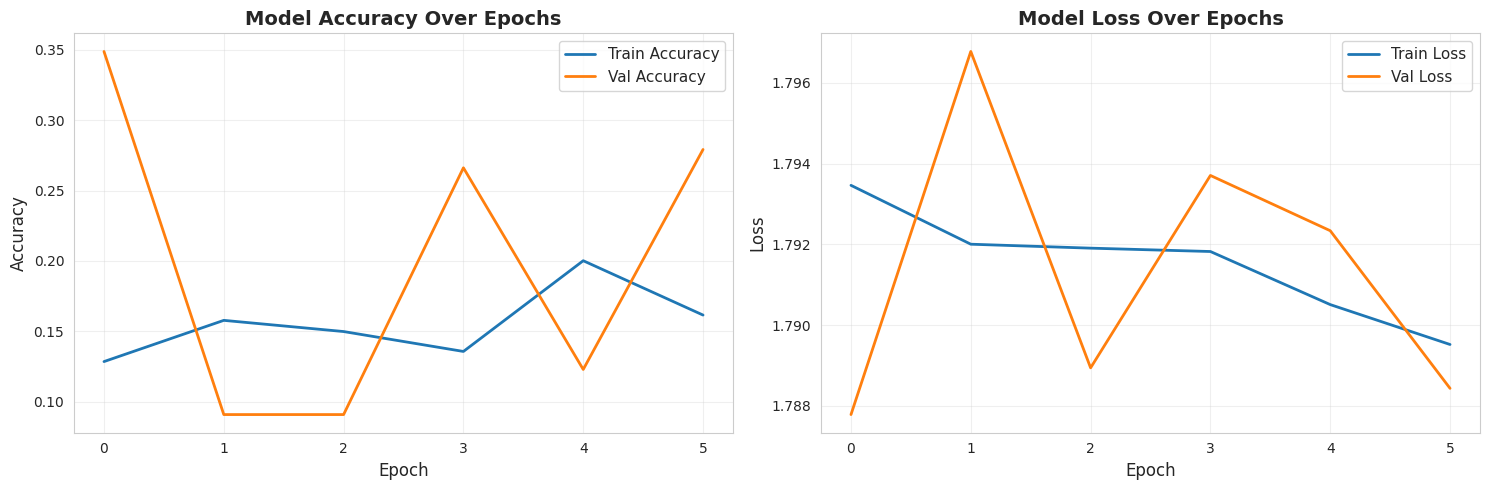


TRAINING STATISTICS
Epochs trained: 6

Final metrics:
  Train accuracy: 0.1615
  Train loss: 1.7895
  Val accuracy: 0.2792
  Val loss: 1.7884

Best metrics:
  Best val accuracy: 0.3489 (epoch 1)
  Best val loss: 1.7878 (epoch 1)


In [19]:
# Plot training history
visualizer.plot_training_history(
    history,
    save_path=os.path.join(config.result_dir, f'{config.experiment_name}_training_history.png')
)

# Display training statistics
print("\n" + "="*80)
print("TRAINING STATISTICS")
print("="*80)
print(f"Epochs trained: {len(history.history['loss'])}")
print(f"\nFinal metrics:")
print(f"  Train accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Train loss: {history.history['loss'][-1]:.4f}")
print(f"  Val accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Val loss: {history.history['val_loss'][-1]:.4f}")
print(f"\nBest metrics:")
print(f"  Best val accuracy: {max(history.history['val_accuracy']):.4f} (epoch {np.argmax(history.history['val_accuracy'])+1})")
print(f"  Best val loss: {min(history.history['val_loss']):.4f} (epoch {np.argmin(history.history['val_loss'])+1})")
print("="*80)

##  Section 21: Confusion Matrix

In [20]:
# Make predictions
print("="*80)
print("MAKING PREDICTIONS")
print("="*80)

y_train_pred = model.predict(X_train, verbose=0)
y_val_pred = model.predict(X_val, verbose=0)

# Convert to class labels
y_train_pred_labels = y_train_pred.argmax(axis=1)
y_val_pred_labels = y_val_pred.argmax(axis=1)

# Calculate comprehensive metrics
print("\n" + "="*80)
print("VALIDATION SET METRICS")
print("="*80)

# Overall accuracy
val_accuracy = accuracy_score(y_val, y_val_pred_labels)
print(f"\nOverall Accuracy: {val_accuracy:.4f}")

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_val, y_val_pred_labels, labels=list(range(config.num_classes))
)

# Macro averages
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

print(f"\nMacro-averaged metrics:")
print(f"  Precision: {macro_precision:.4f}")
print(f"  Recall: {macro_recall:.4f}")
print(f"  F1-Score: {macro_f1:.4f}")

# Per-class breakdown
print(f"\nPer-class metrics:")
print(f"{'Emotion':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
print("-" * 60)
for i, emotion in emotion_map.items():
    print(f"{emotion.capitalize():<12} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<12}")

print("="*80)

# Store metrics for later use
metrics = {
    'val_accuracy': val_accuracy,
    'val_loss': history.history['val_loss'][-1],
    'macro_precision': macro_precision,
    'macro_recall': macro_recall,
    'macro_f1': macro_f1,
    'per_class_precision': precision.tolist(),
    'per_class_recall': recall.tolist(),
    'per_class_f1': f1.tolist(),
    'training_time': training_time
}

# Save metrics to JSON
metrics_path = os.path.join(config.result_dir, f'{config.experiment_name}_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"\n Metrics saved to {metrics_path}")

MAKING PREDICTIONS



VALIDATION SET METRICS

Overall Accuracy: 0.3489

Macro-averaged metrics:
  Precision: 0.2049
  Recall: 0.1679
  F1-Score: 0.0933

Per-class metrics:
Emotion      Precision    Recall       F1-Score     Support     
------------------------------------------------------------
Sadness      0.5000       0.0036       0.0072       550         
Joy          0.3524       0.9843       0.5190       702         
Love         0.0000       0.0000       0.0000       175         
Anger        0.3333       0.0073       0.0142       275         
Fear         0.0000       0.0000       0.0000       212         
Surprise     0.0435       0.0123       0.0192       81          

 Metrics saved to results/ultimate_emotion_detection_metrics.json


##  Section 22: Classification Report Visualization

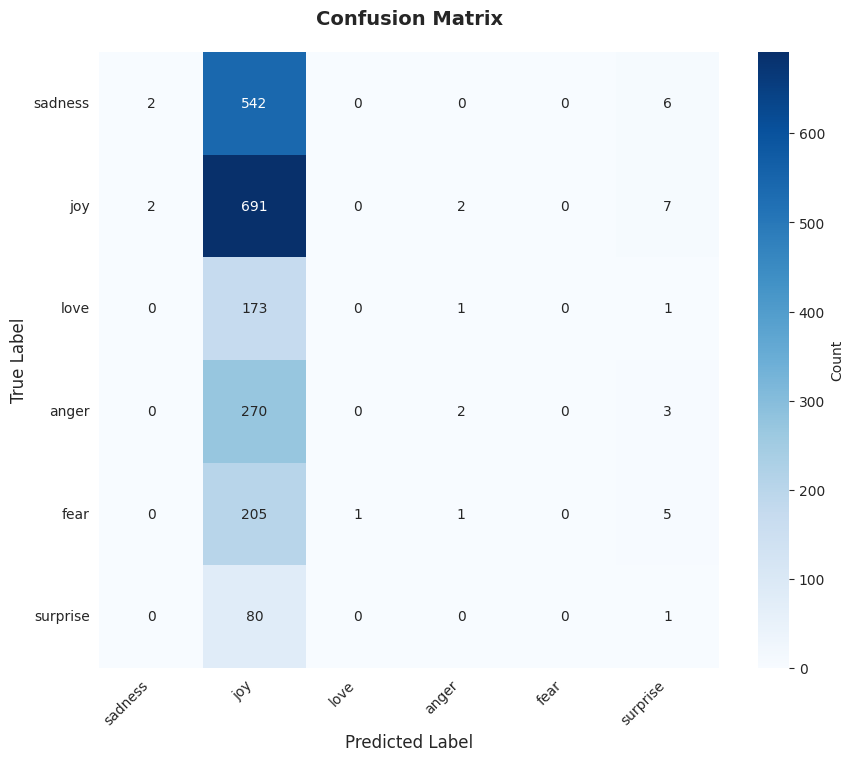

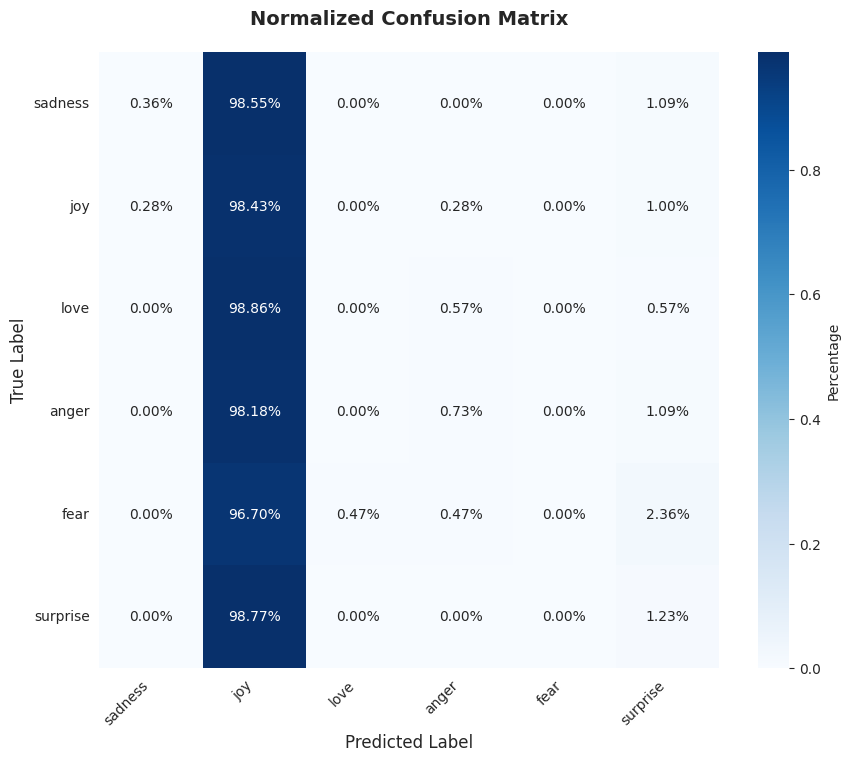

In [21]:
# Plot raw confusion matrix
visualizer.plot_confusion_matrix(
    y_val, y_val_pred_labels, 
    normalize=False,
    save_path=os.path.join(config.result_dir, f'{config.experiment_name}_confusion_matrix.png')
)

# Plot normalized confusion matrix
visualizer.plot_confusion_matrix(
    y_val, y_val_pred_labels, 
    normalize=True,
    save_path=os.path.join(config.result_dir, f'{config.experiment_name}_confusion_matrix_normalized.png')
)

##  Section 23: Per-Class F1 Scores

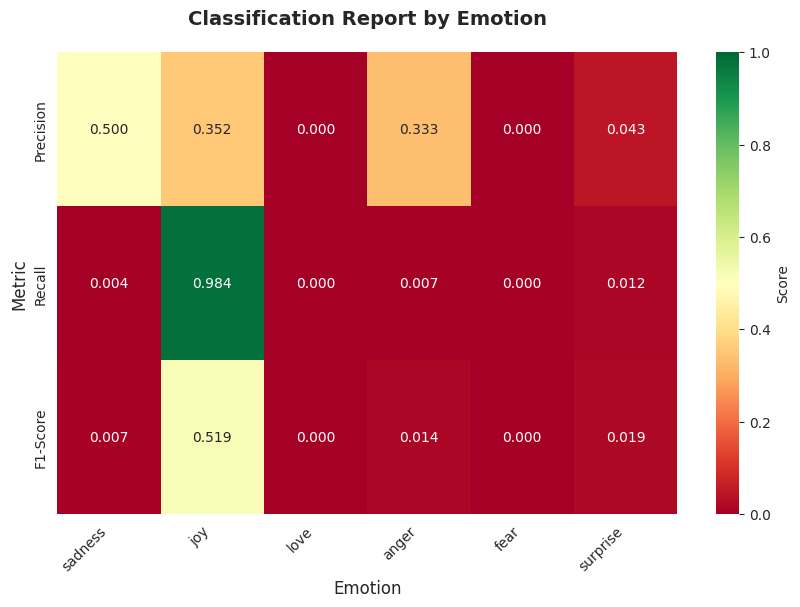


Classification Report DataFrame:
          Precision    Recall  F1-Score
sadness    0.500000  0.003636  0.007220
joy        0.352371  0.984330  0.518964
love       0.000000  0.000000  0.000000
anger      0.333333  0.007273  0.014235
fear       0.000000  0.000000  0.000000
surprise   0.043478  0.012346  0.019231


In [22]:
# Plot classification report heatmap
metrics_df = visualizer.plot_classification_report(
    y_val, y_val_pred_labels,
    save_path=os.path.join(config.result_dir, f'{config.experiment_name}_classification_report.png')
)

print("\nClassification Report DataFrame:")
print(metrics_df)

# Save to CSV
metrics_df.to_csv(os.path.join(config.result_dir, f'{config.experiment_name}_classification_report.csv'))

##  Section 24: Model Comparison (Run multiple experiments)

##  Section 25: View Comparison Table

In [23]:
# Initialize model comparer
comparer = ModelComparer(emotion_map)

# Add current experiment
comparer.add_experiment(
    name=config.experiment_name,
    config=config,
    history=history,
    metrics=metrics,
    predictions=y_val_pred_labels,
    y_true=y_val
)

print(" Current experiment added to comparer")
print("\nTo add more experiments:")
print("1. Modify config in Section 2 (e.g., config.model_type = 'gru')")
print("2. Re-run sections 15-23")
print("3. Run: comparer.add_experiment(name='experiment_2', config=config, history=history, metrics=metrics)")
print("4. View comparison: comparer.create_comparison_table()")

# Example: Uncomment and modify to add more experiments
# config.model_type = 'gru'
# config.experiment_name = 'gru_128'
# # Re-run training...
# comparer.add_experiment(name='gru_128', config=config, history=history, metrics=metrics)

2025-12-17 14:05:17,683 - INFO - Added experiment: ultimate_emotion_detection


 Current experiment added to comparer

To add more experiments:
1. Modify config in Section 2 (e.g., config.model_type = 'gru')
2. Re-run sections 15-23
3. Run: comparer.add_experiment(name='experiment_2', config=config, history=history, metrics=metrics)
4. View comparison: comparer.create_comparison_table()


##  Section 26: Prediction Function

---
#  PREDICTIONS AND INTERACTIVE TESTING

In [24]:
# Display comparison table
comparison_df = comparer.create_comparison_table()
print("="*80)
print("MODEL COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Plot comparison
if len(comparer.experiments) > 1:
    comparer.plot_comparison(metric='val_accuracy')
    comparer.plot_comparison(metric='macro_f1')
    
    # Save comparison
    comparison_path = os.path.join(config.result_dir, 'model_comparison.csv')
    comparer.save_comparison(comparison_path)
else:
    print("\n Add more experiments to enable comparison visualizations")

MODEL COMPARISON TABLE
                Experiment Model  RNN Units  Layers Embedding  Embed Dim  Trainable Emb  Dropout  Val Accuracy  Val Loss  Macro F1  Training Time
ultimate_emotion_detection  LSTM        128       1     GLOVE        100          False      0.2      0.348872  1.788435  0.093275     122.323744

 Add more experiments to enable comparison visualizations


##  Section 27: Test Predictions with Examples

In [25]:
def predict_emotion(text: str, show_probabilities: bool = True) -> Dict:
    """
    Predict emotion for a given text.
    
    Args:
        text: Input text
        show_probabilities: Whether to show probabilities for all classes
        
    Returns:
        Dictionary with prediction results
    """
    # Preprocess text
    cleaned_text = preprocessor.clean_text(text)
    
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequence, maxlen=config.max_len, padding='post', truncating='post')
    
    # Predict
    predictions = model.predict(padded, verbose=0)[0]
    predicted_label = predictions.argmax()
    predicted_emotion = emotion_map[predicted_label]
    confidence = predictions[predicted_label]
    
    result = {
        'original_text': text,
        'cleaned_text': cleaned_text,
        'predicted_emotion': predicted_emotion,
        'predicted_label': int(predicted_label),
        'confidence': float(confidence)
    }
    
    if show_probabilities:
        result['all_probabilities'] = {
            emotion_map[i]: float(predictions[i]) 
            for i in range(len(predictions))
        }
    
    return result


def display_prediction(text: str):
    """Display prediction with formatting."""
    result = predict_emotion(text, show_probabilities=True)
    
    print("="*80)
    print("EMOTION PREDICTION")
    print("="*80)
    print(f"Original Text: {result['original_text']}")
    print(f"Cleaned Text:  {result['cleaned_text']}")
    print(f"\n Predicted Emotion: {result['predicted_emotion'].upper()}")
    print(f"   Confidence: {result['confidence']*100:.2f}%")
    print(f"\nAll Probabilities:")
    for emotion, prob in sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True):
        bar = '' * int(prob * 50)
        print(f"  {emotion.capitalize():<12} {prob*100:5.2f}% {bar}")
    print("="*80)


print(" Prediction functions created!")
print("\nUsage:")
print("  display_prediction('I am so happy today!')")
print("  result = predict_emotion('I feel terrible', show_probabilities=True)")

 Prediction functions created!

Usage:
  display_prediction('I am so happy today!')
  result = predict_emotion('I feel terrible', show_probabilities=True)


##  Section 28: Pipeline Summary

---
#  FINAL SUMMARY AND NEXT STEPS

In [26]:
# Test with sample texts for each emotion
test_samples = [
    "I am so sad and depressed today",
    "This is the happiest day of my life!",
    "I love you so much, you mean everything to me",
    "I am so angry and furious right now!",
    "I'm really scared and terrified about this",
    "Wow! I can't believe this happened, so unexpected!"
]

print("Testing predictions on sample texts:\n")
for i, text in enumerate(test_samples, 1):
    print(f"\n{'='*80}")
    print(f"Example {i}:")
    display_prediction(text)
    print()

Testing predictions on sample texts:


Example 1:
EMOTION PREDICTION
Original Text: I am so sad and depressed today
Cleaned Text:  i am so sad and depressed today

 Predicted Emotion: JOY
   Confidence: 17.16%

All Probabilities:
  Joy          17.16% 
  Surprise     17.10% 
  Sadness      16.53% 
  Fear         16.50% 
  Love         16.45% 
  Anger        16.25% 


Example 2:
EMOTION PREDICTION
Original Text: This is the happiest day of my life!
Cleaned Text:  this is the happiest day of my life!

 Predicted Emotion: JOY
   Confidence: 17.16%

All Probabilities:
  Joy          17.16% 
  Surprise     17.10% 
  Sadness      16.53% 
  Fear         16.50% 
  Love         16.45% 
  Anger        16.25% 


Example 3:


EMOTION PREDICTION
Original Text: I love you so much, you mean everything to me
Cleaned Text:  i love you so much, you mean everything to me

 Predicted Emotion: JOY
   Confidence: 17.16%

All Probabilities:
  Joy          17.16% 
  Surprise     17.10% 
  Sadness      16.53% 
  Fear         16.50% 
  Love         16.45% 
  Anger        16.25% 


Example 4:
EMOTION PREDICTION
Original Text: I am so angry and furious right now!
Cleaned Text:  i am so angry and furious right now!

 Predicted Emotion: JOY
   Confidence: 17.16%

All Probabilities:
  Joy          17.16% 
  Surprise     17.10% 
  Sadness      16.53% 
  Fear         16.50% 
  Love         16.45% 
  Anger        16.25% 


Example 5:
EMOTION PREDICTION
Original Text: I'm really scared and terrified about this
Cleaned Text:  i am really scared and terrified about this

 Predicted Emotion: JOY
   Confidence: 17.16%

All Probabilities:
  Joy          17.16% 
  Surprise     17.10% 
  Sadness      16.53% 
  Fear         16.50% 
  Lov

EMOTION PREDICTION
Original Text: Wow! I can't believe this happened, so unexpected!
Cleaned Text:  wow! i ca not believe this happened, so unexpected!

 Predicted Emotion: JOY
   Confidence: 17.16%

All Probabilities:
  Joy          17.16% 
  Surprise     17.10% 
  Sadness      16.53% 
  Fear         16.50% 
  Love         16.45% 
  Anger        16.25% 



In [27]:
print("="*80)
print(" PIPELINE EXECUTION COMPLETE!")
print("="*80)

print("\n FINAL RESULTS SUMMARY")
print("-" * 80)
print(f"Experiment Name: {config.experiment_name}")
print(f"Model Type: {config.model_type.upper()}")
print(f"Embedding: {config.embedding_type.upper()} {config.embedding_dim}d")
print(f"RNN Units: {config.rnn_units}")
print(f"Layers: {config.num_rnn_layers}")
print(f"Trainable Embeddings: {config.trainable_embeddings}")
print(f"\nDataset:")
print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  Vocabulary size: {embedding_handler.stats['vocab_size']}")
print(f"  Embedding coverage: {embedding_handler.stats['coverage_percent']:.2f}%")
print(f"\nPerformance:")
print(f"  Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  Macro F1-Score: {macro_f1:.4f}")
print(f"  Training Time: {training_time:.2f}s ({training_time/60:.2f} min)")
print(f"  Epochs Trained: {len(history.history['loss'])}")
print(f"\nFiles Saved:")
print(f"   Model: {checkpoint_path}")
print(f"   Metrics: {metrics_path}")
print(f"   Training Log: {csv_path}")
if config.save_tokenizer:
    print(f"   Tokenizer: {os.path.join(config.config_dir, 'tokenizer.json')}")
if config.save_config:
    config_path = os.path.join(config.config_dir, f'{config.experiment_name}_config.json')
    config.save_to_json(config_path)
    print(f"   Config: {config_path}")

print("\n" + "="*80)
print(" NEXT STEPS FOR HYPERPARAMETER EXPERIMENTATION")
print("="*80)
print("""
1. COMPARE LSTM VS GRU:
   - Set config.model_type = 'gru' (or 'bilstm', 'bigru')
   - Re-run from Section 15 onwards
   - Use comparer.add_experiment() to track results

2. TRY DIFFERENT EMBEDDINGS:
   - Set config.embedding_type = 'word2vec'
   - Or change config.embedding_dim = 50 (for glove.6B.50d.txt)
   - Re-run from Section 16 onwards

3. ADJUST ARCHITECTURE:
   - config.rnn_units = 64 or 256
   - config.num_rnn_layers = 2
   - config.use_layer_norm = True
   - Re-run from Section 17 onwards

4. TUNE REGULARIZATION:
   - config.dropout = 0.3 or 0.5
   - config.spatial_dropout = 0.3
   - Re-run from Section 17 onwards

5. EXPERIMENT WITH TRAINABLE EMBEDDINGS:
   - config.trainable_embeddings = True
   - Re-run from Section 17 onwards

6. COMPARE RESULTS:
   - View: comparer.create_comparison_table()
   - Plot: comparer.plot_comparison('val_accuracy')
   - Save: comparer.save_comparison('results/comparison.csv')
""")

print("="*80)
print(" All done! Happy experimenting! ")
print("="*80)

2025-12-17 14:05:18,175 - INFO - Configuration saved to configs/ultimate_emotion_detection_config.json


 PIPELINE EXECUTION COMPLETE!

 FINAL RESULTS SUMMARY
--------------------------------------------------------------------------------
Experiment Name: ultimate_emotion_detection
Model Type: LSTM
Embedding: GLOVE 100d
RNN Units: 128
Layers: 1
Trainable Embeddings: False

Dataset:
  Training samples: 15966
  Validation samples: 1995
  Vocabulary size: 15156
  Embedding coverage: 93.68%

Performance:
  Validation Accuracy: 0.3489 (34.89%)
  Macro F1-Score: 0.0933
  Training Time: 122.32s (2.04 min)
  Epochs Trained: 6

Files Saved:
   Model: saved_models/ultimate_emotion_detection_best_model.h5
   Metrics: results/ultimate_emotion_detection_metrics.json
   Training Log: logs/ultimate_emotion_detection_training.csv
   Tokenizer: configs/tokenizer.json
   Config: configs/ultimate_emotion_detection_config.json

 NEXT STEPS FOR HYPERPARAMETER EXPERIMENTATION

1. COMPARE LSTM VS GRU:
   - Set config.model_type = 'gru' (or 'bilstm', 'bigru')
   - Re-run from Section 15 onwards
   - Use compare